In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from google.colab import drive
import warnings
warnings.filterwarnings('ignore')

# Mount Google Drive
drive.mount('/content/drive')

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/train_dataset_full.csv')
df_ = df.copy()

# Preprocessing
df_.drop('product_category_2', axis=1, inplace=True)
df_.drop('city_development_index', axis=1, inplace=True)
df_ = df_[~df_['session_id'].duplicated(keep='first') | df_['session_id'].isna()]
df_.dropna(subset=['is_click'], axis=0, inplace=True)
labels = ['gender', 'age_level', 'user_group_id']
df_[labels] = df_.groupby('user_id')[labels].transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))
df_ = df_.dropna(thresh=len(df.columns) - 5)
df_['DateTime'] = pd.to_datetime(df_['DateTime'])
df_['day'] = df_['DateTime'].dt.day
df_['hour'] = df_['DateTime'].dt.hour
df_ = df_.dropna(axis=0)

df_.info()



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
<class 'pandas.core.frame.DataFrame'>
Index: 350618 entries, 0 to 389111
Data columns (total 16 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   session_id              350246 non-null  float64       
 1   DateTime                350239 non-null  datetime64[ns]
 2   user_id                 350618 non-null  float64       
 3   product                 350281 non-null  object        
 4   campaign_id             350262 non-null  float64       
 5   webpage_id              350248 non-null  float64       
 6   product_category_1      350265 non-null  float64       
 7   user_group_id           350561 non-null  float64       
 8   gender                  350567 non-null  object        
 9   age_level               350566 non-null  float64       
 10  user_depth              3502

In [ ]:
df_.drop('city_development_index', axis=1, inplace=True)
df_ = df_.dropna(axis=0)
df_.info()

<class 'pandas.core.frame.DataFrame'>
Index: 349147 entries, 0 to 370631
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   session_id          349147 non-null  float64       
 1   DateTime            349147 non-null  datetime64[ns]
 2   user_id             349147 non-null  float64       
 3   product             349147 non-null  object        
 4   campaign_id         349147 non-null  float64       
 5   webpage_id          349147 non-null  float64       
 6   product_category_1  349147 non-null  float64       
 7   user_group_id       349147 non-null  float64       
 8   gender              349147 non-null  object        
 9   age_level           349147 non-null  float64       
 10  user_depth          349147 non-null  float64       
 11  var_1               349147 non-null  float64       
 12  is_click            349147 non-null  float64       
 13  day                 349147 non-nul

In [ ]:
df_.info()

<class 'pandas.core.frame.DataFrame'>
Index: 350618 entries, 0 to 389111
Data columns (total 16 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   session_id              350246 non-null  float64       
 1   DateTime                350239 non-null  datetime64[ns]
 2   user_id                 350618 non-null  float64       
 3   product                 350281 non-null  object        
 4   campaign_id             350262 non-null  float64       
 5   webpage_id              350248 non-null  float64       
 6   product_category_1      350265 non-null  float64       
 7   user_group_id           350561 non-null  float64       
 8   gender                  350567 non-null  object        
 9   age_level               350566 non-null  float64       
 10  user_depth              350259 non-null  float64       
 11  city_development_index  266379 non-null  float64       
 12  var_1                   350249 non-

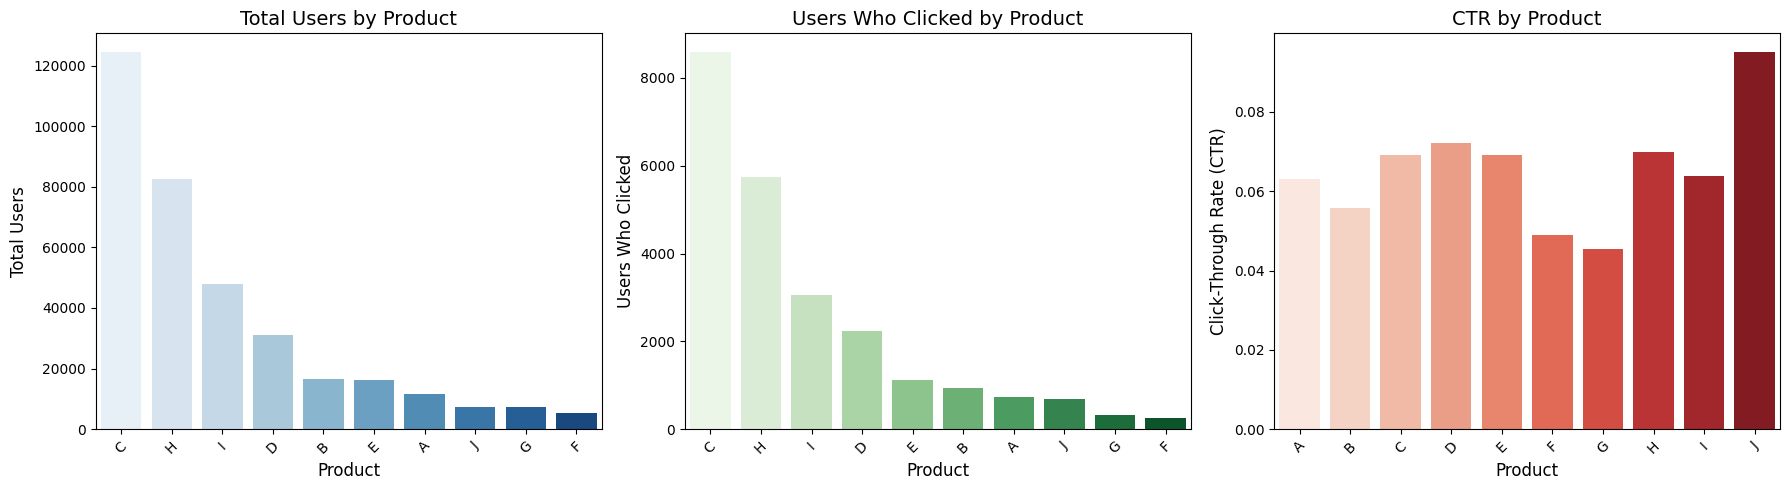

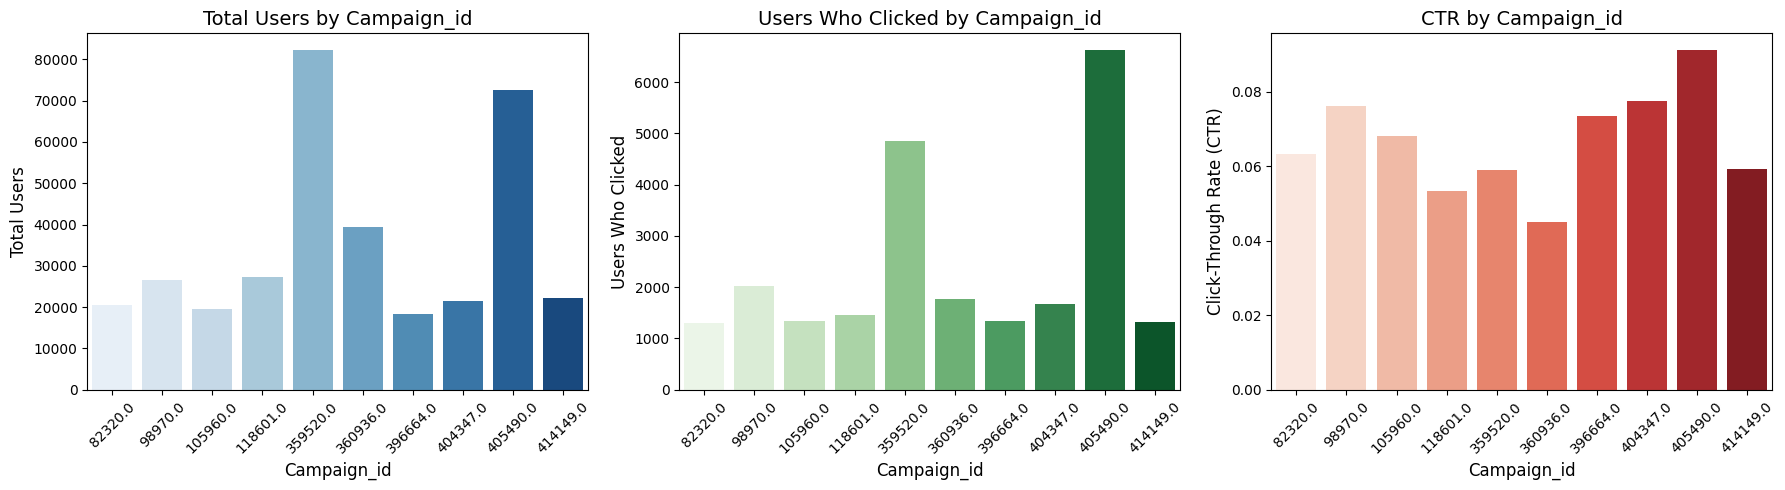

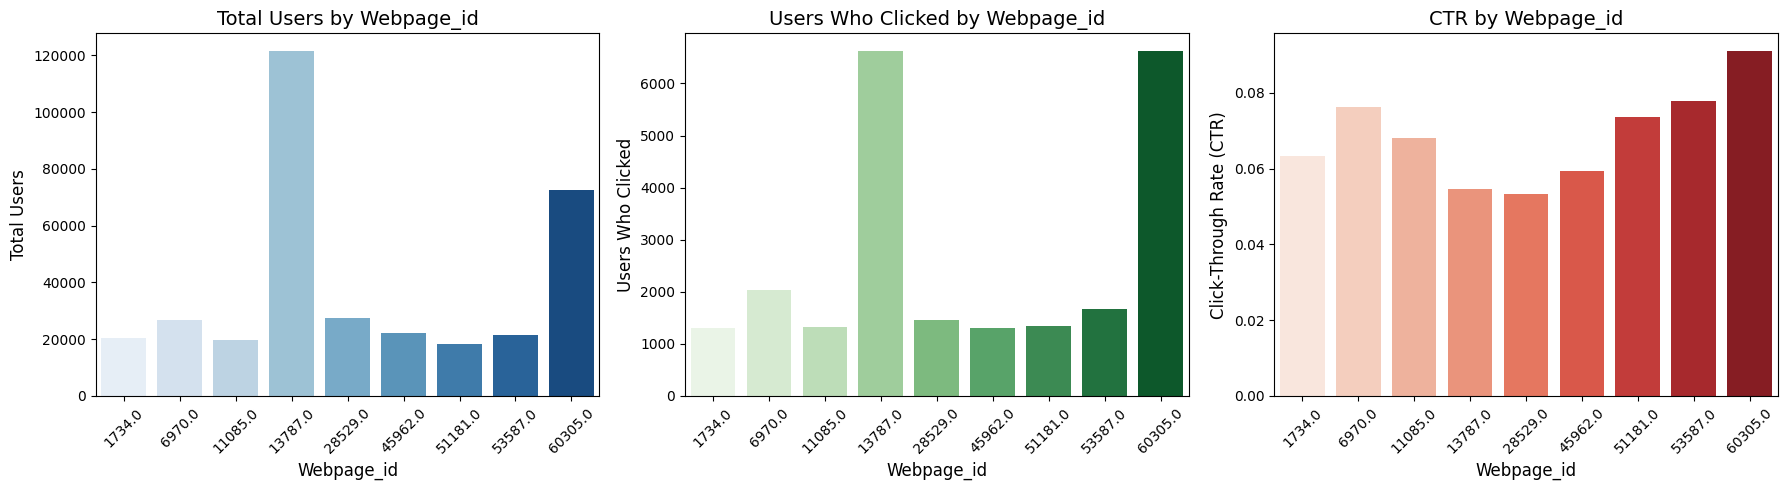

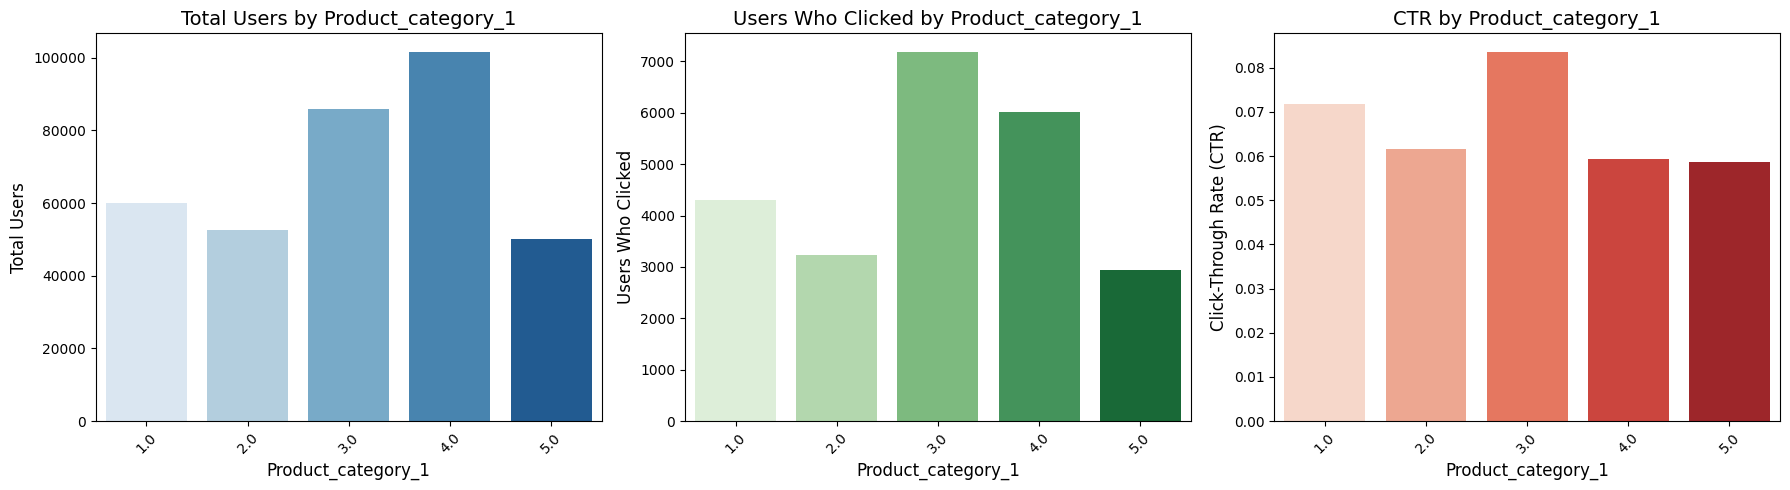

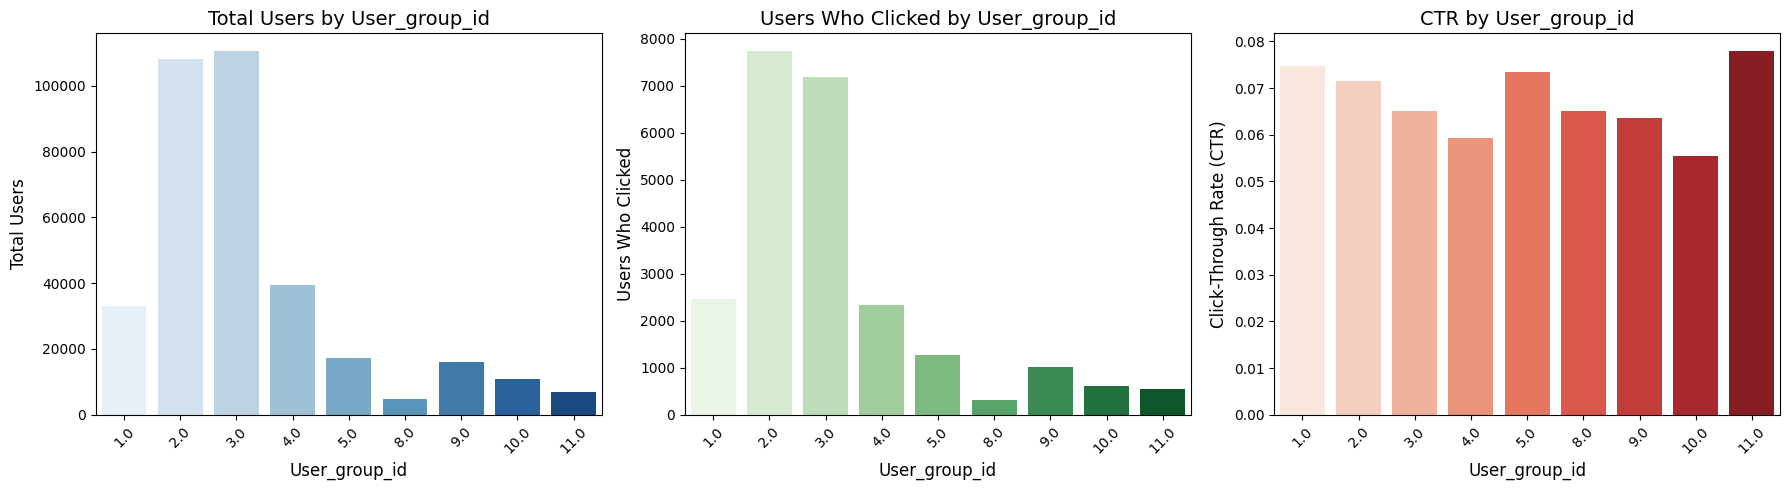

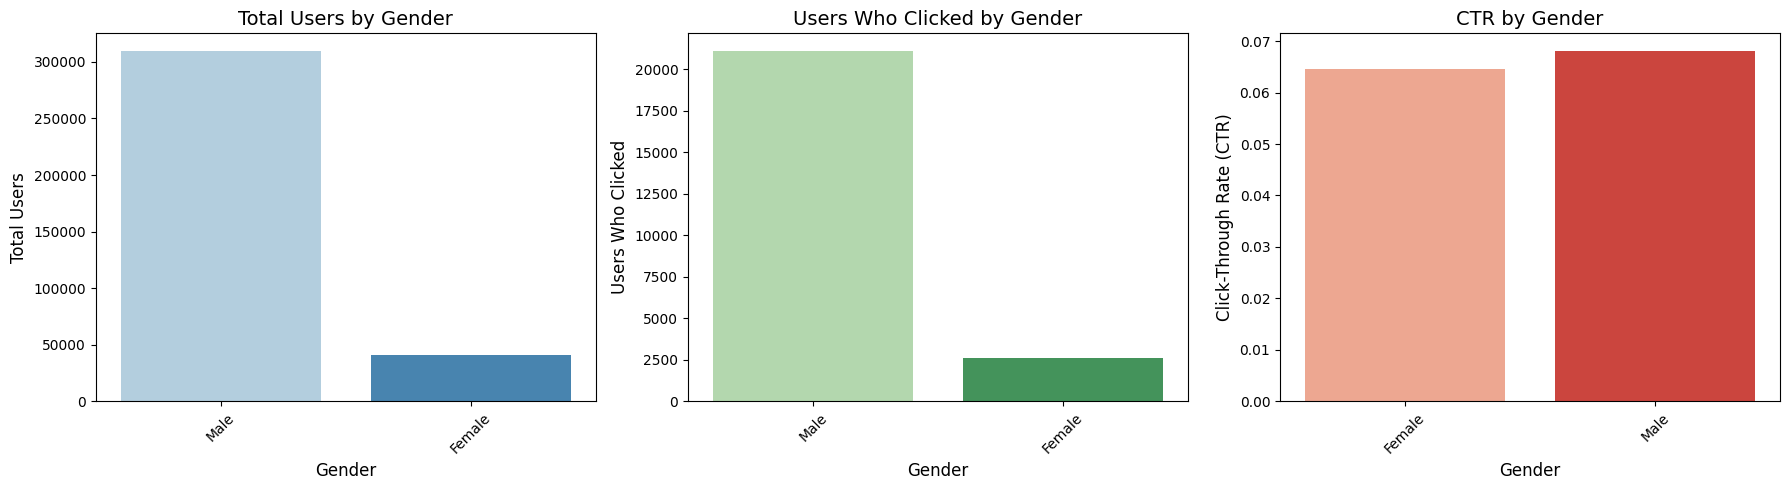

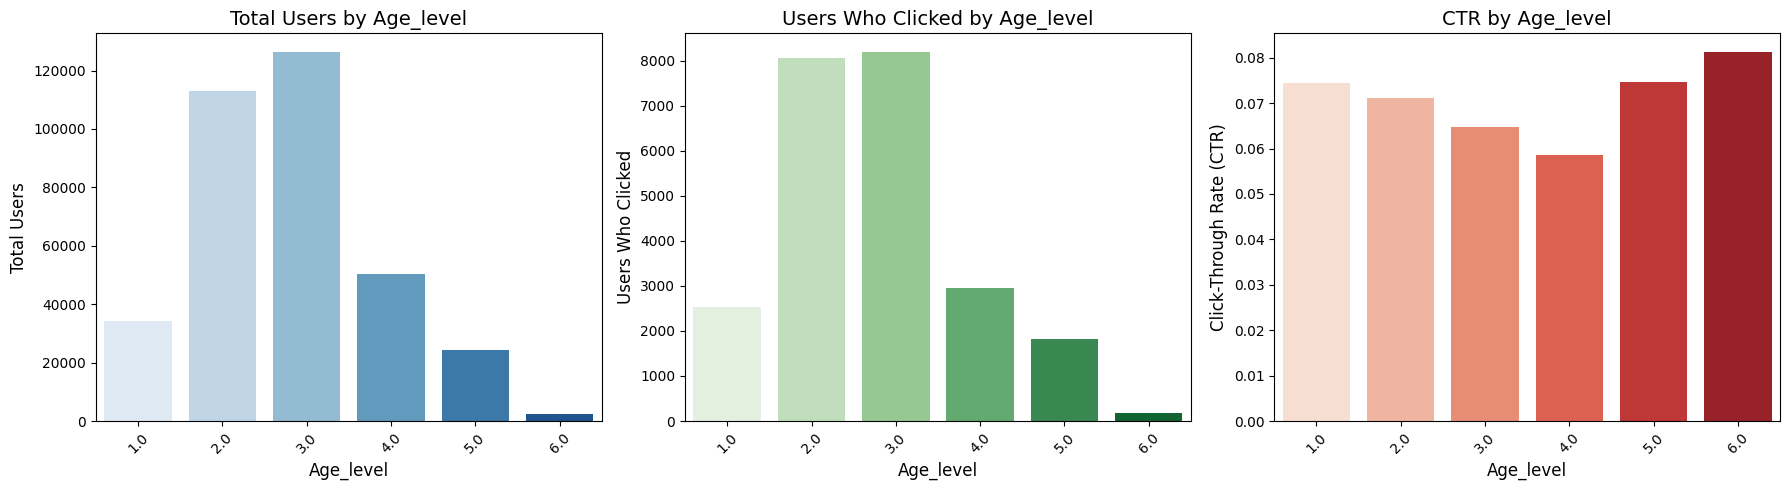

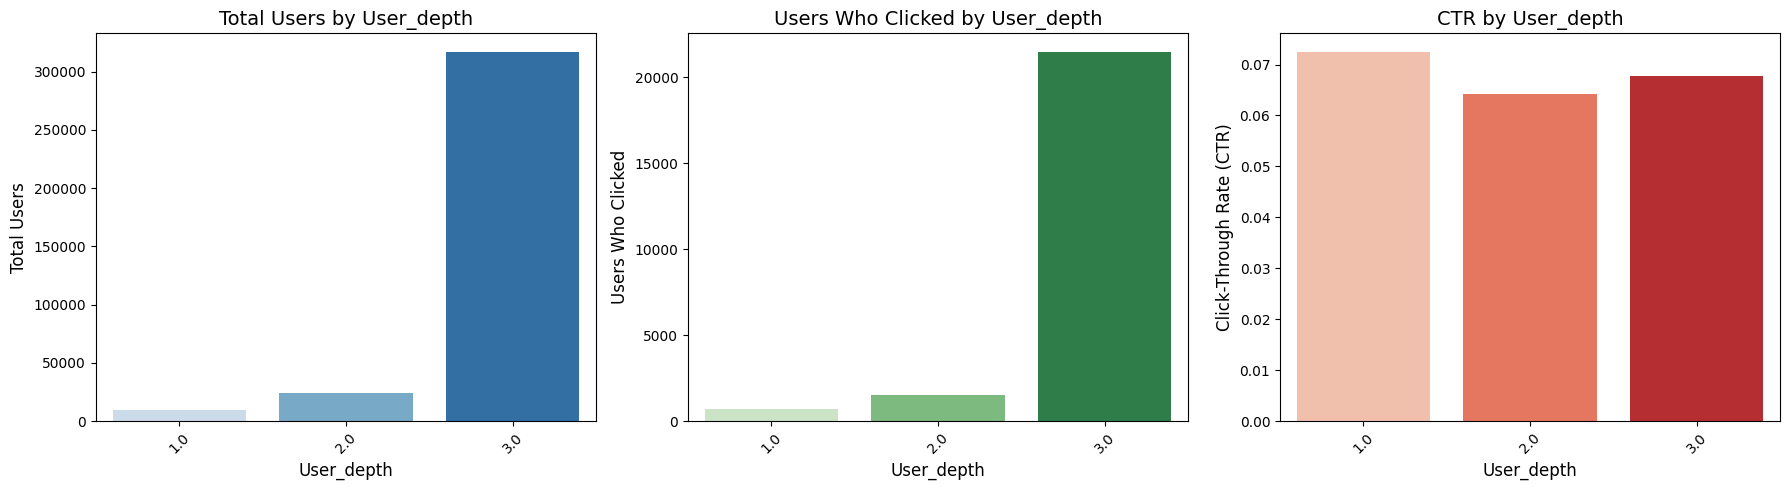

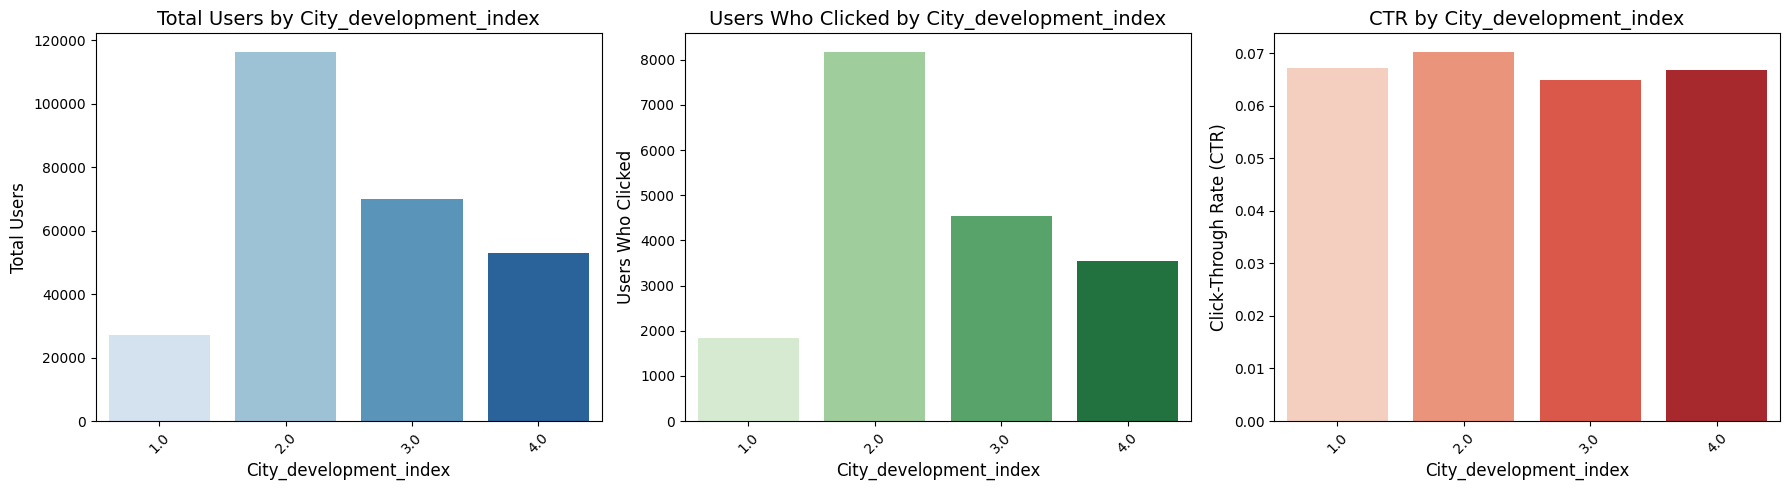

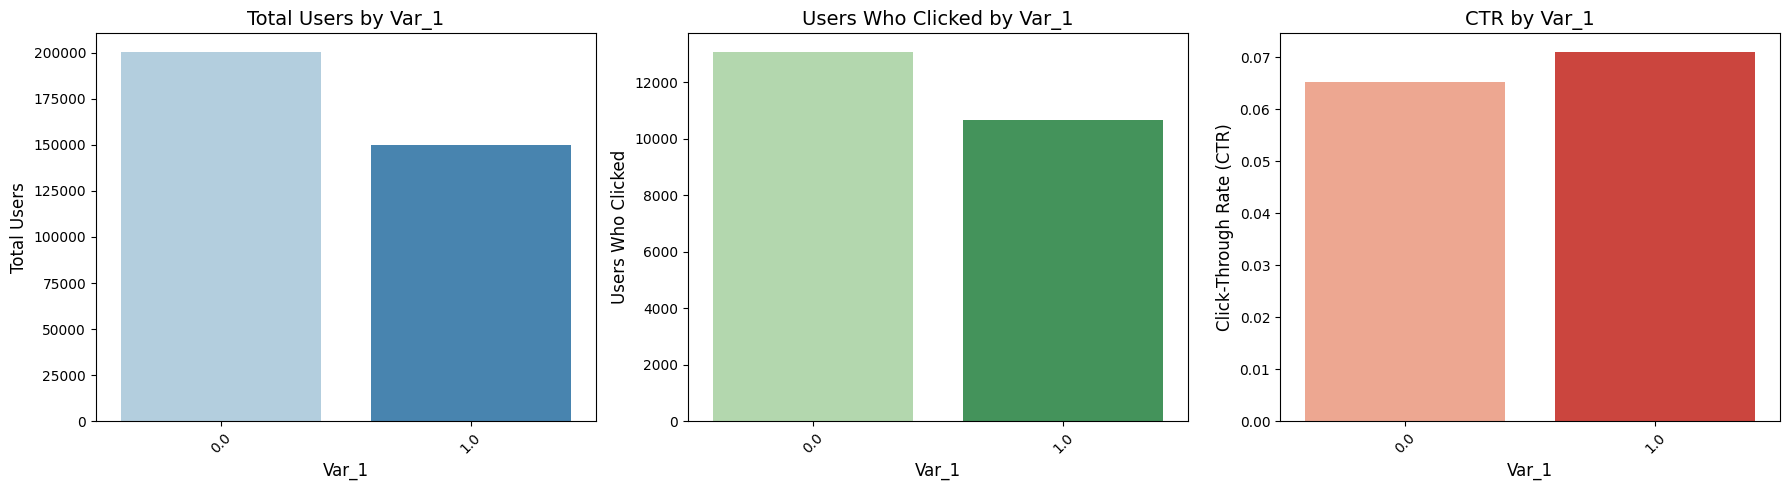

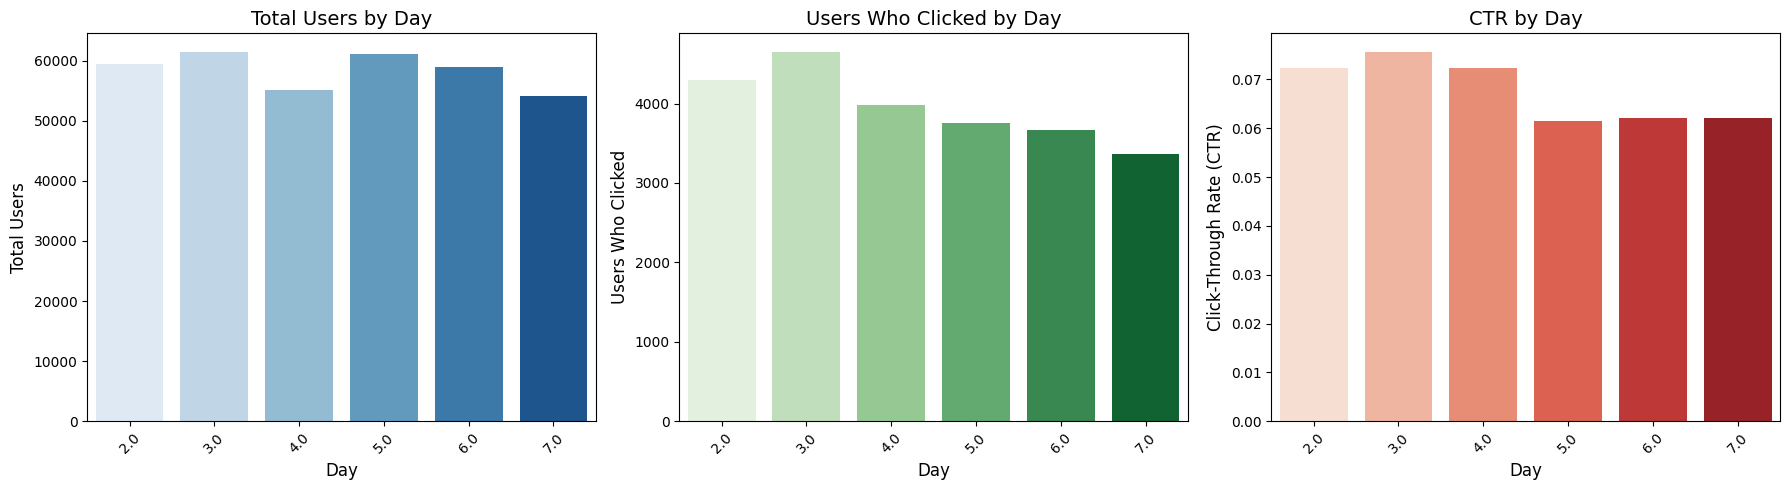

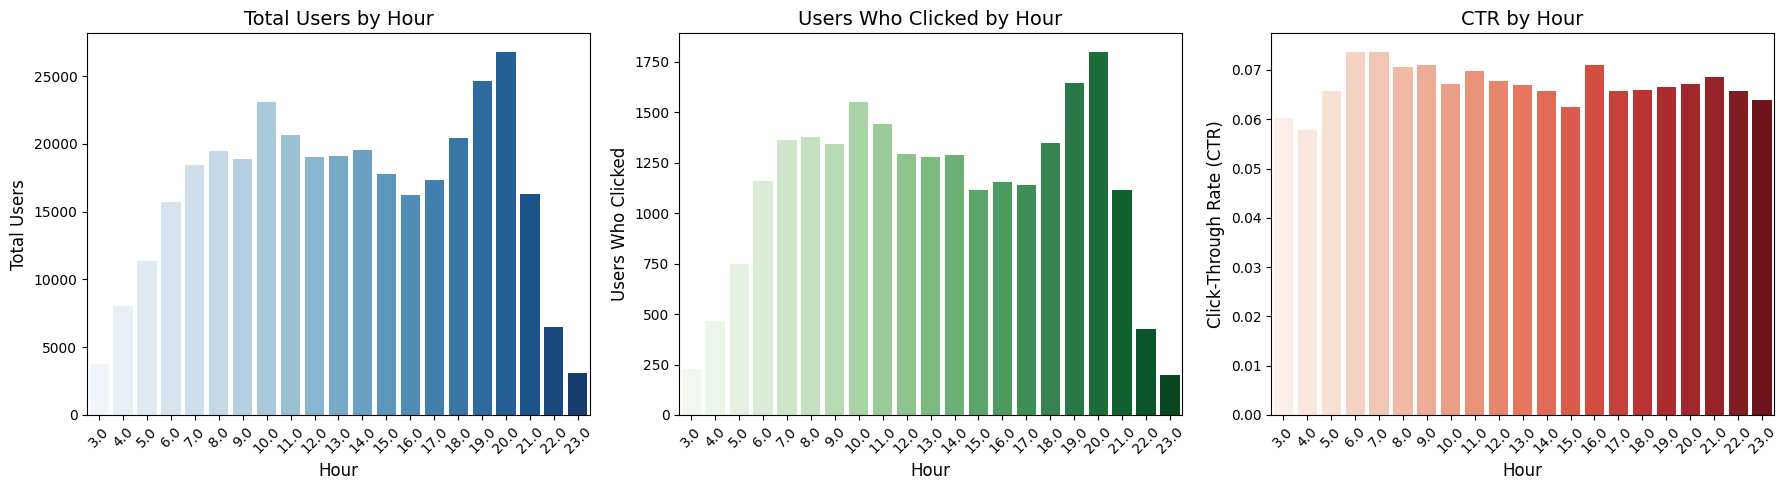

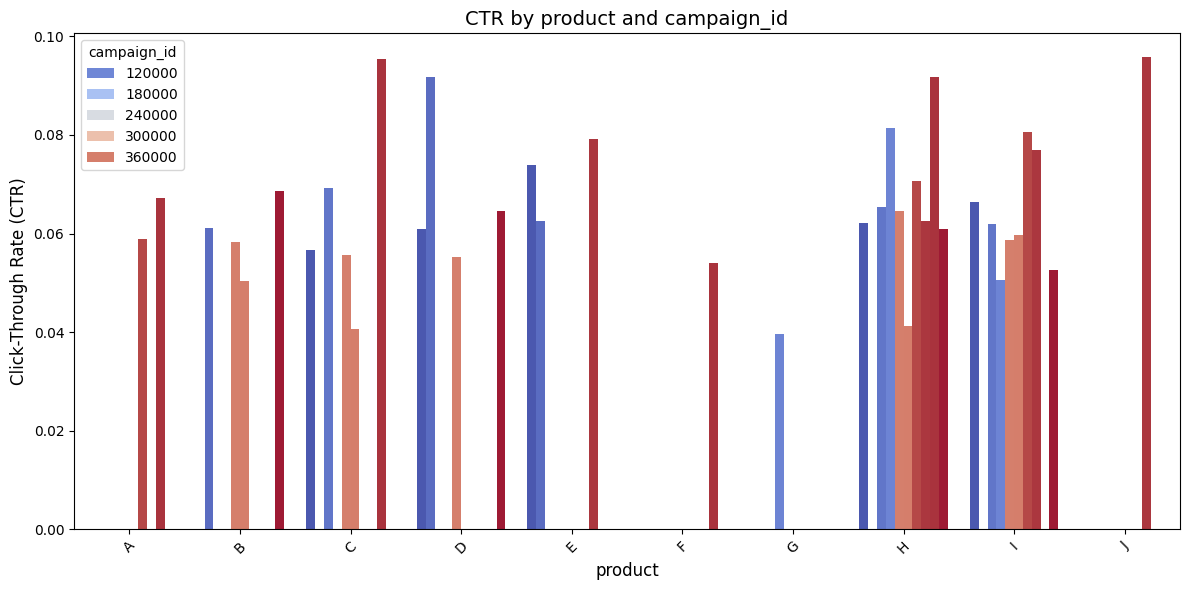

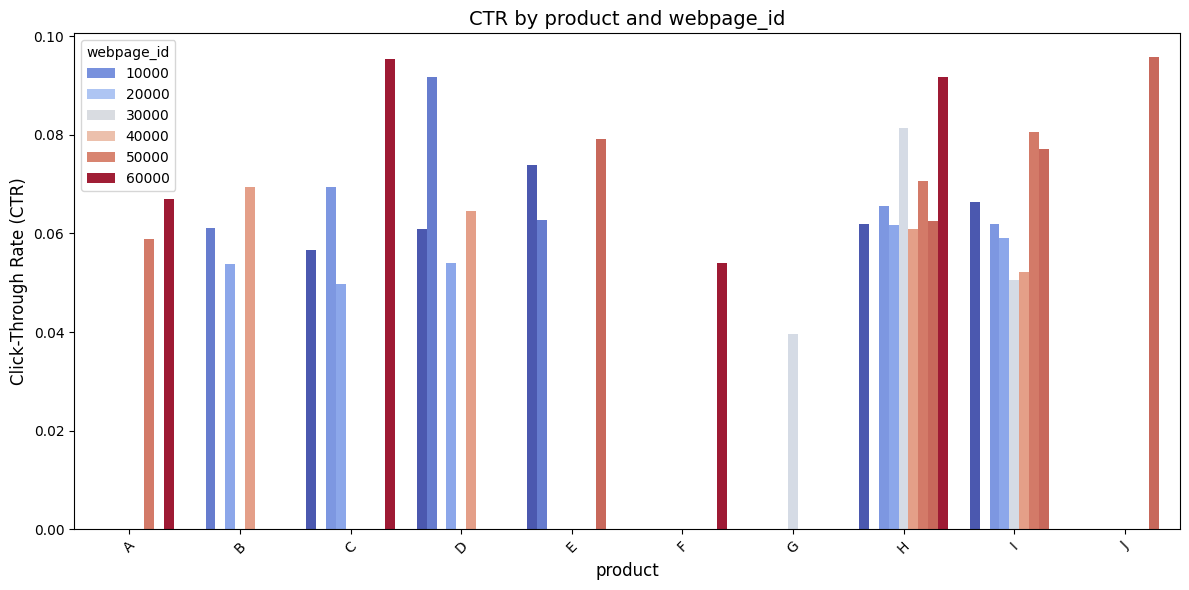

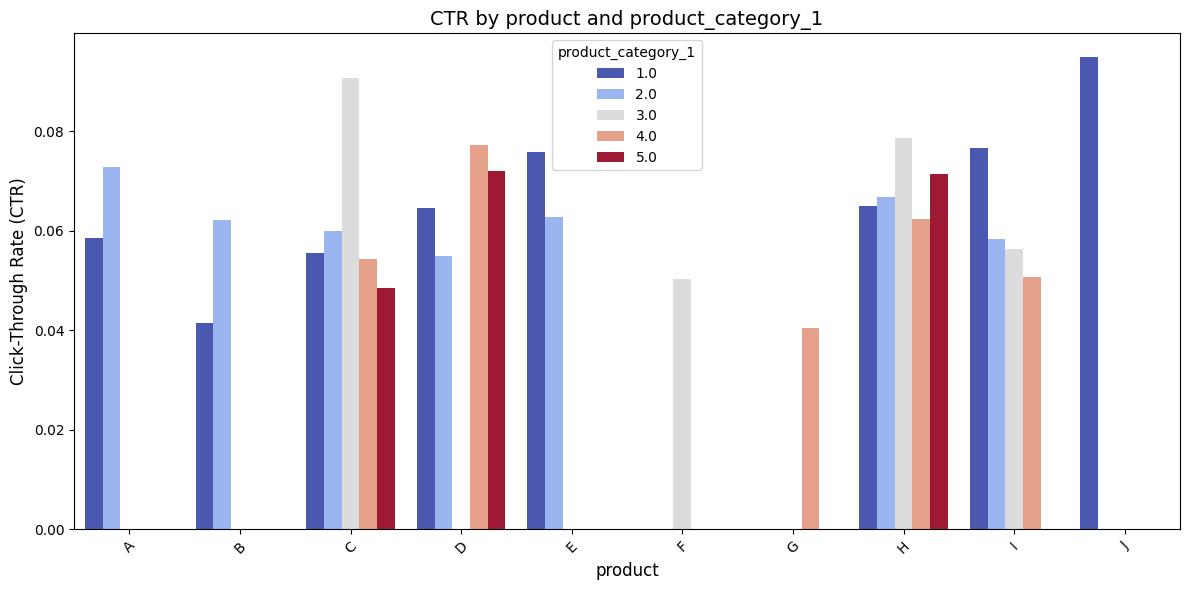

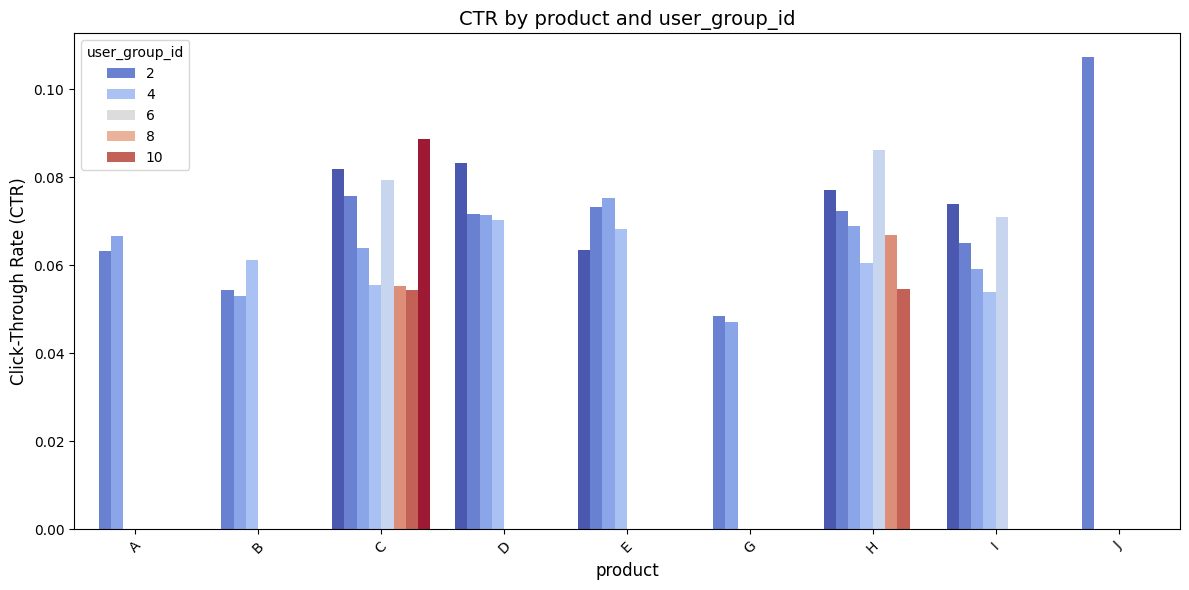

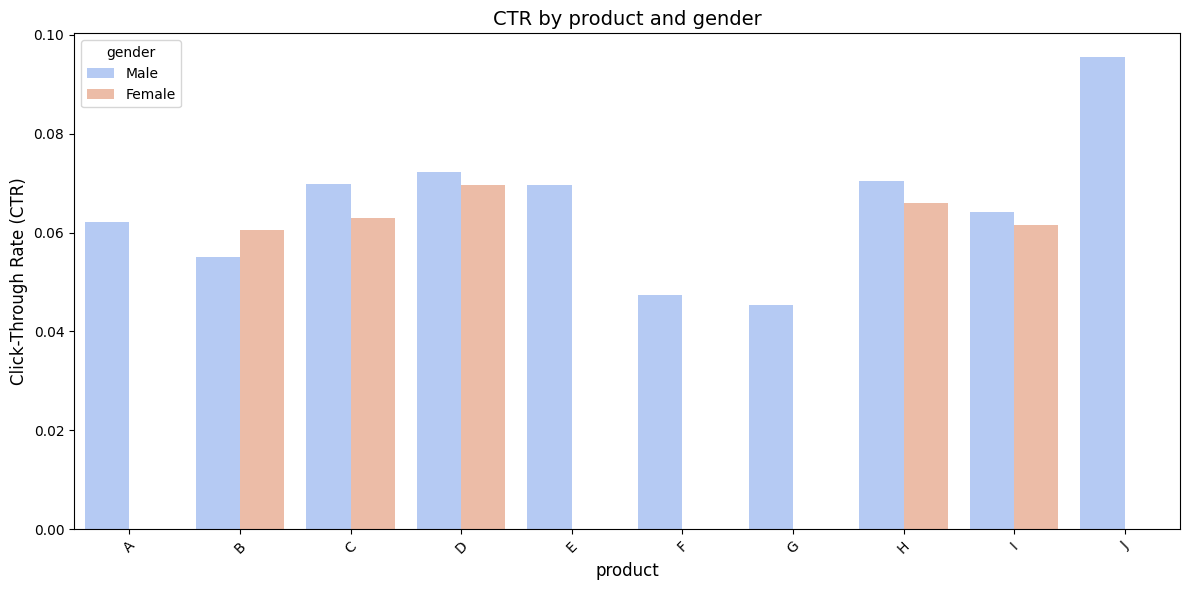

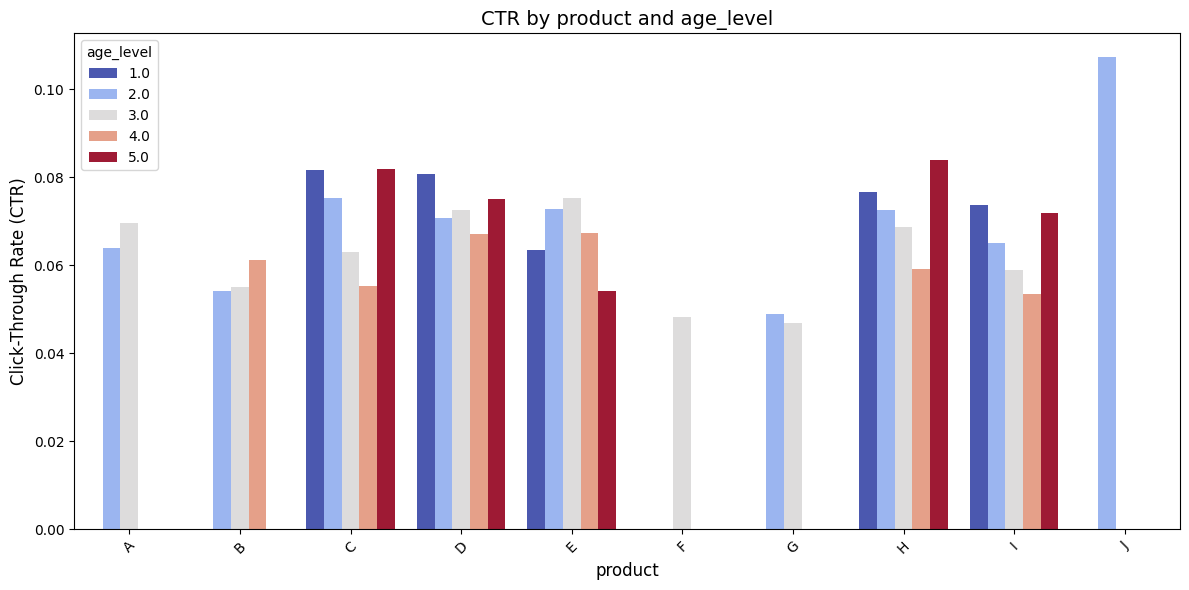

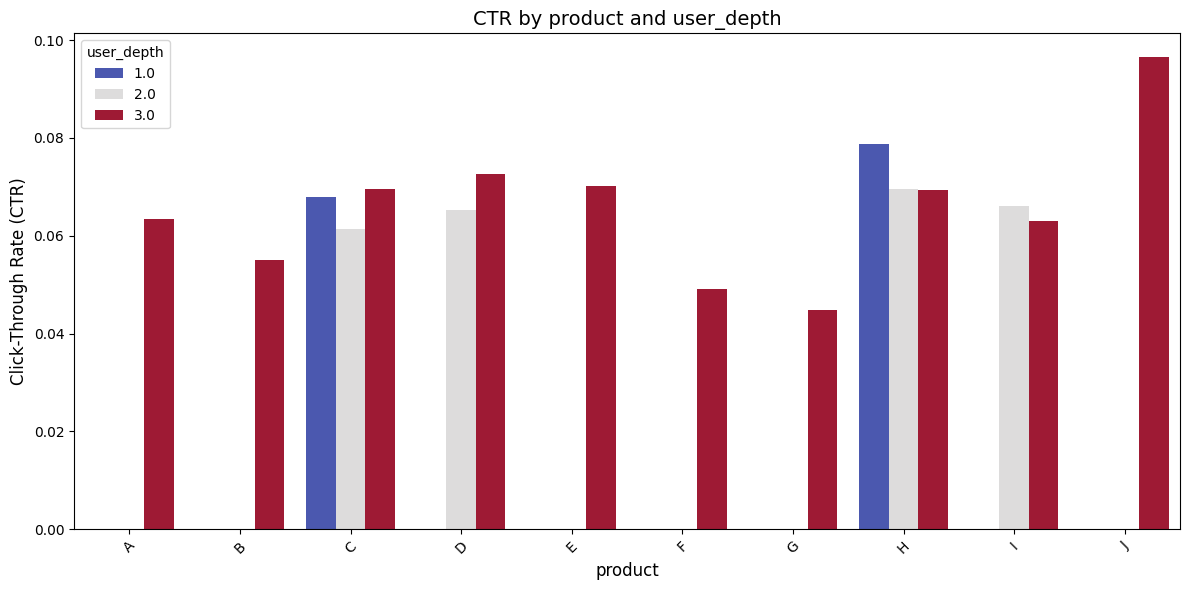

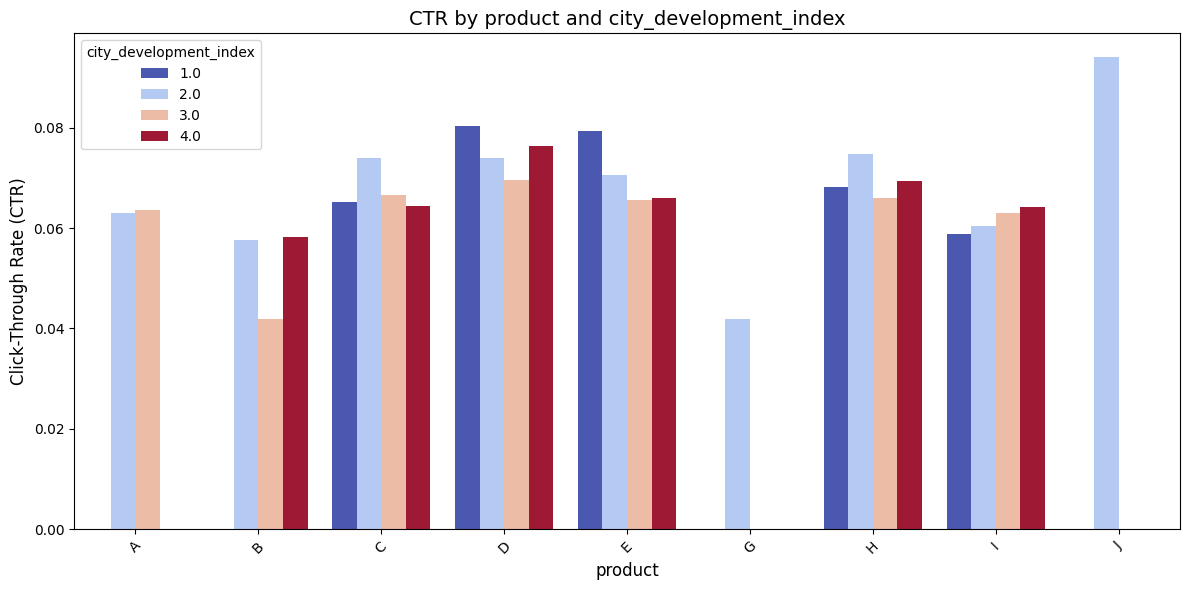

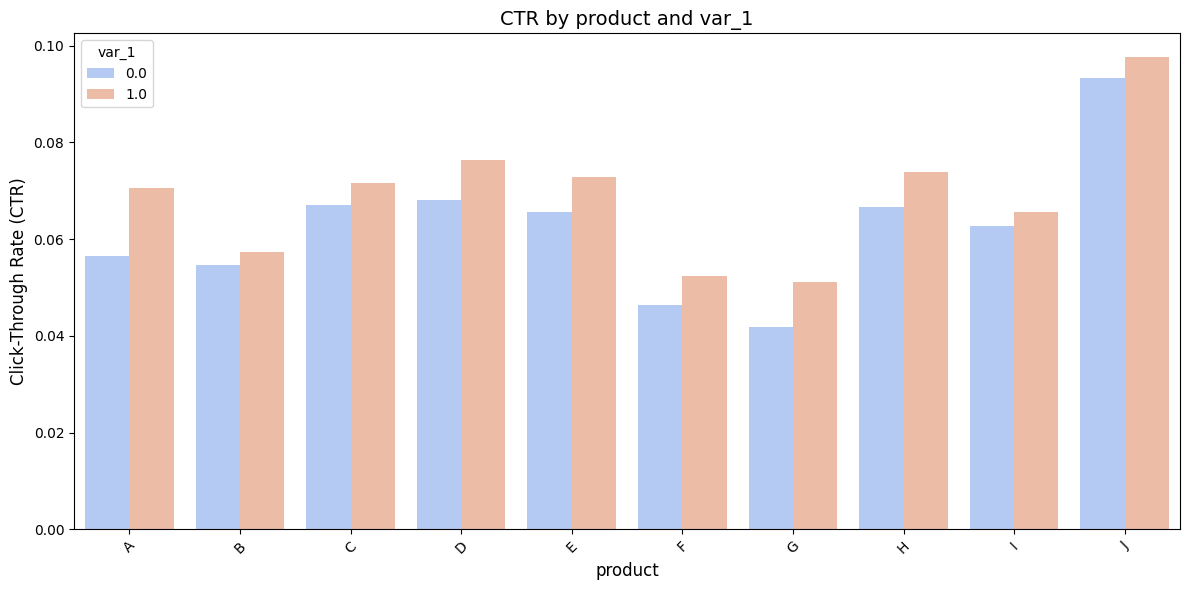

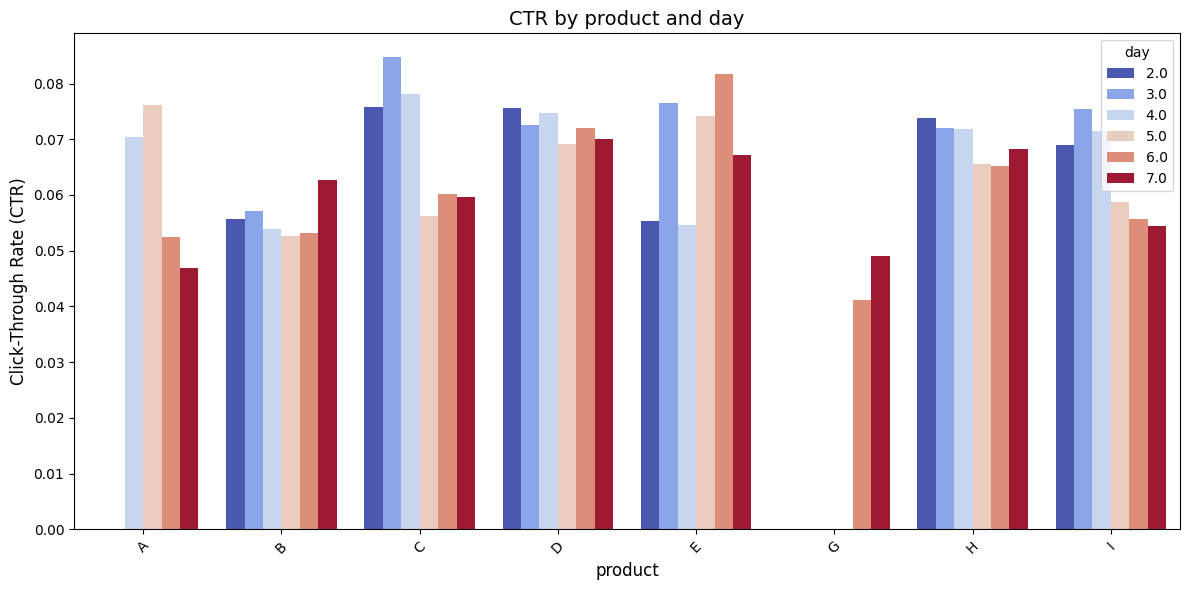

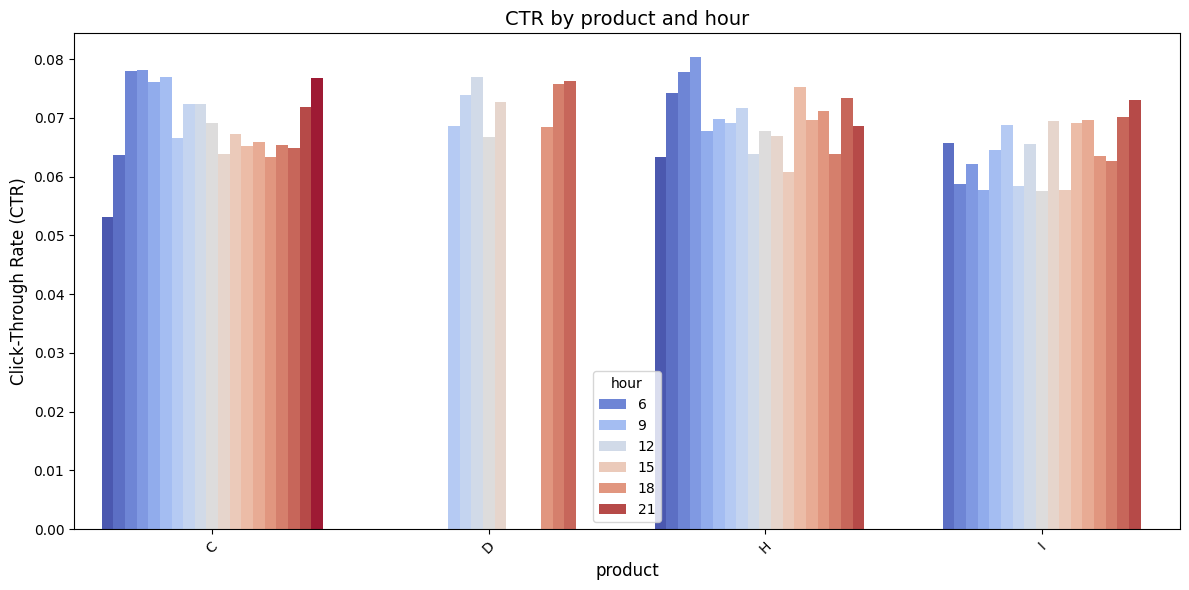

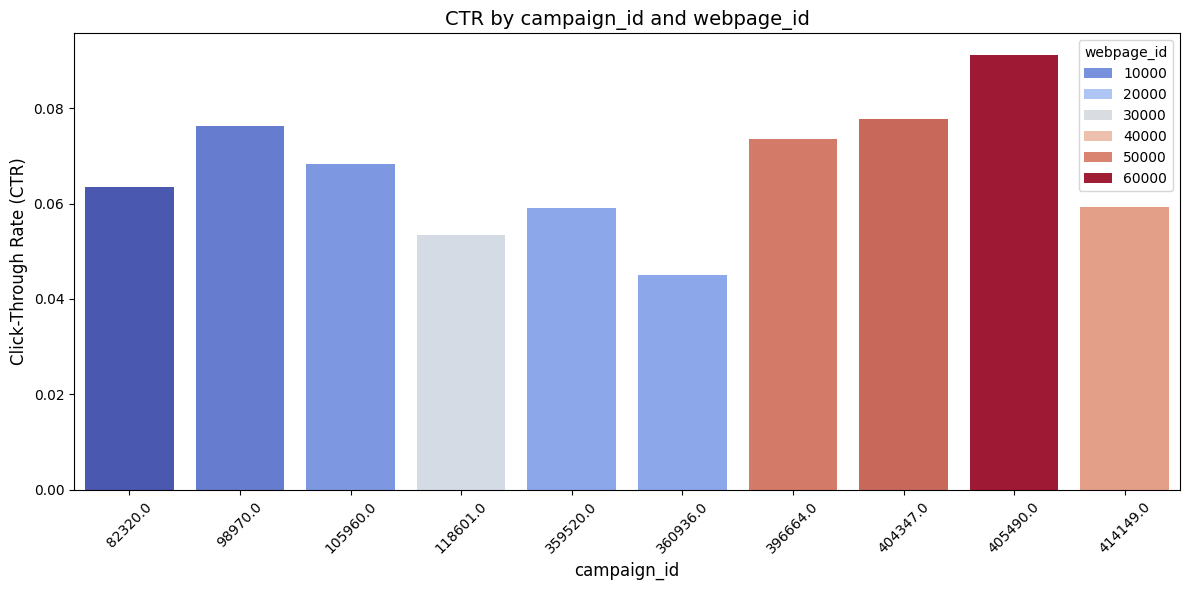

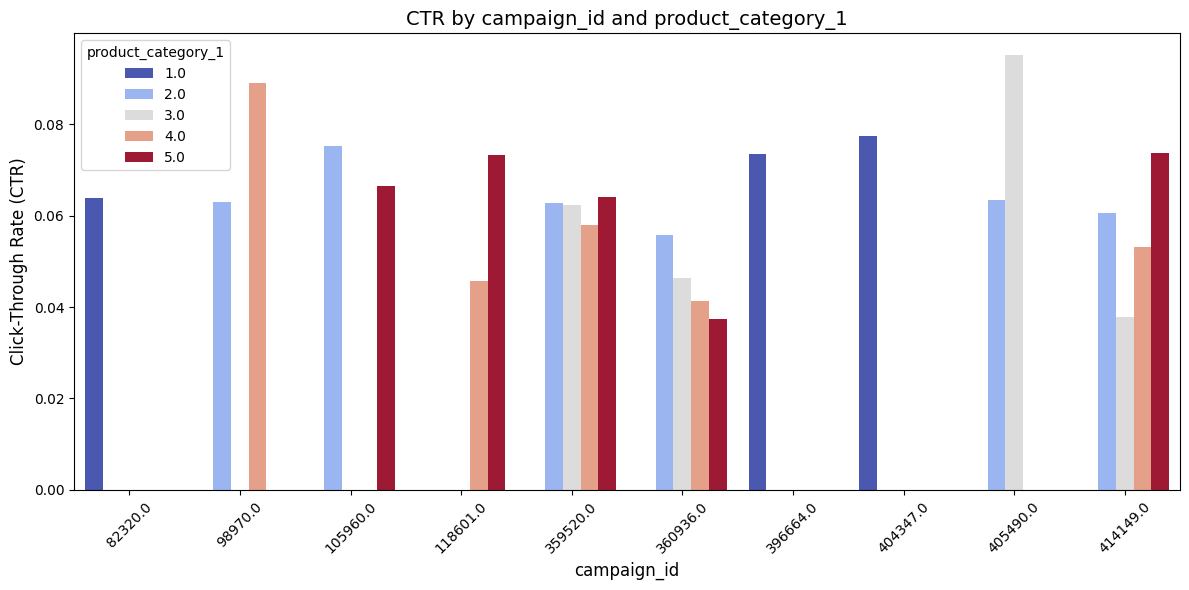

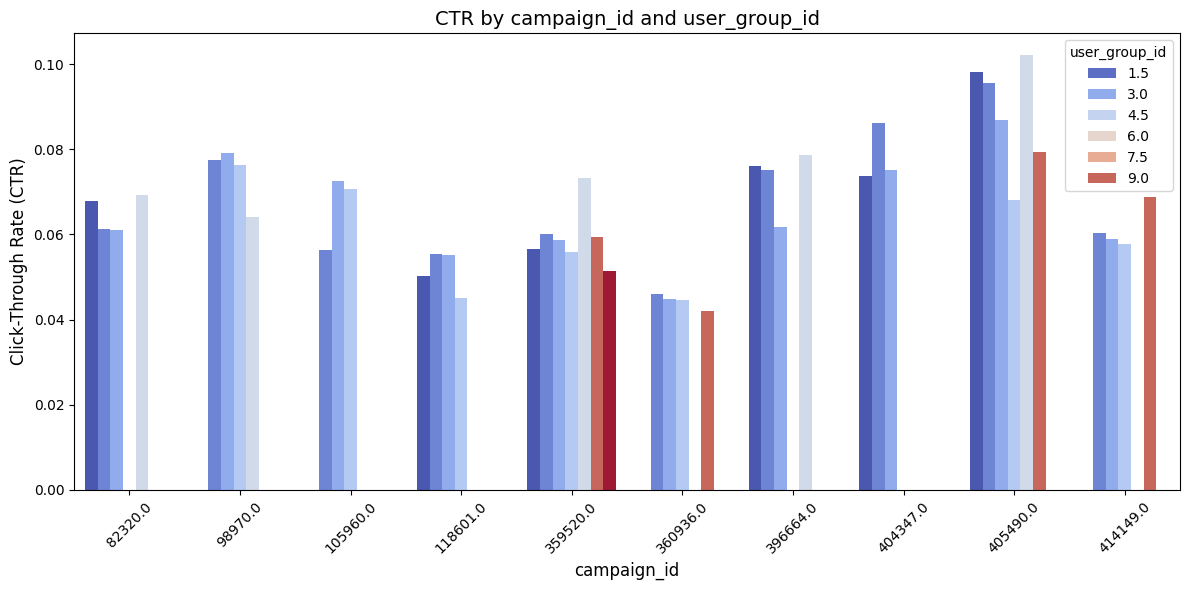

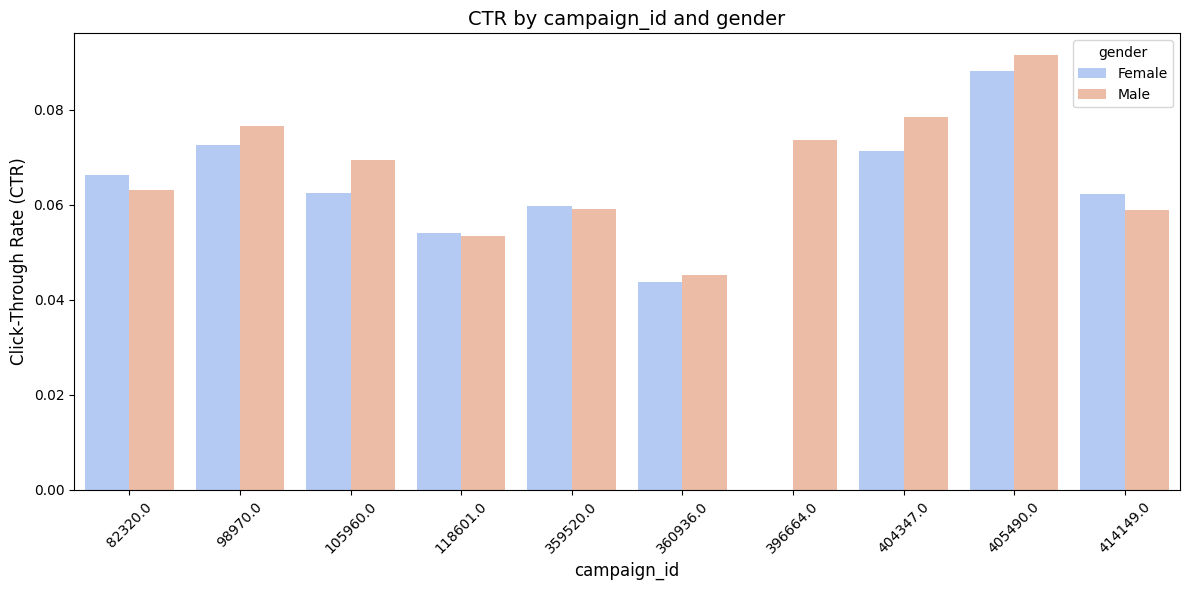

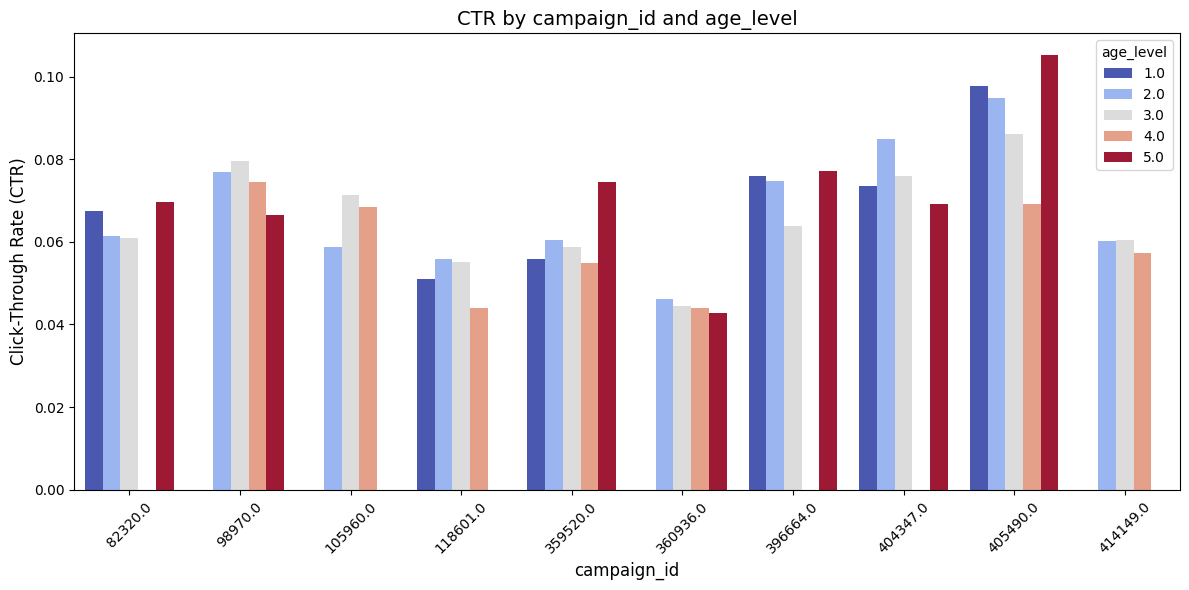

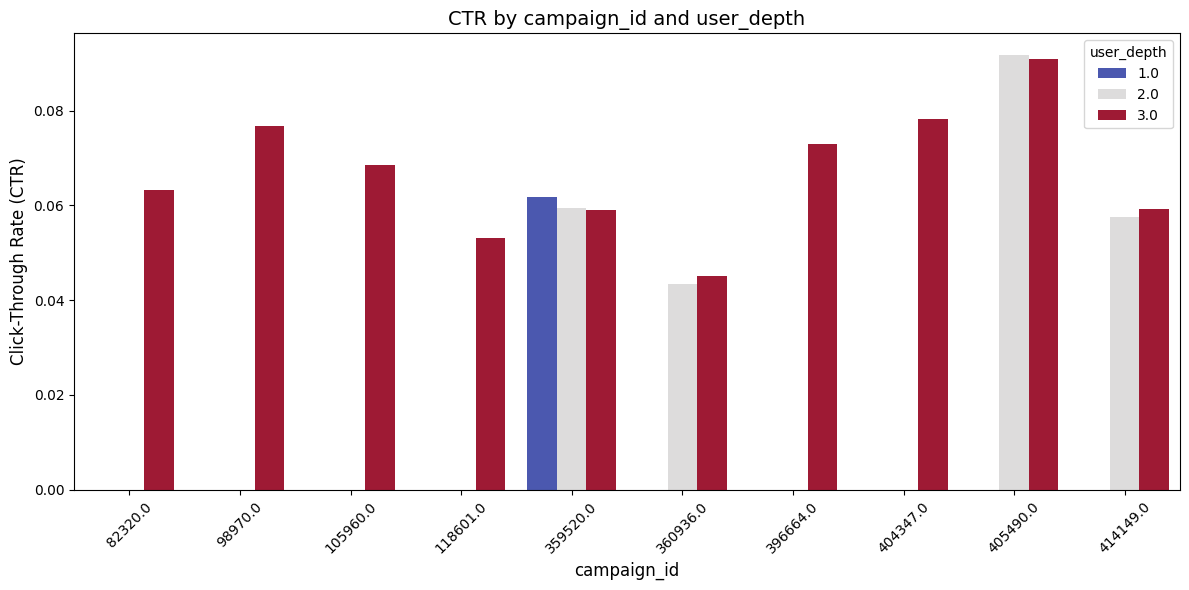

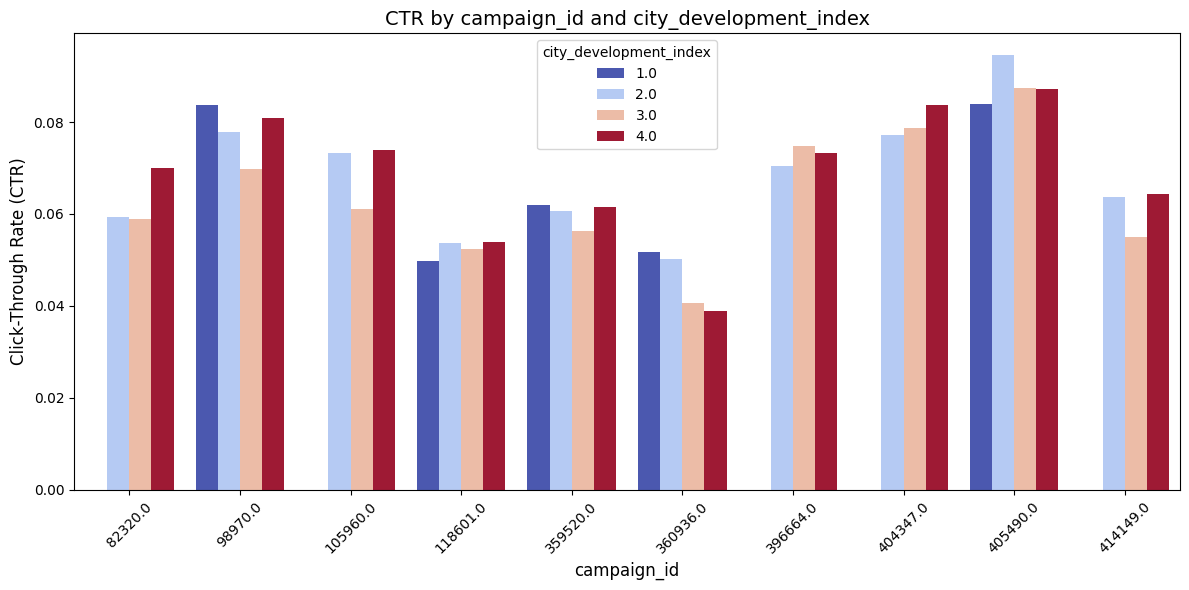

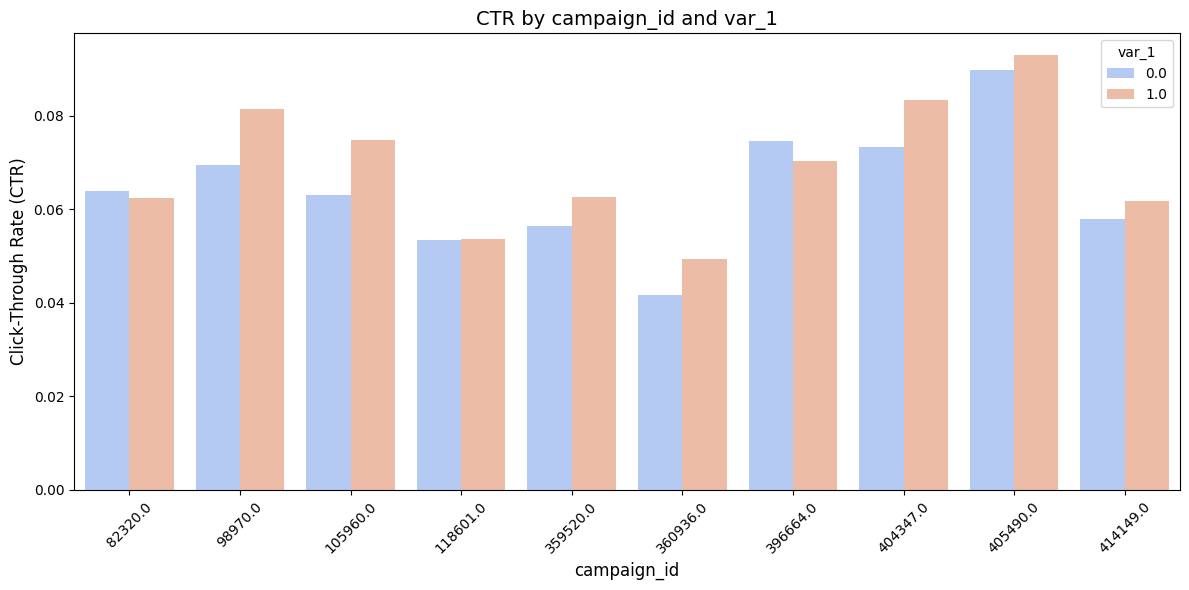

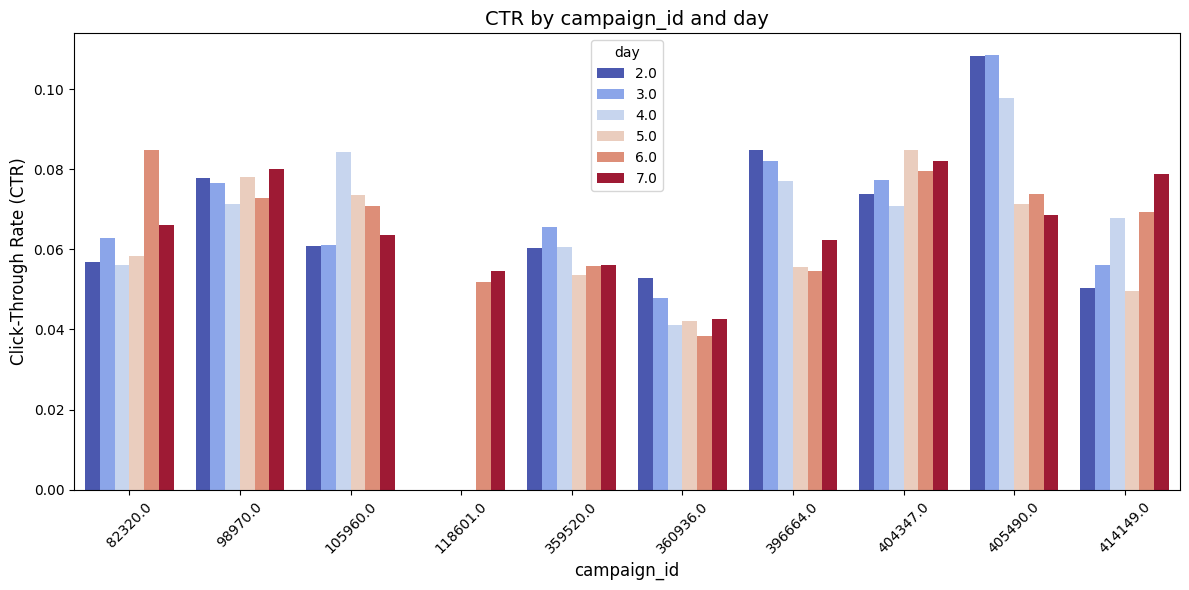

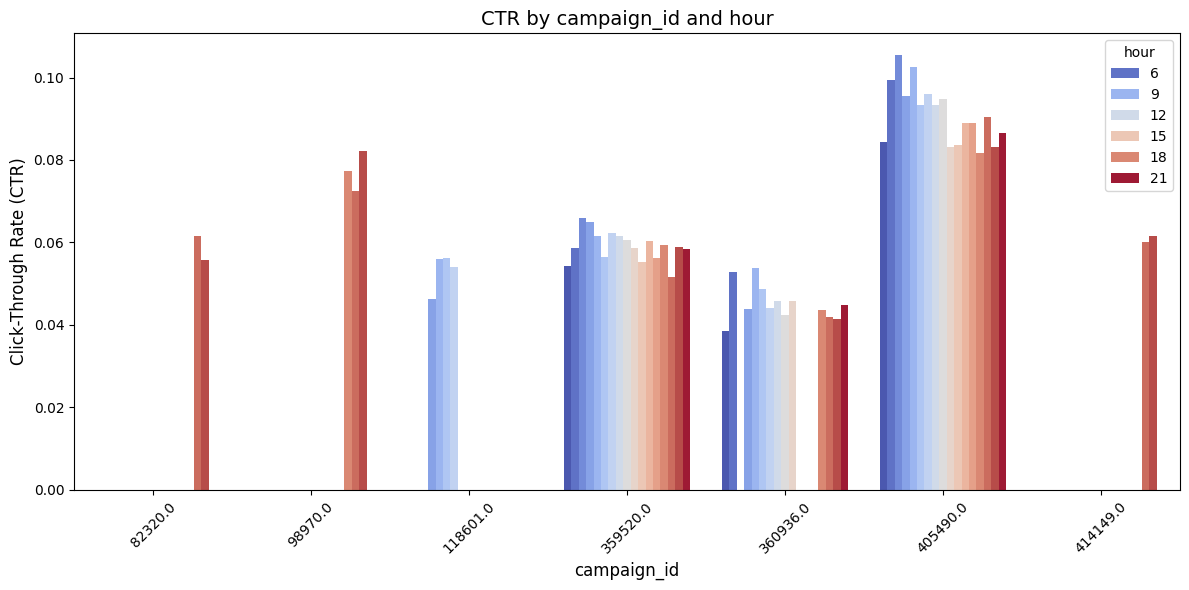

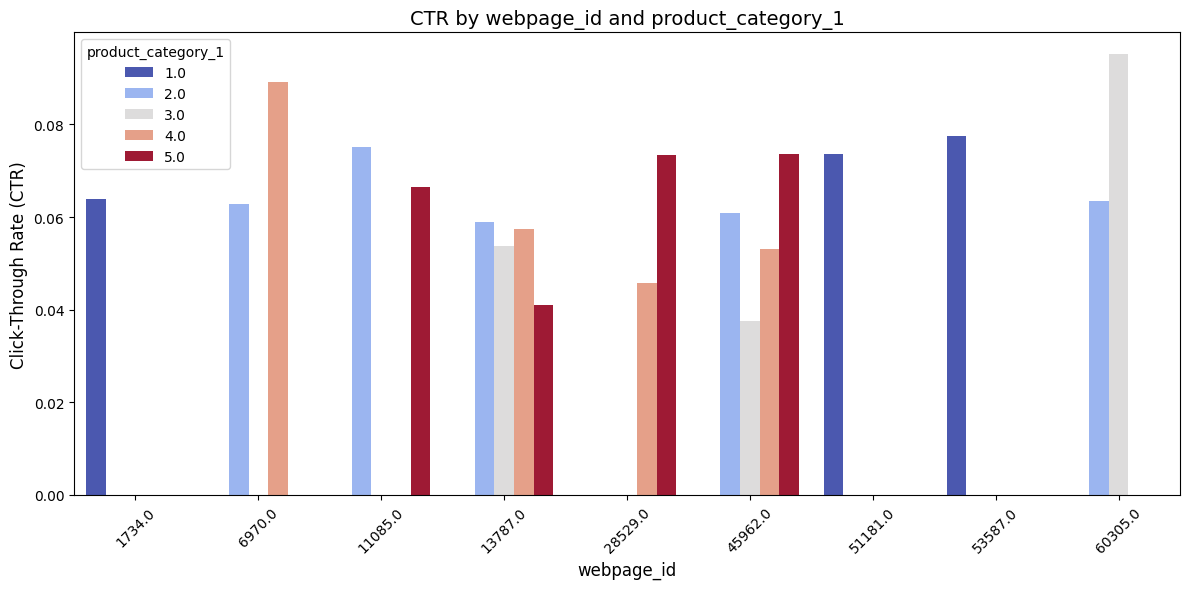

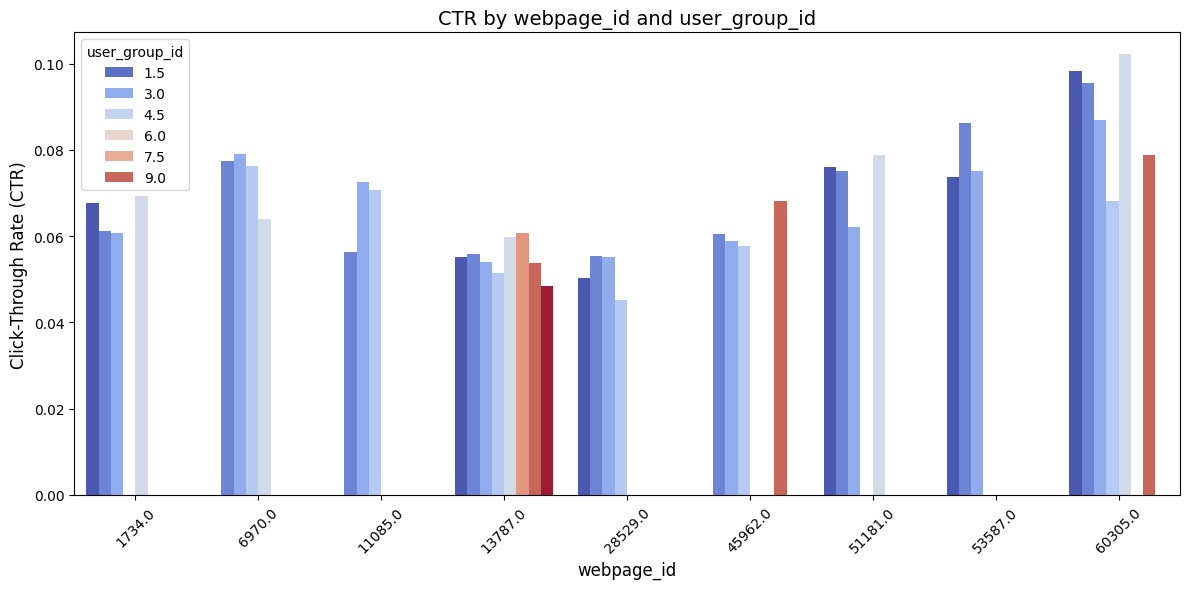

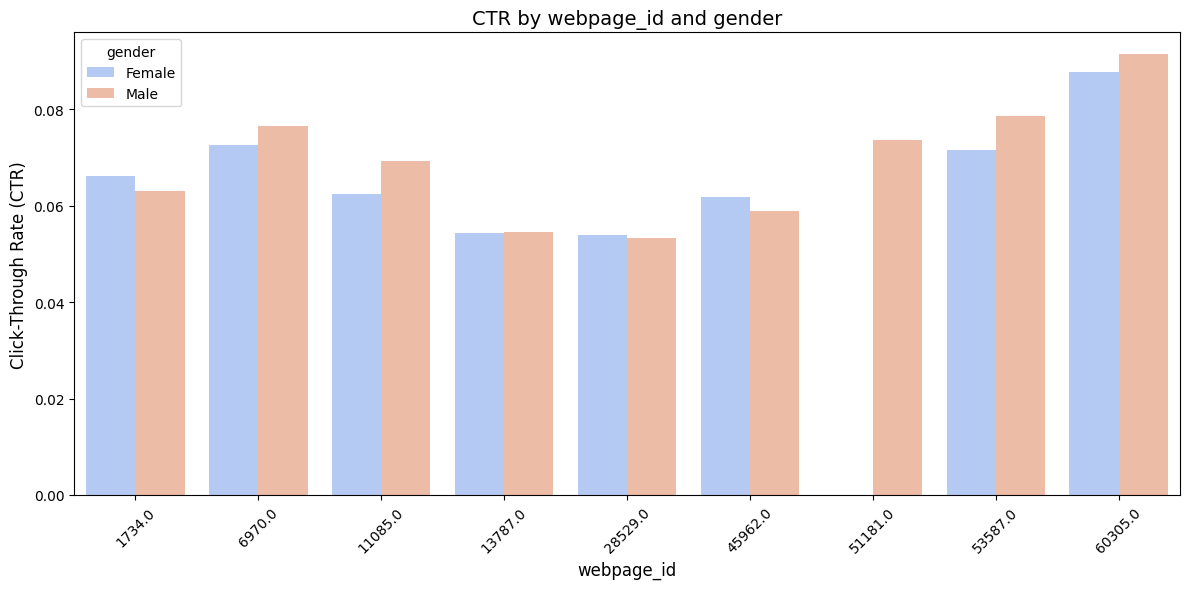

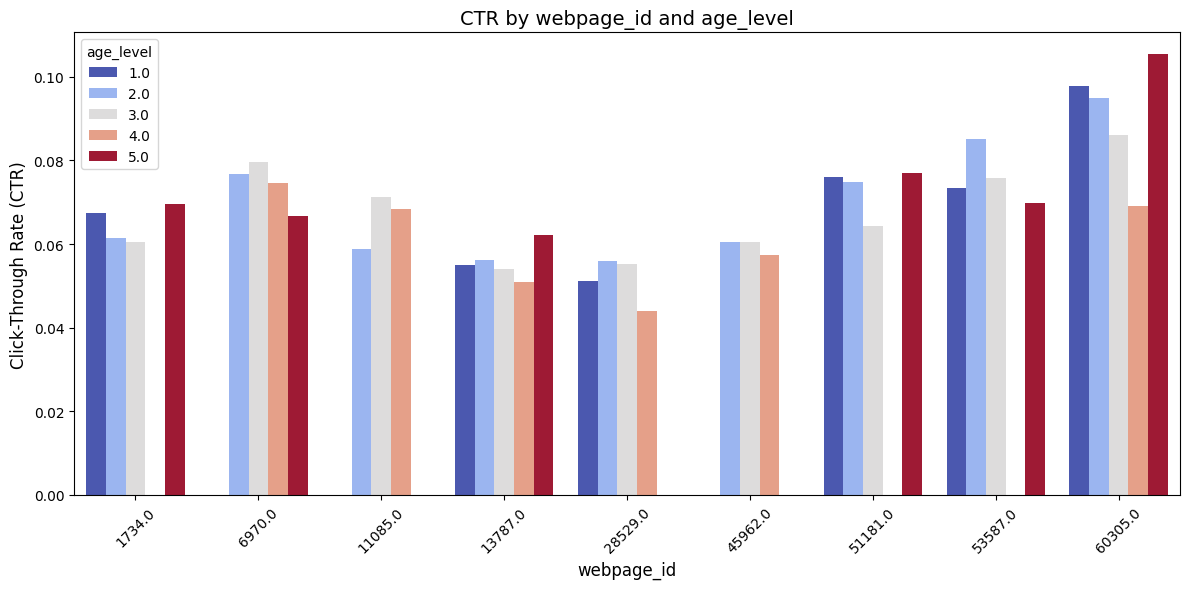

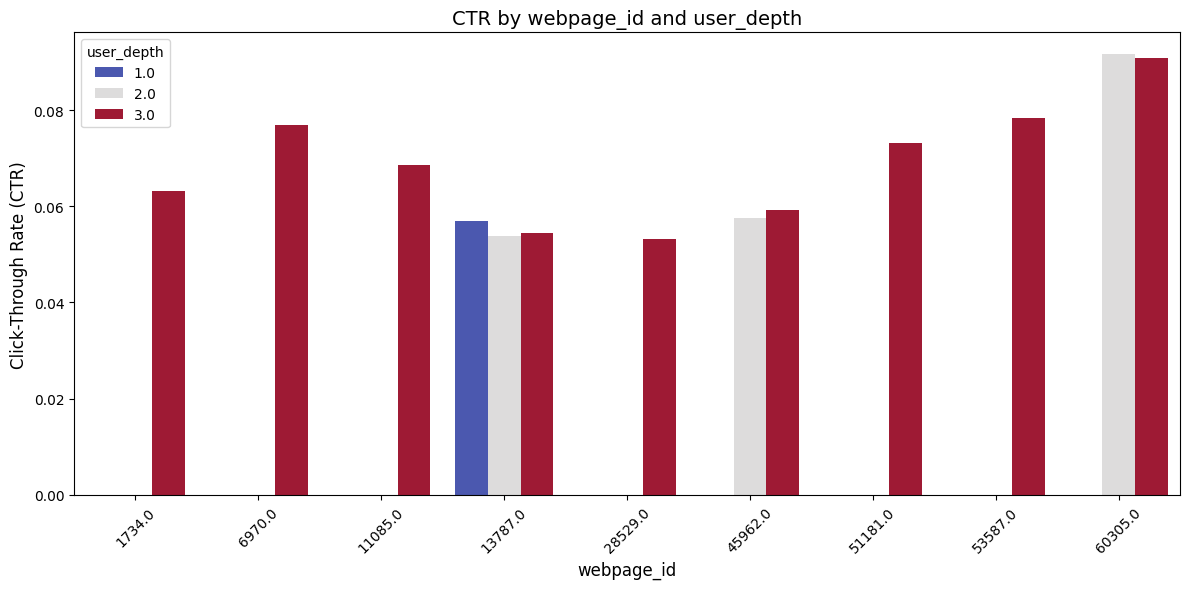

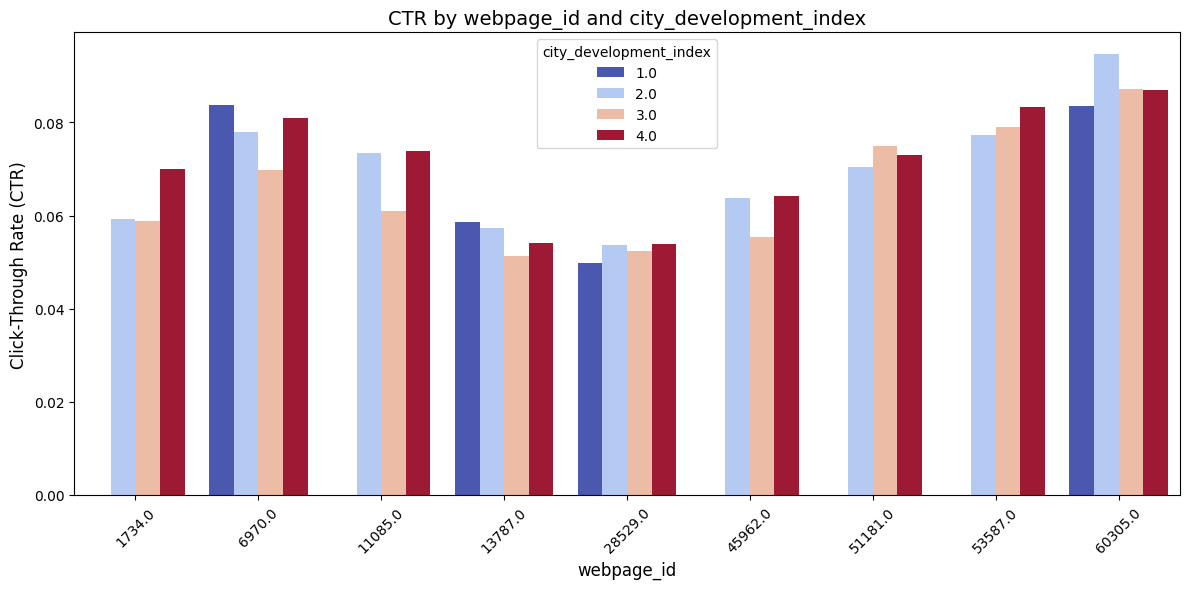

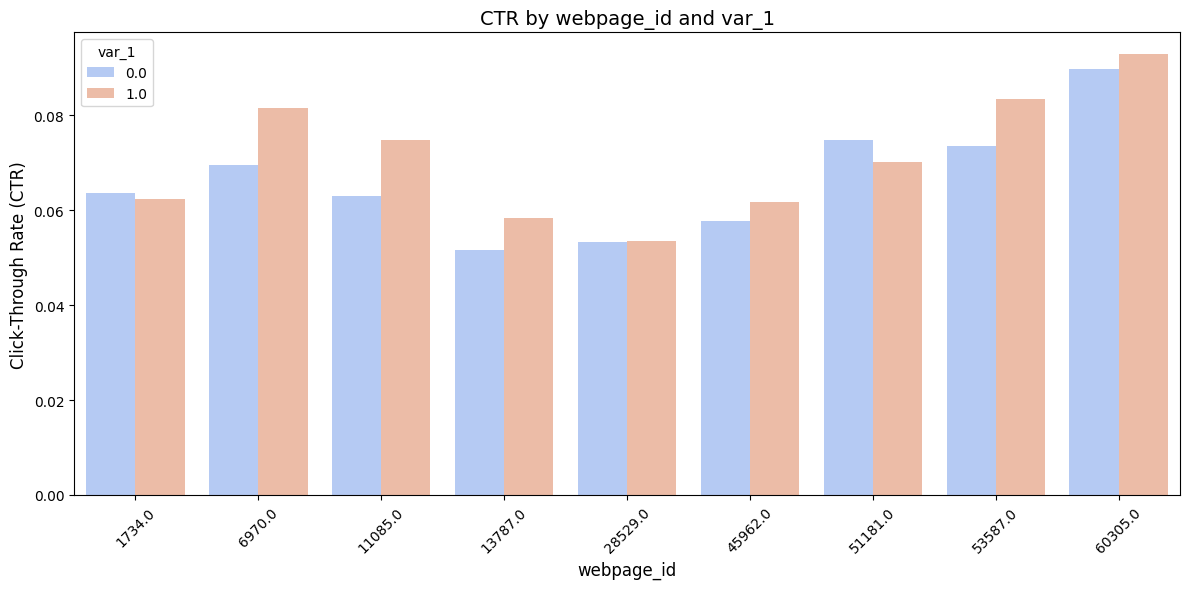

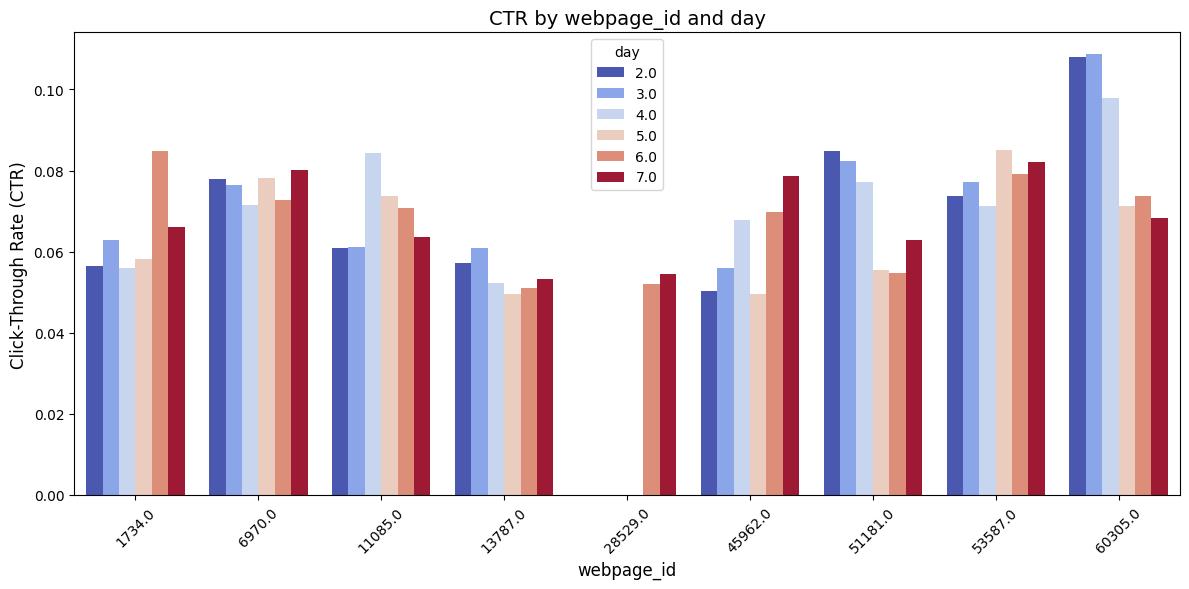

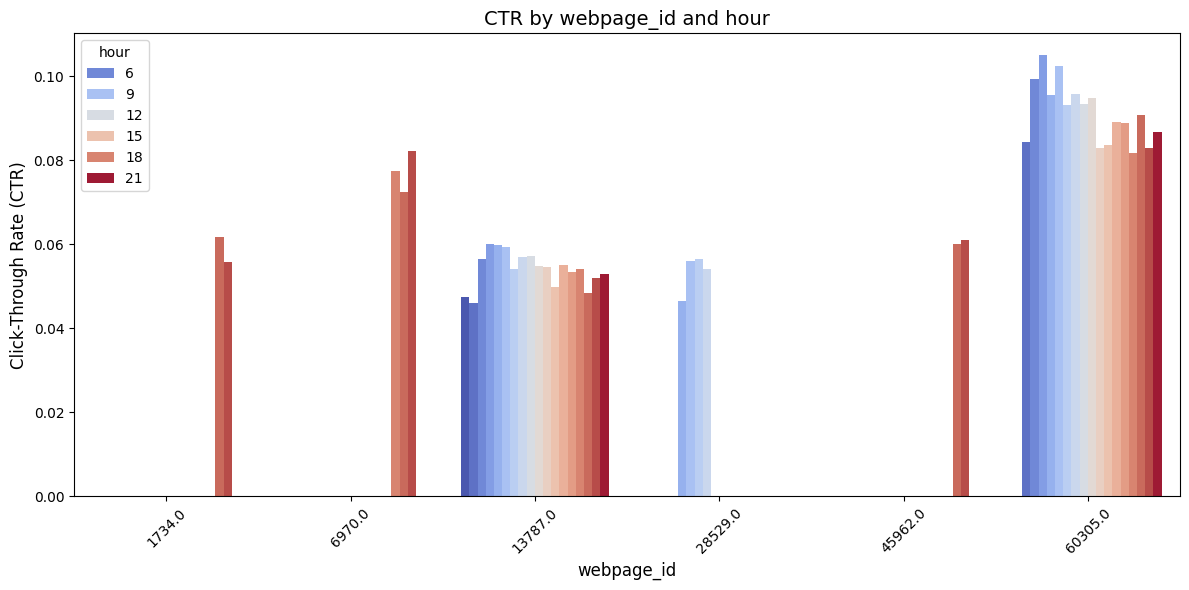

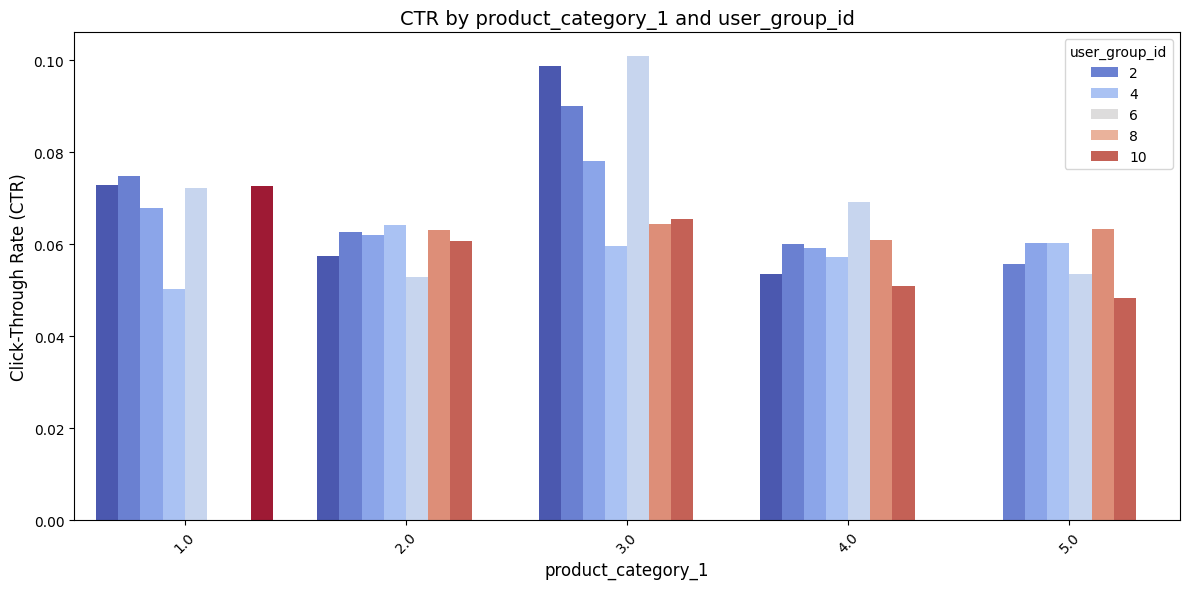

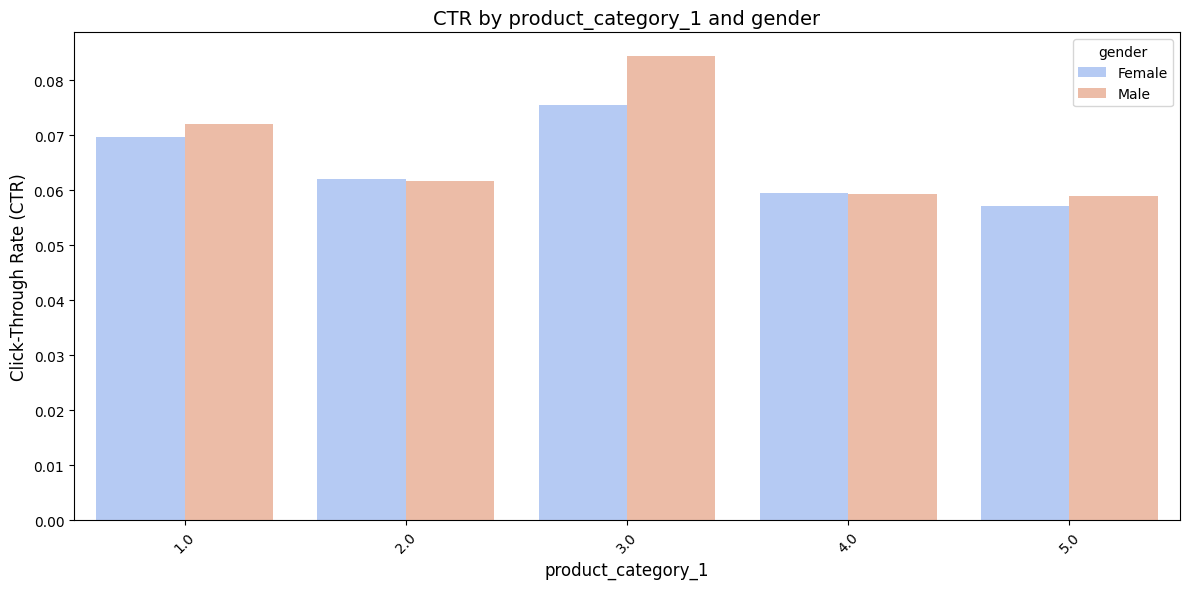

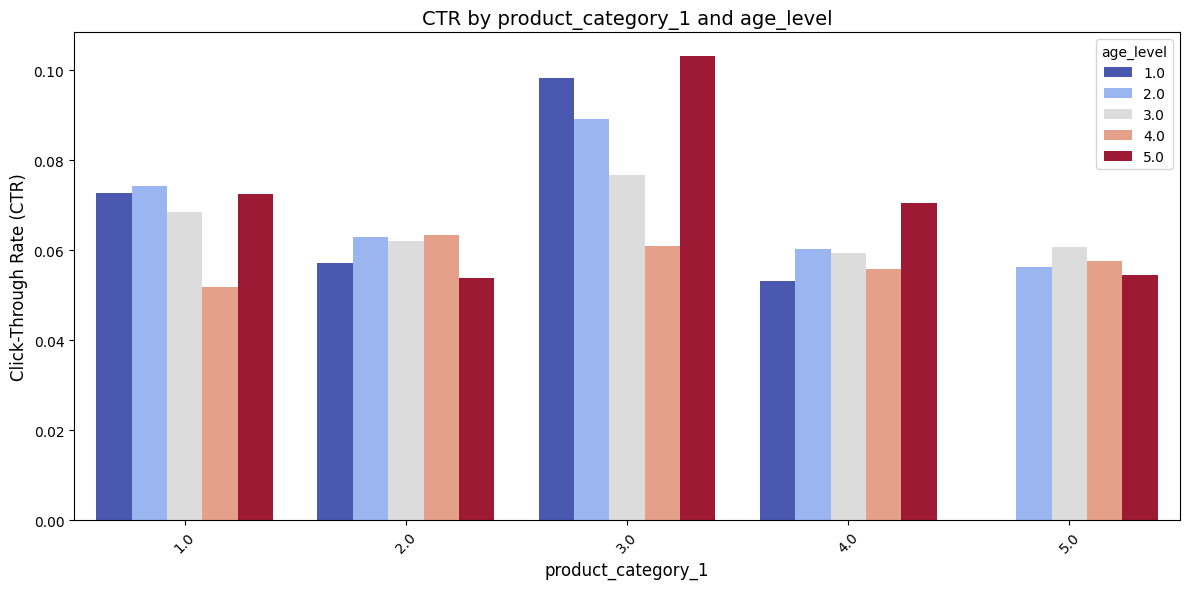

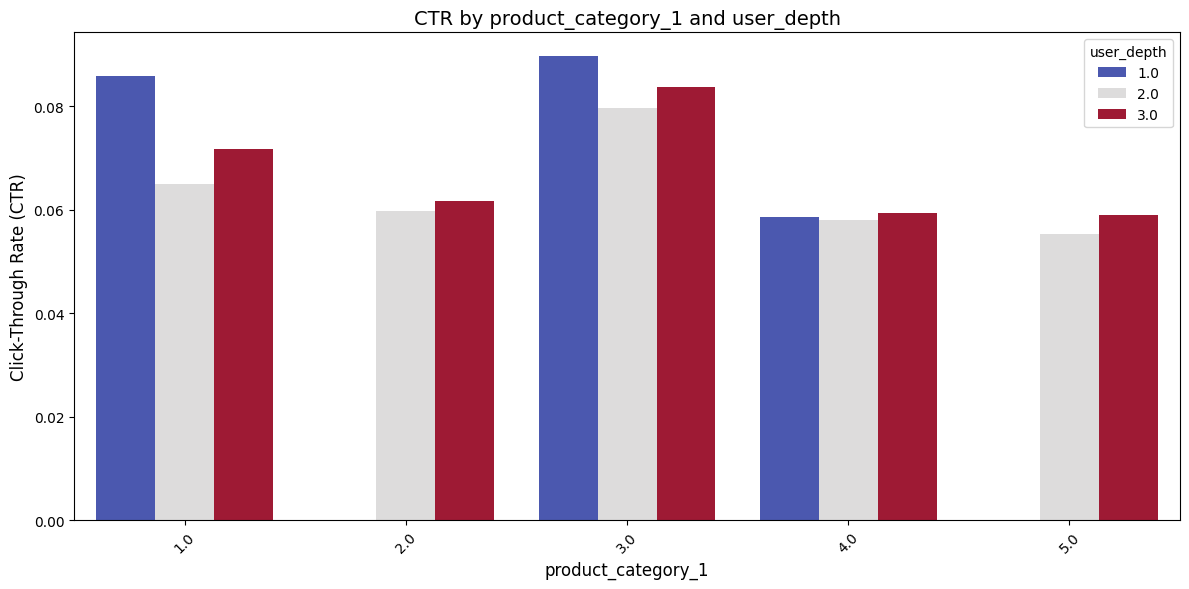

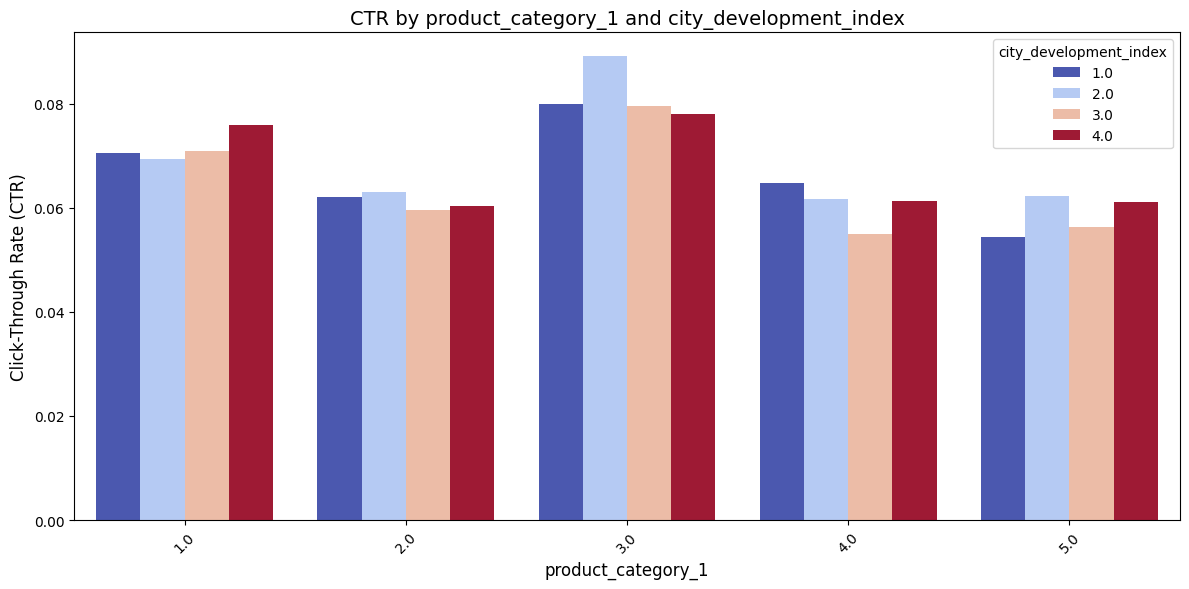

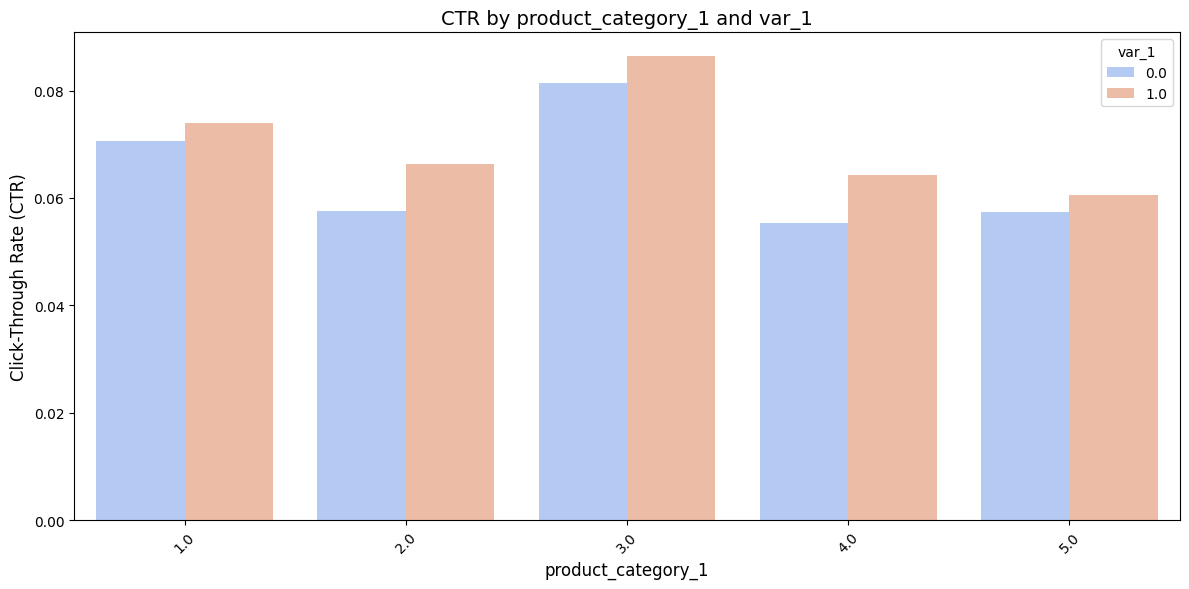

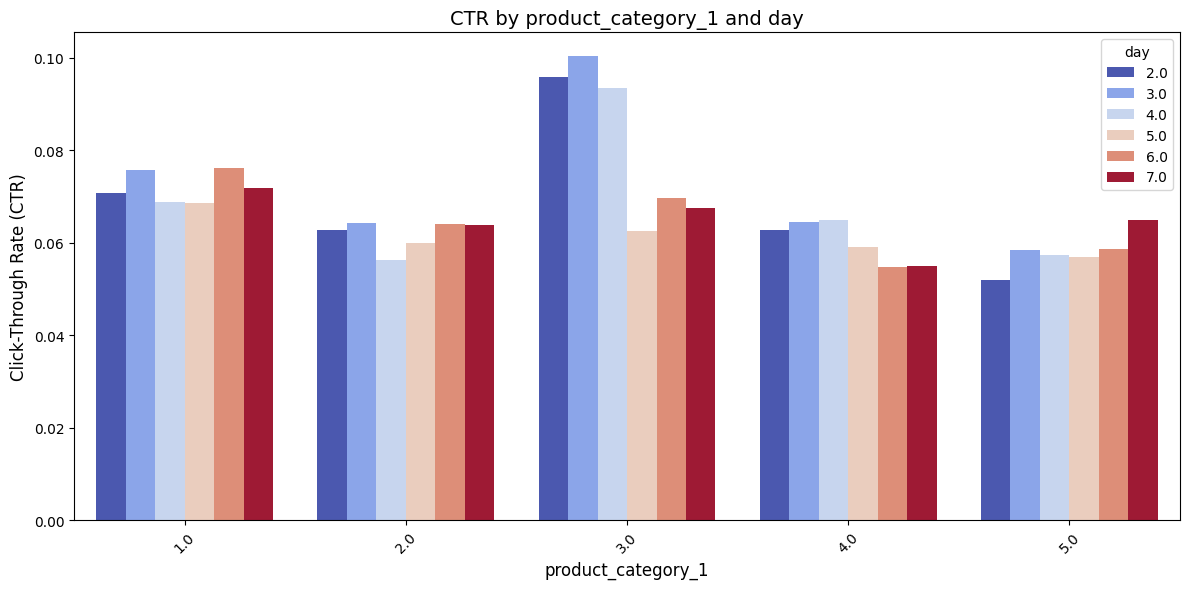

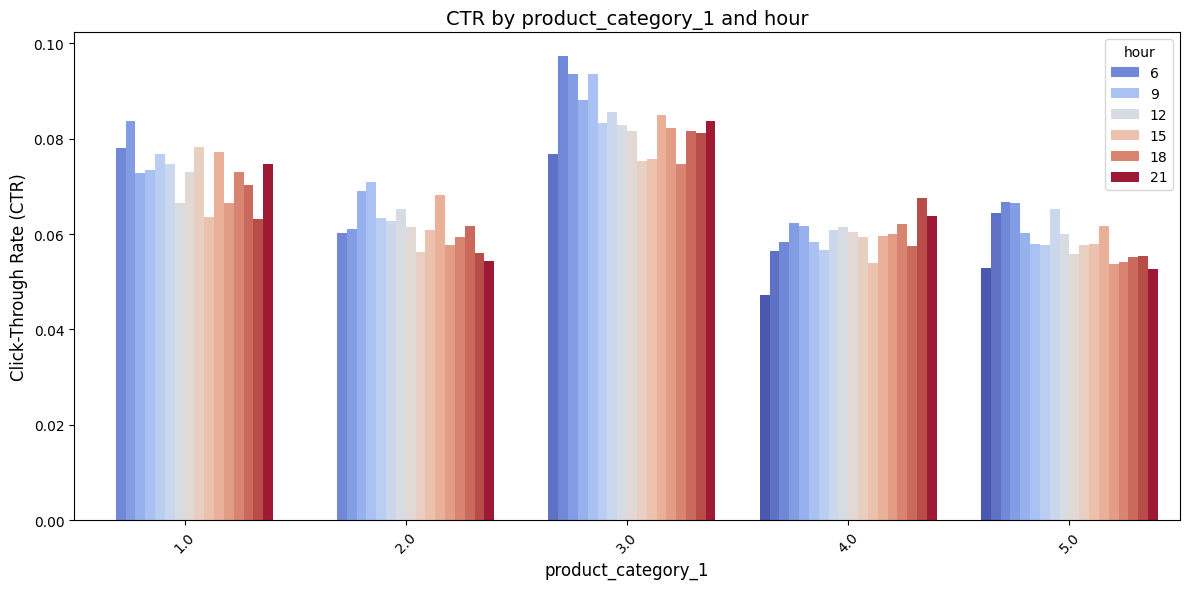

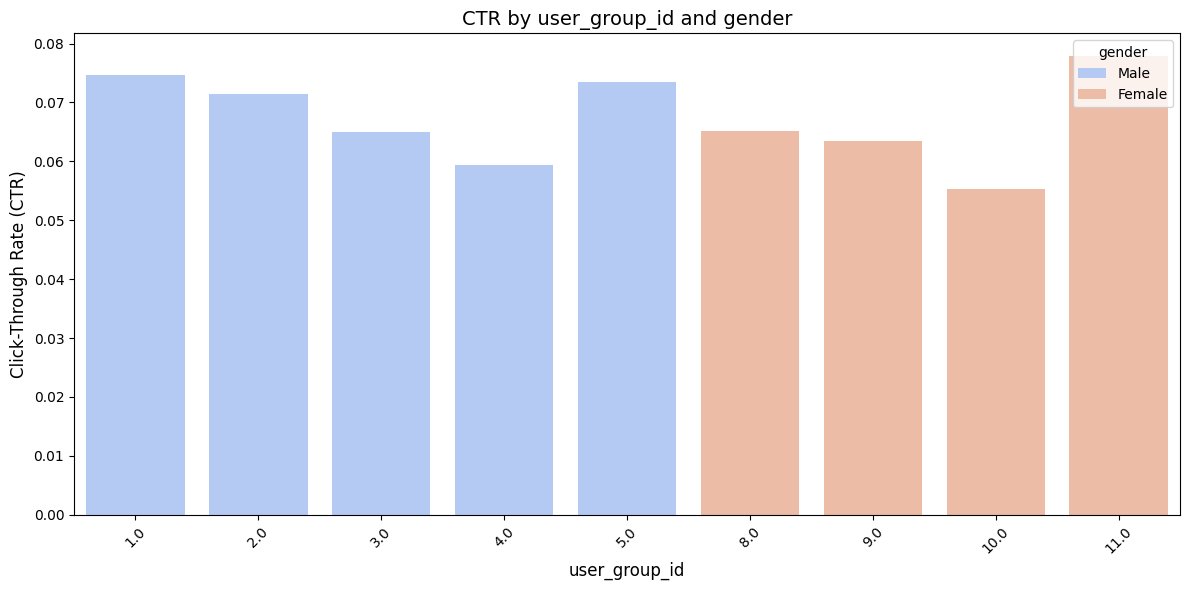

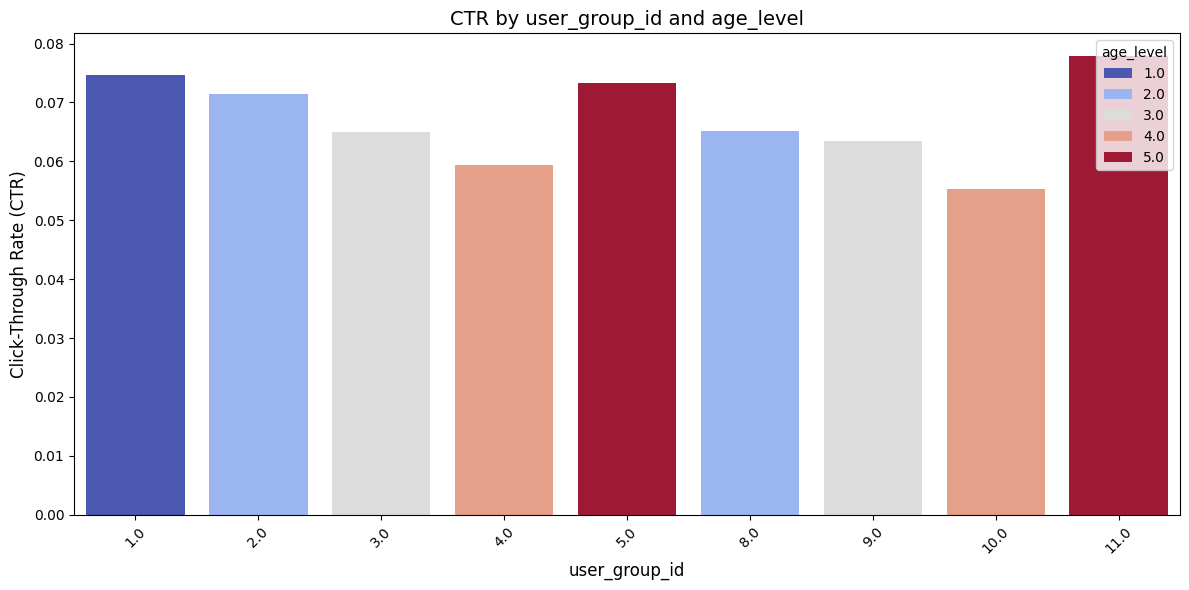

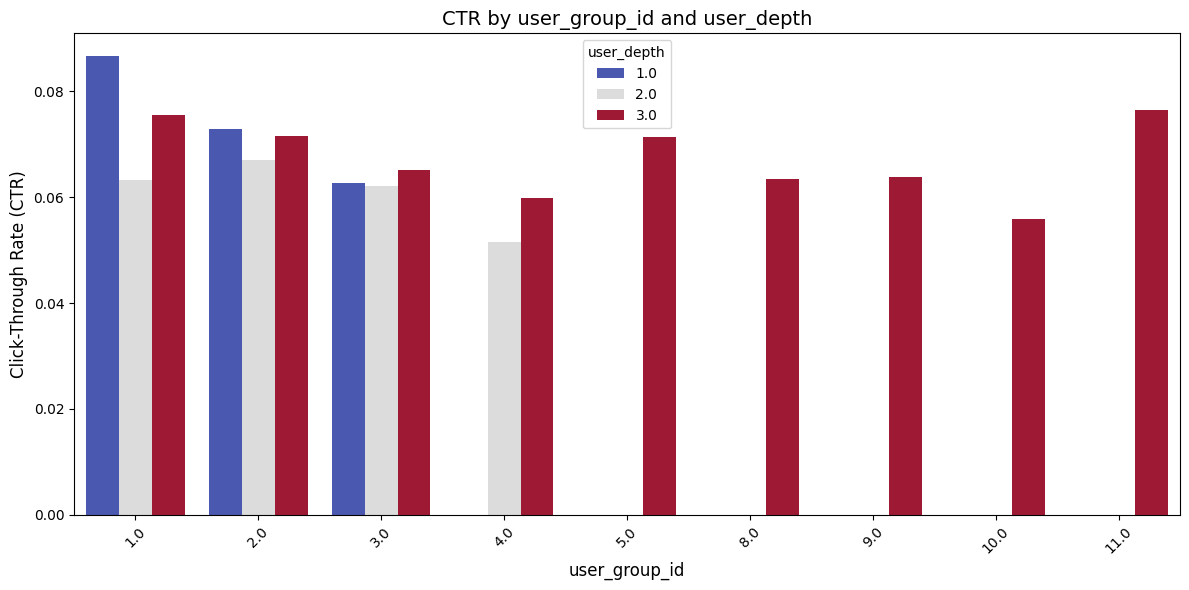

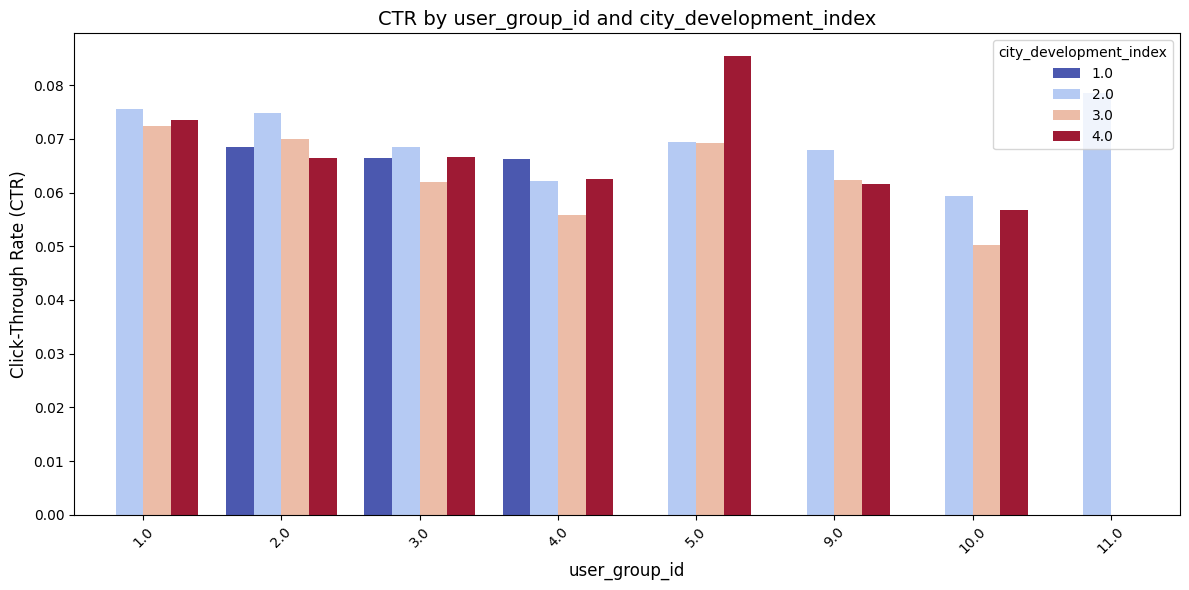

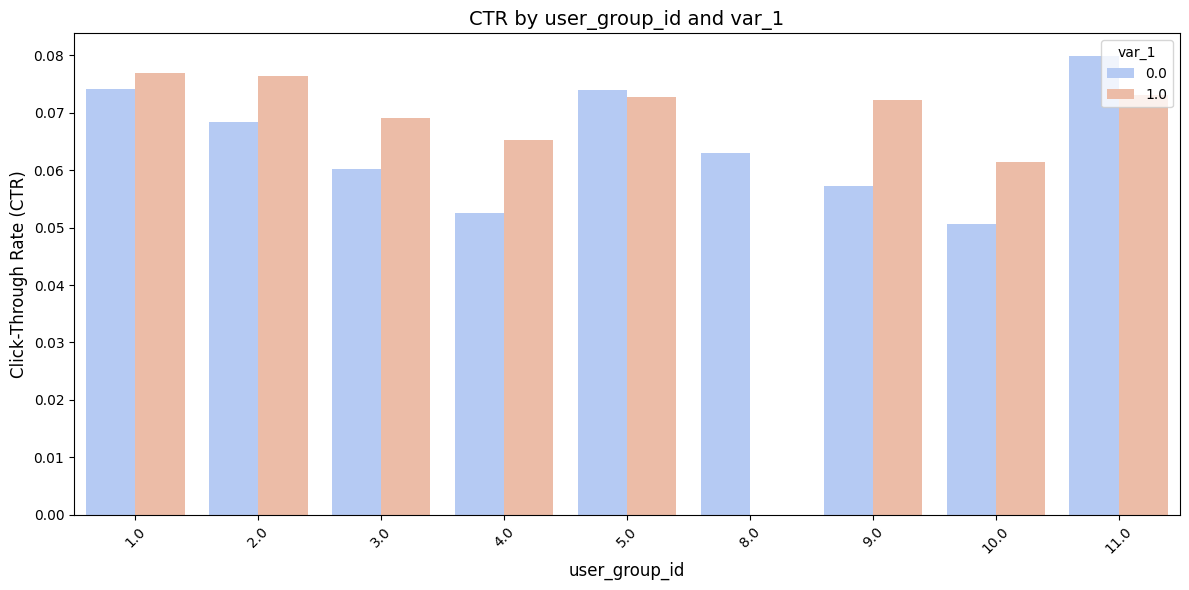

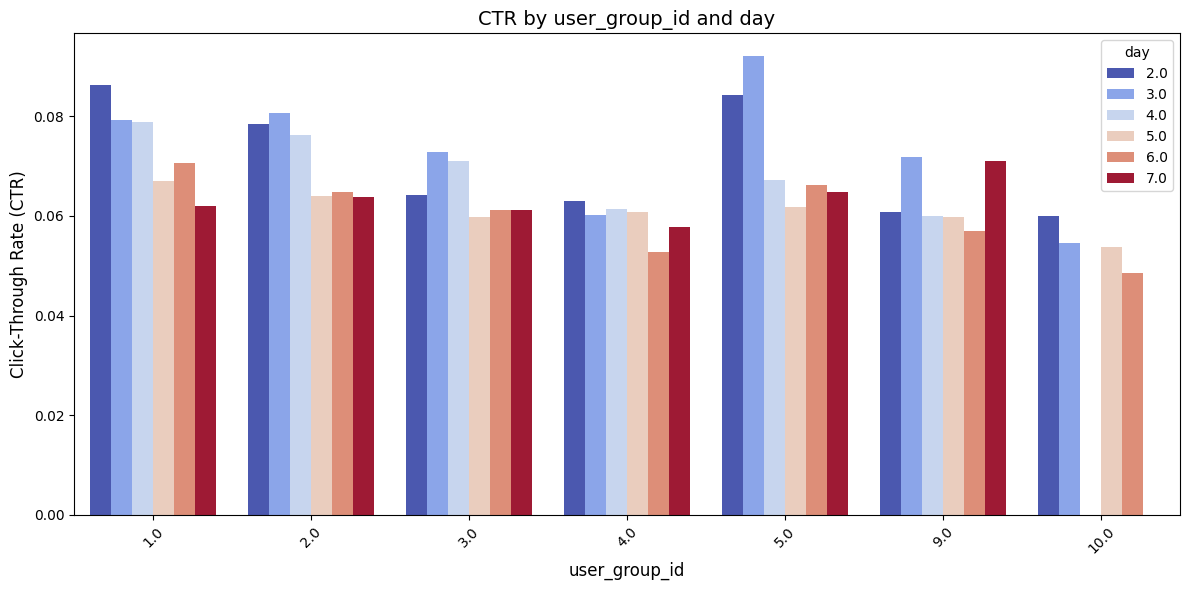

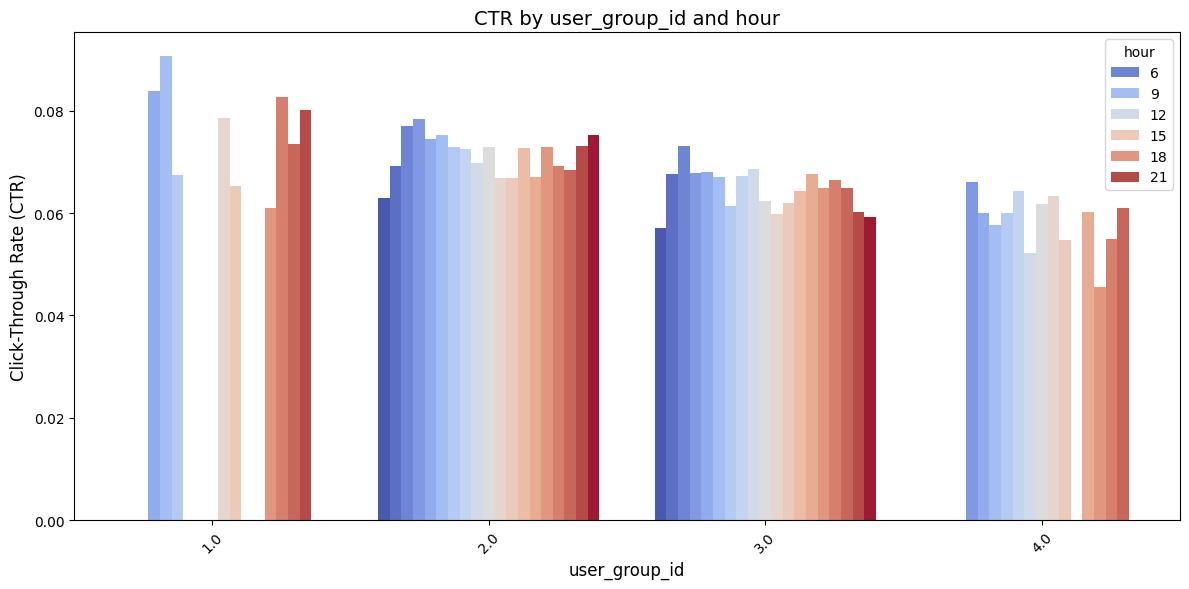

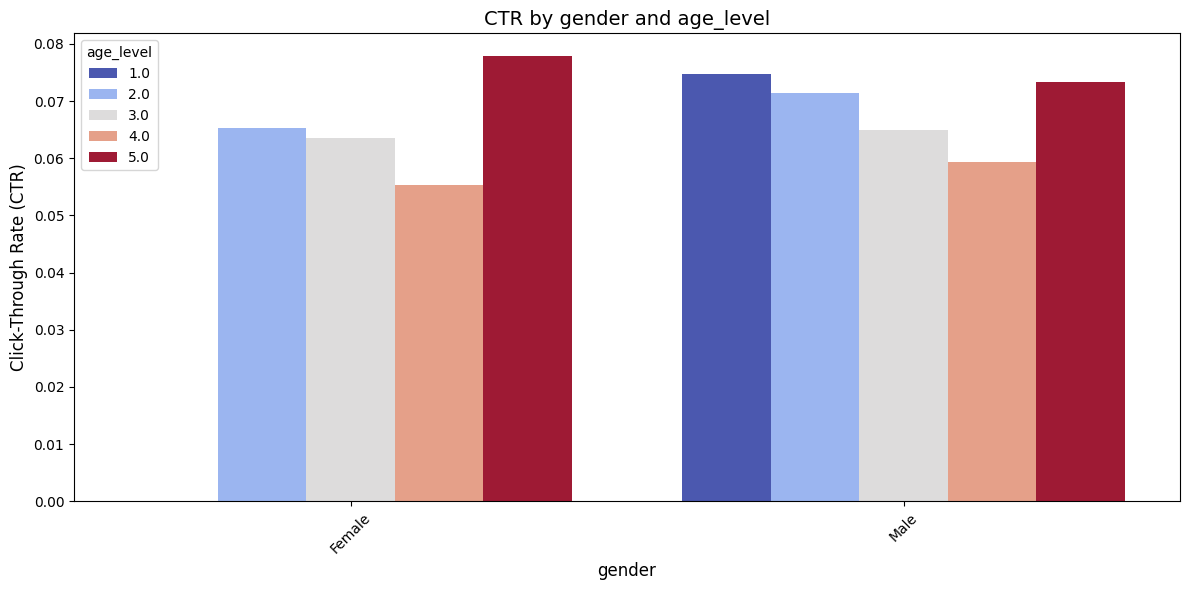

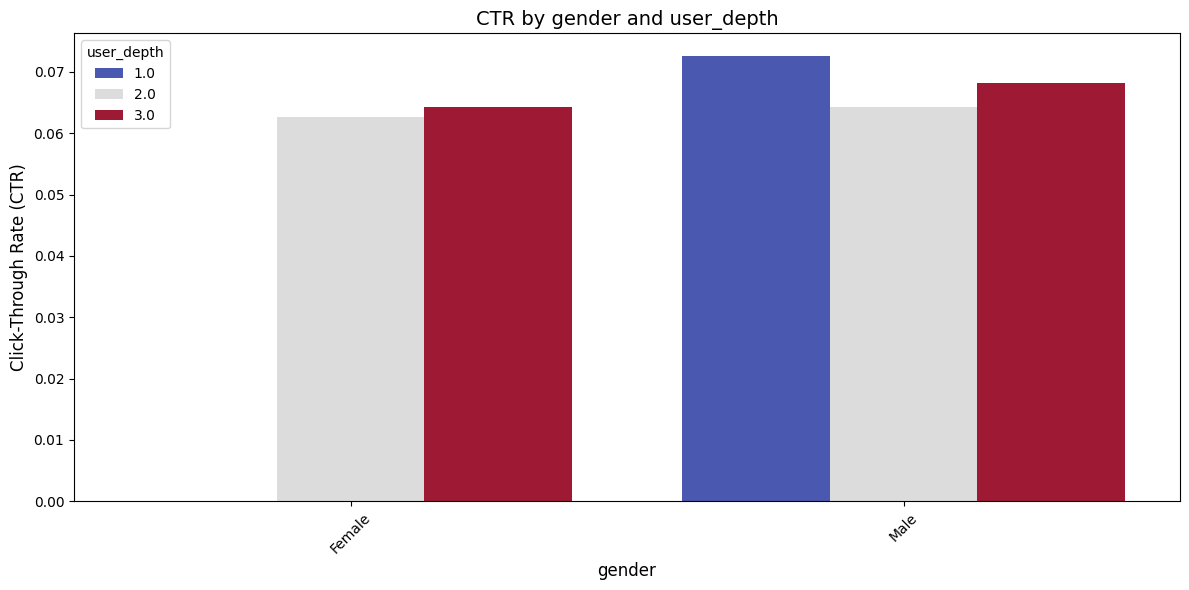

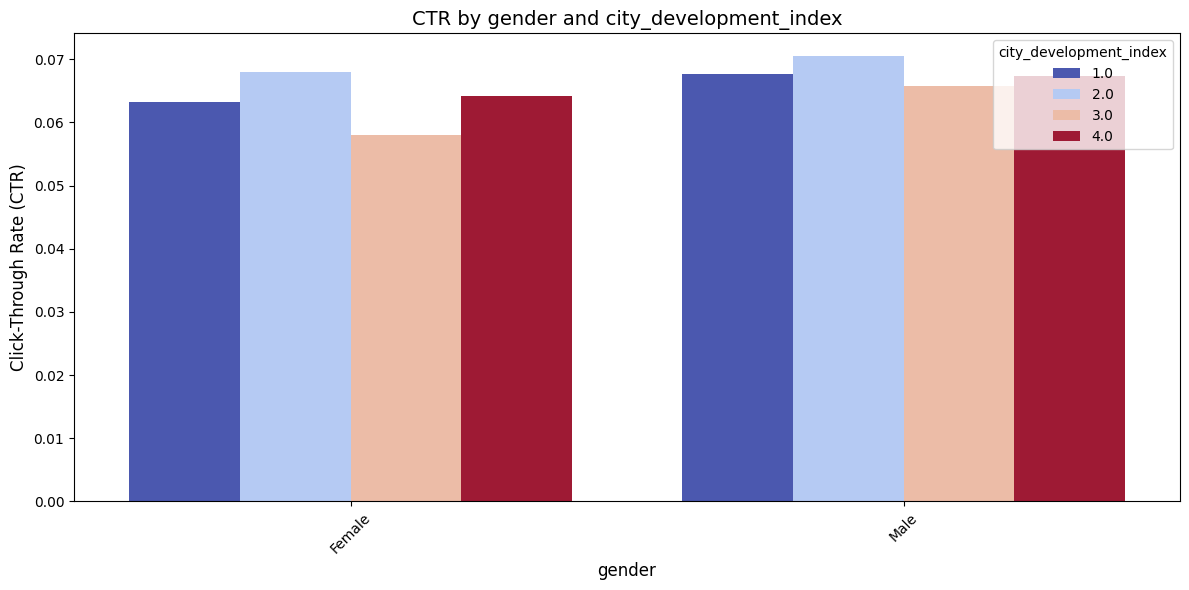

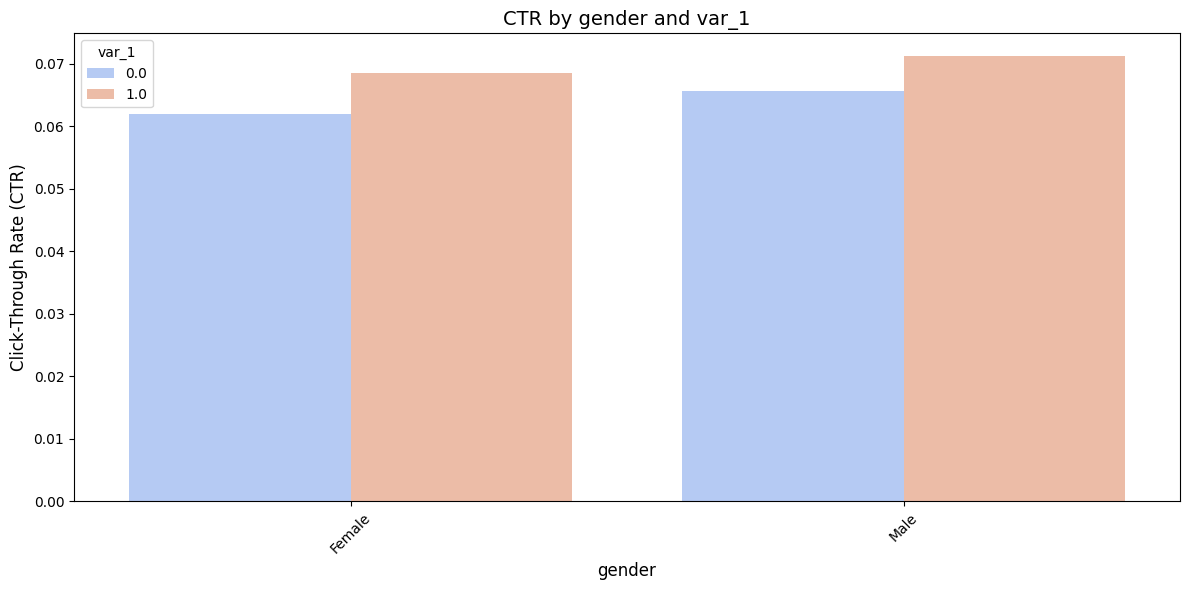

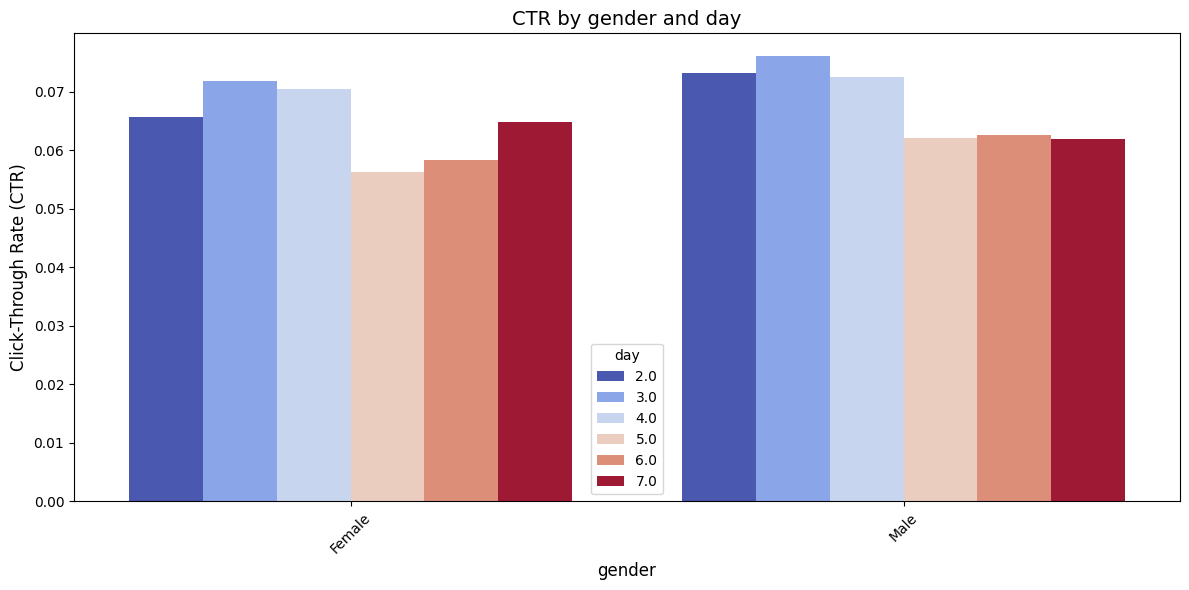

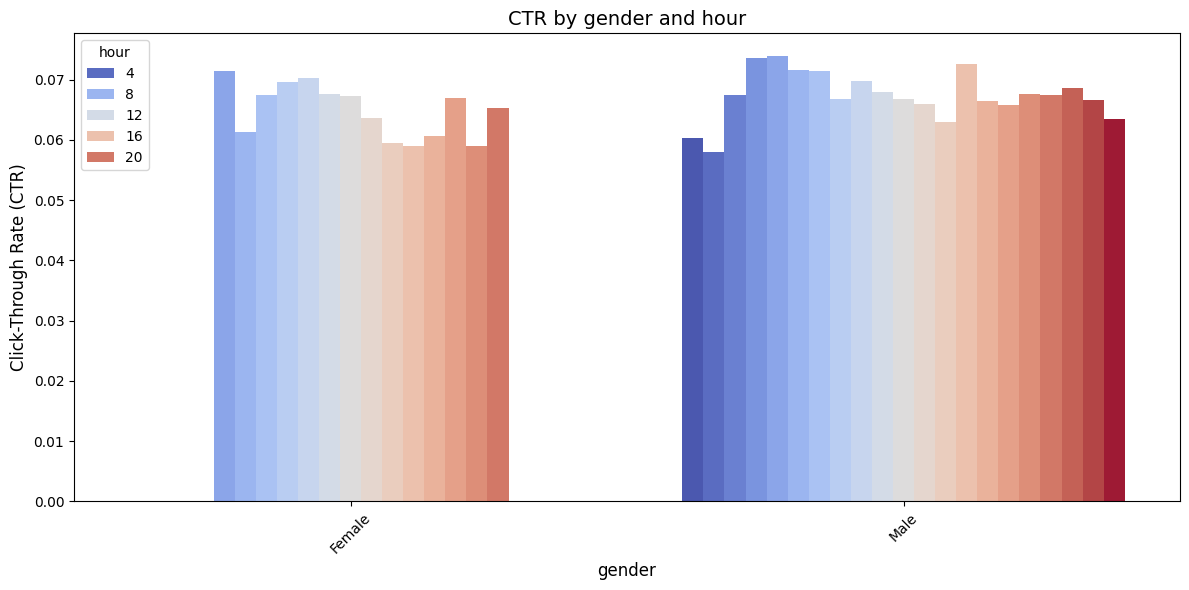

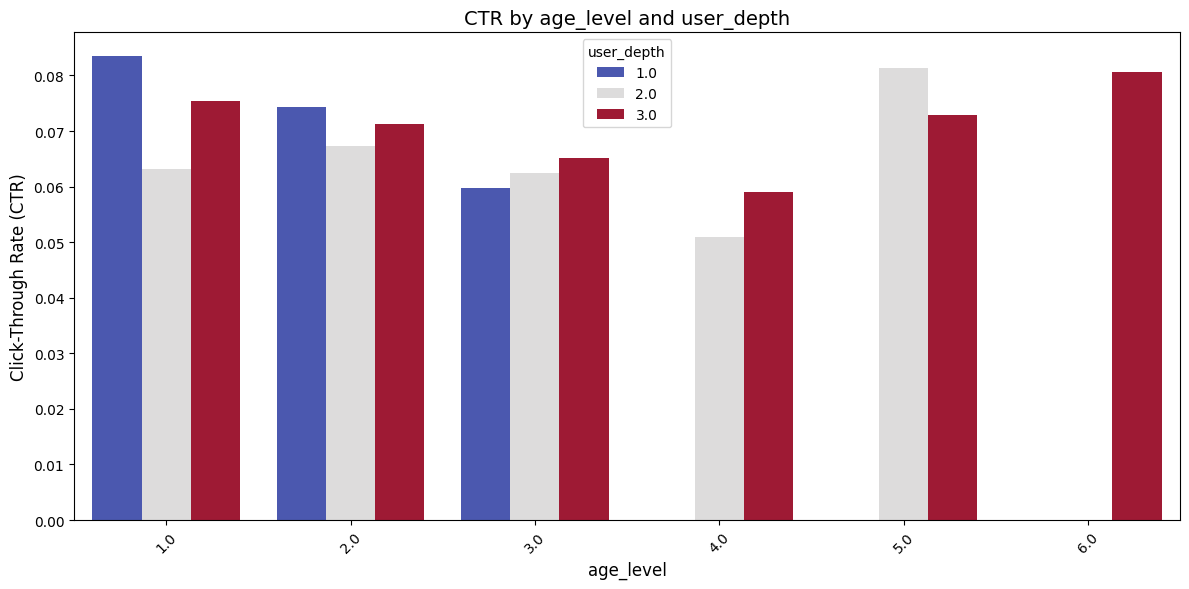

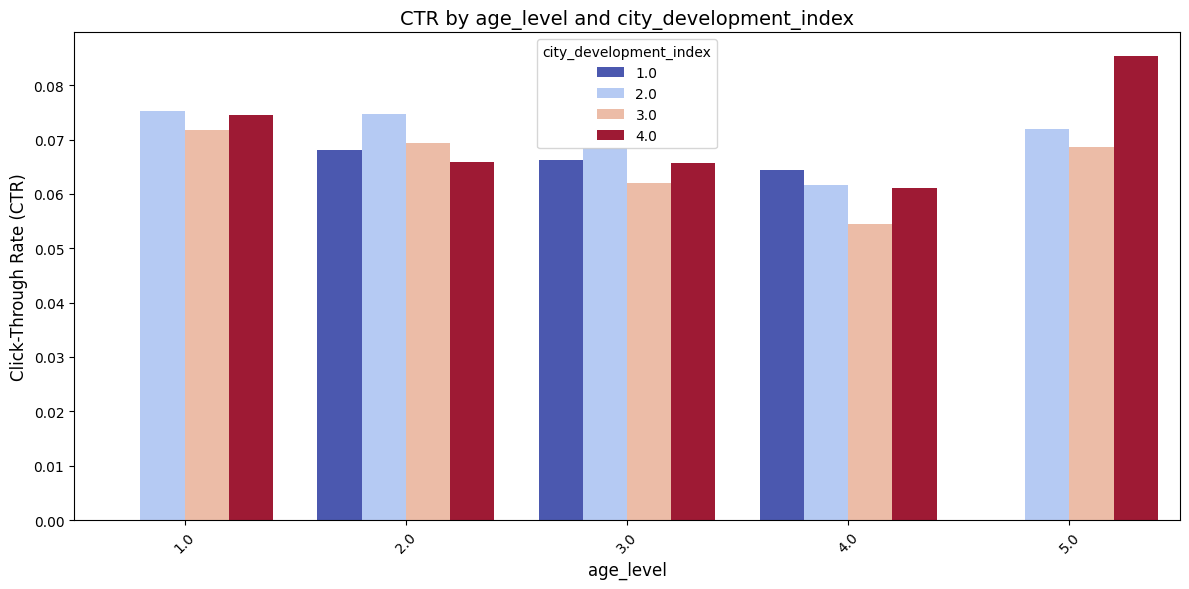

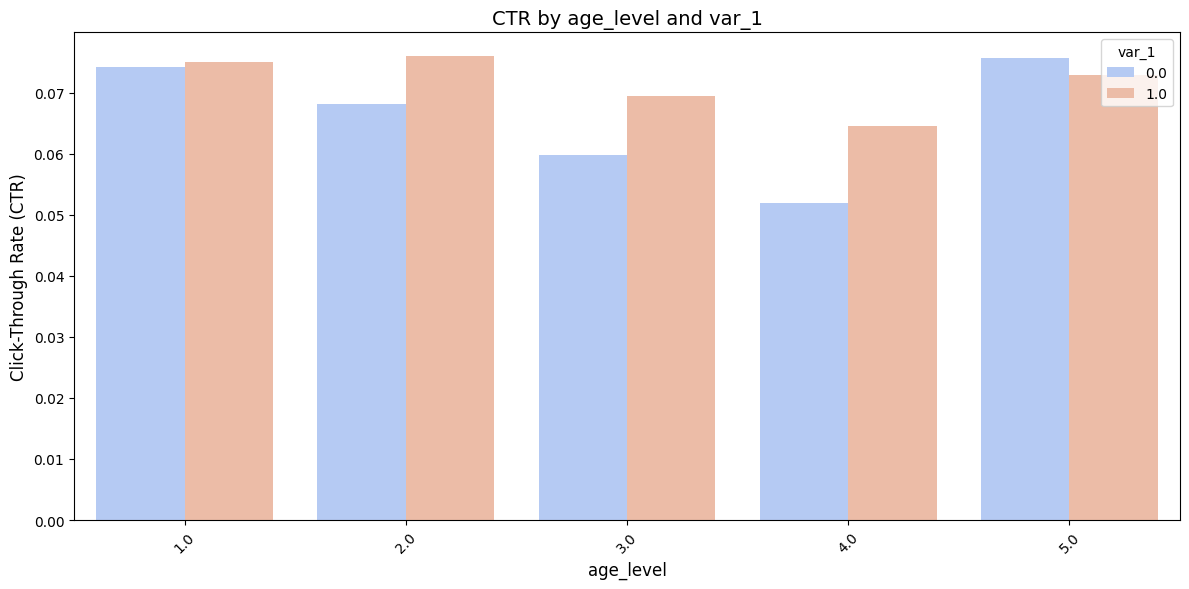

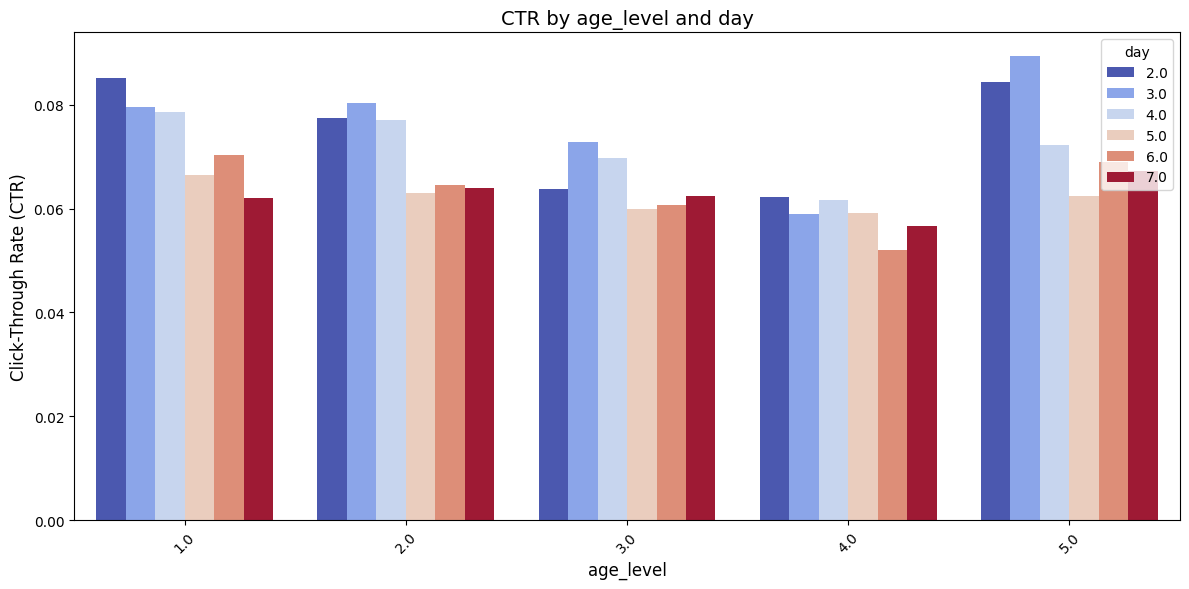

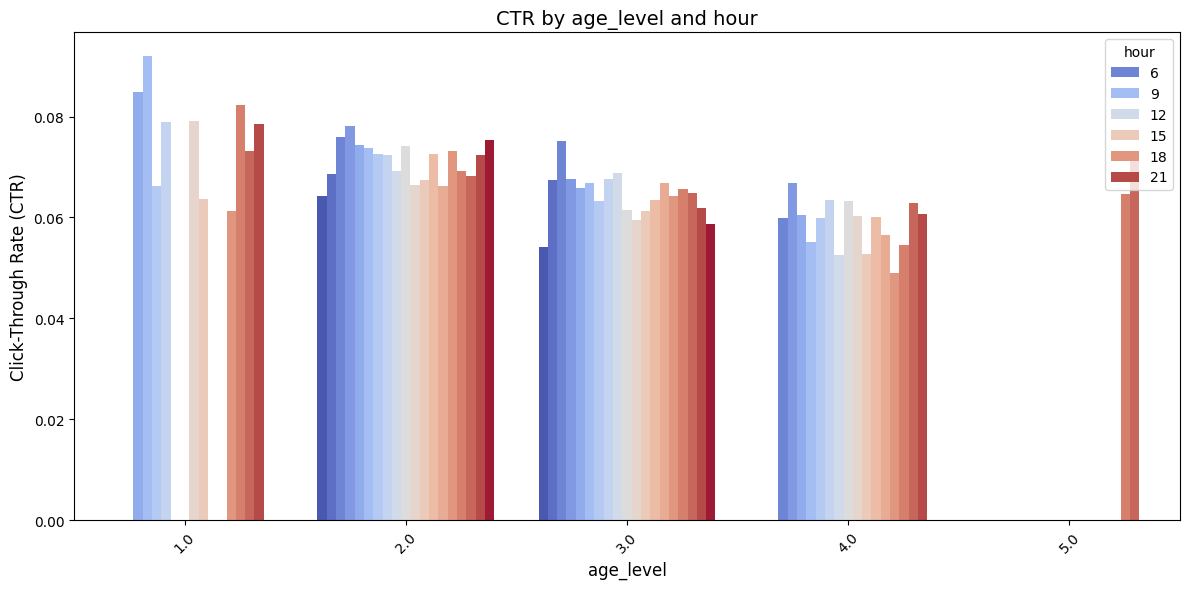

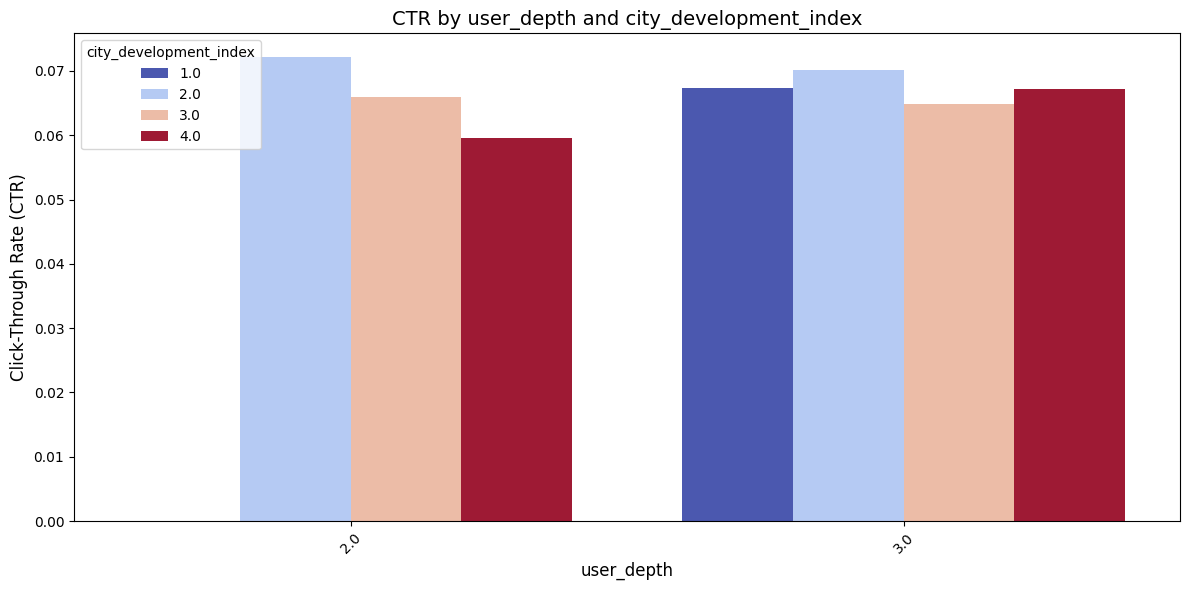

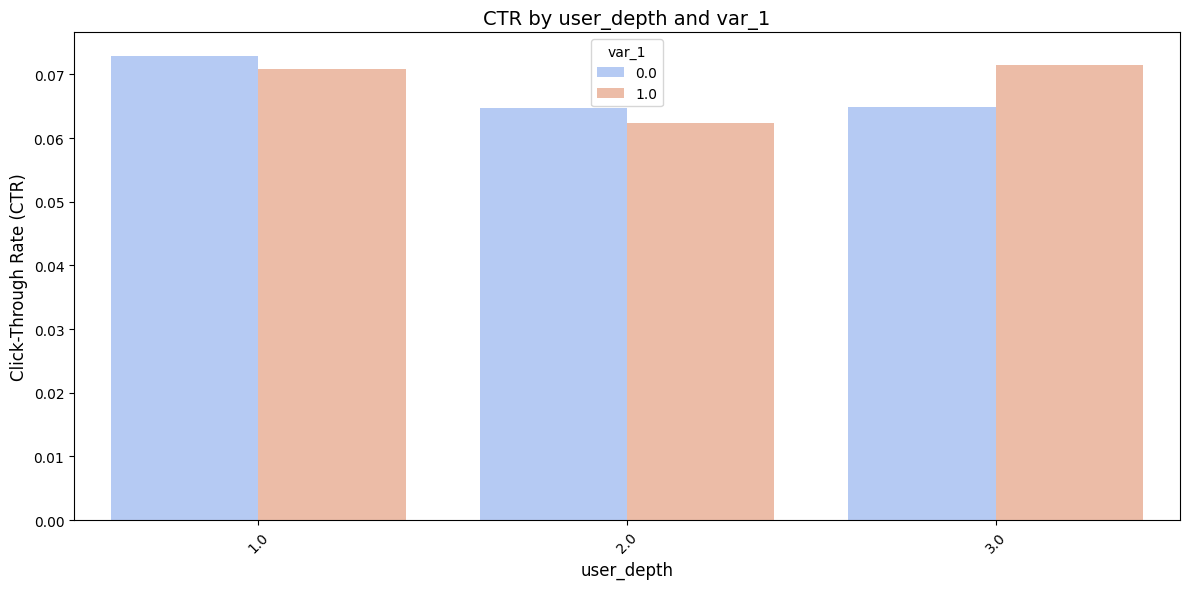

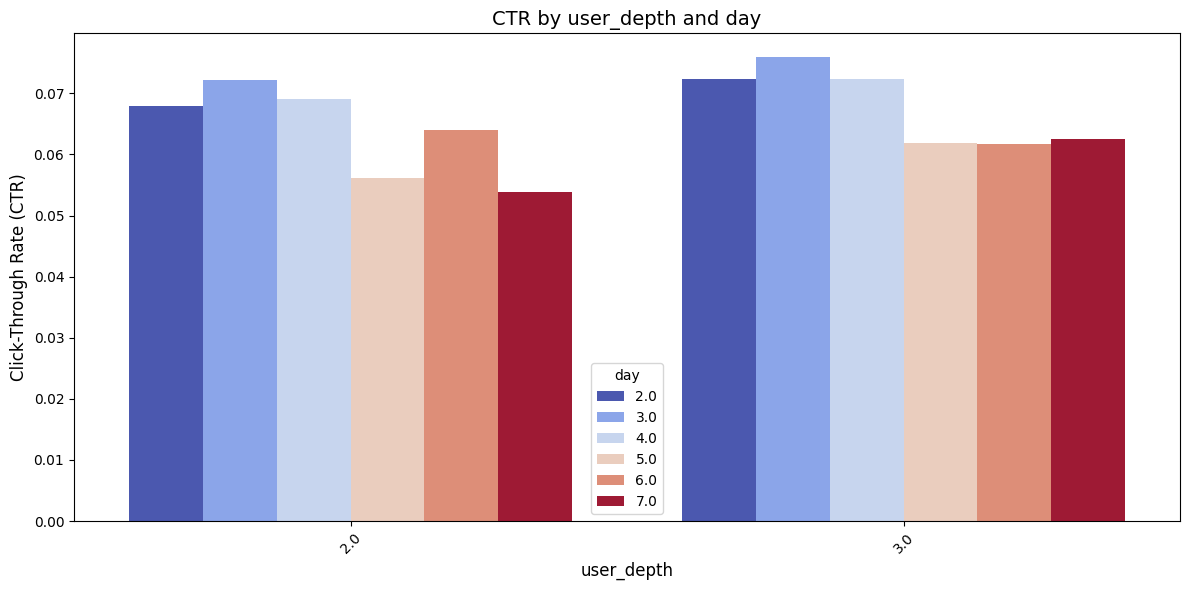

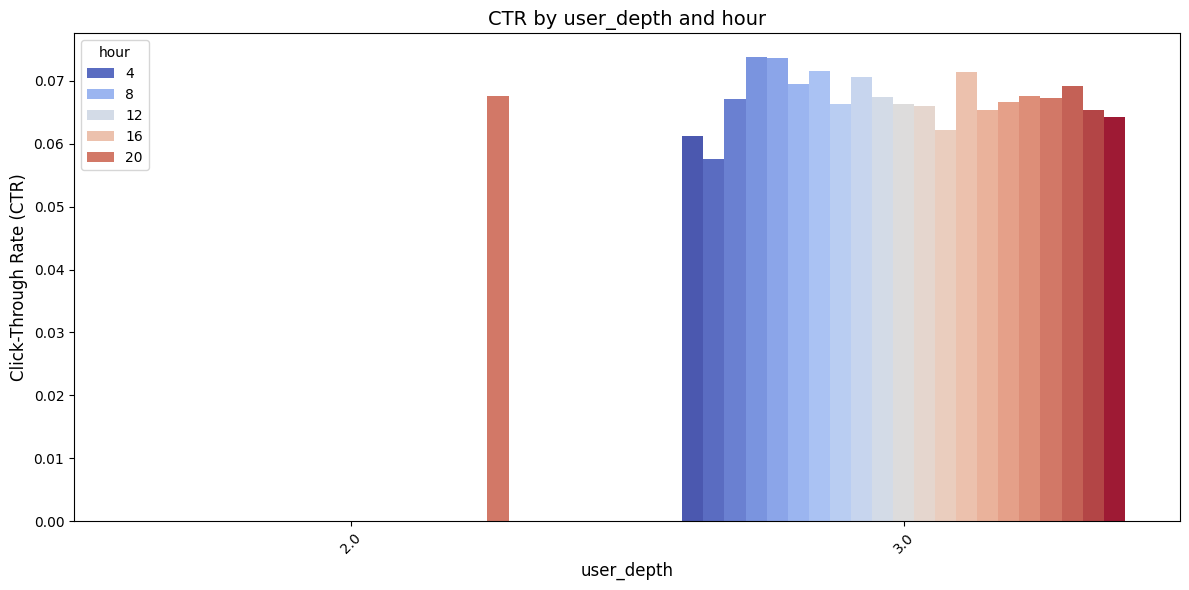

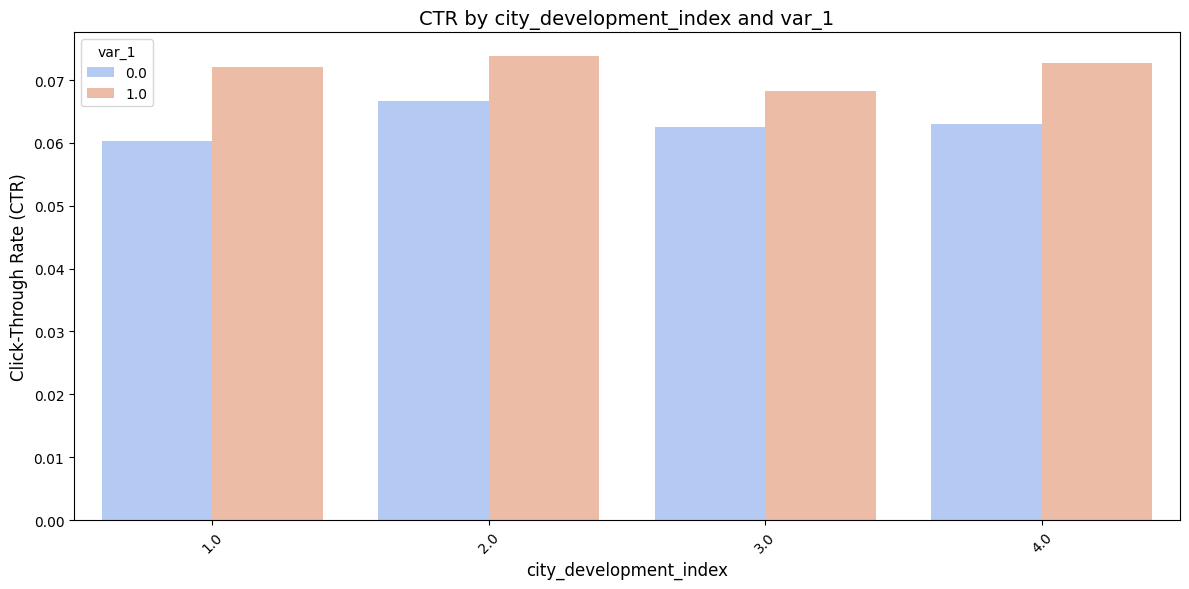

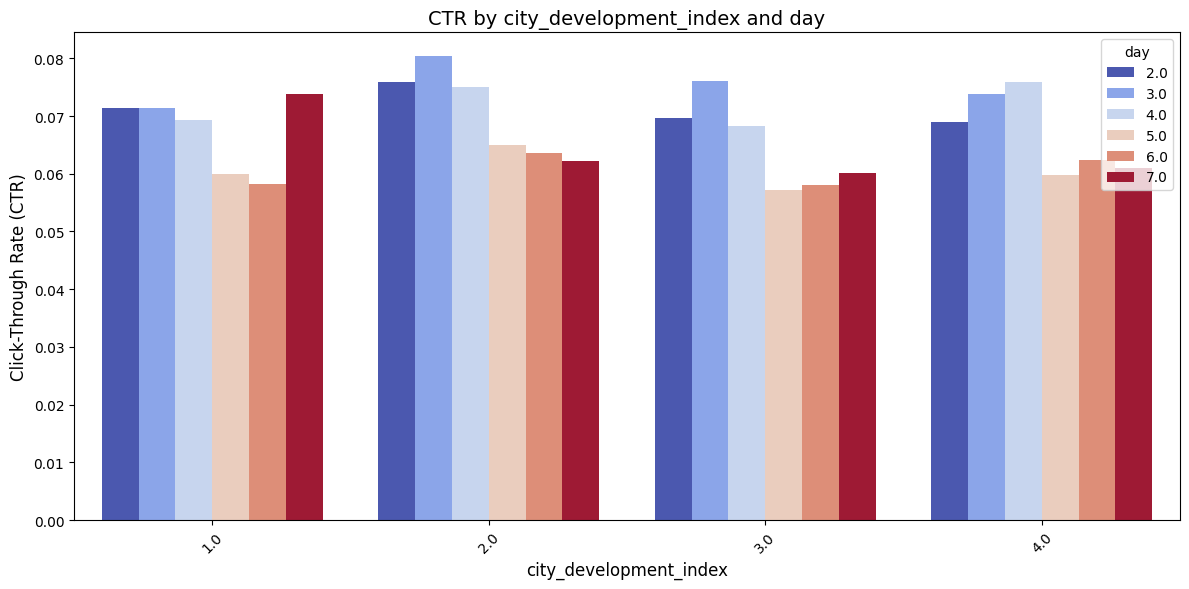

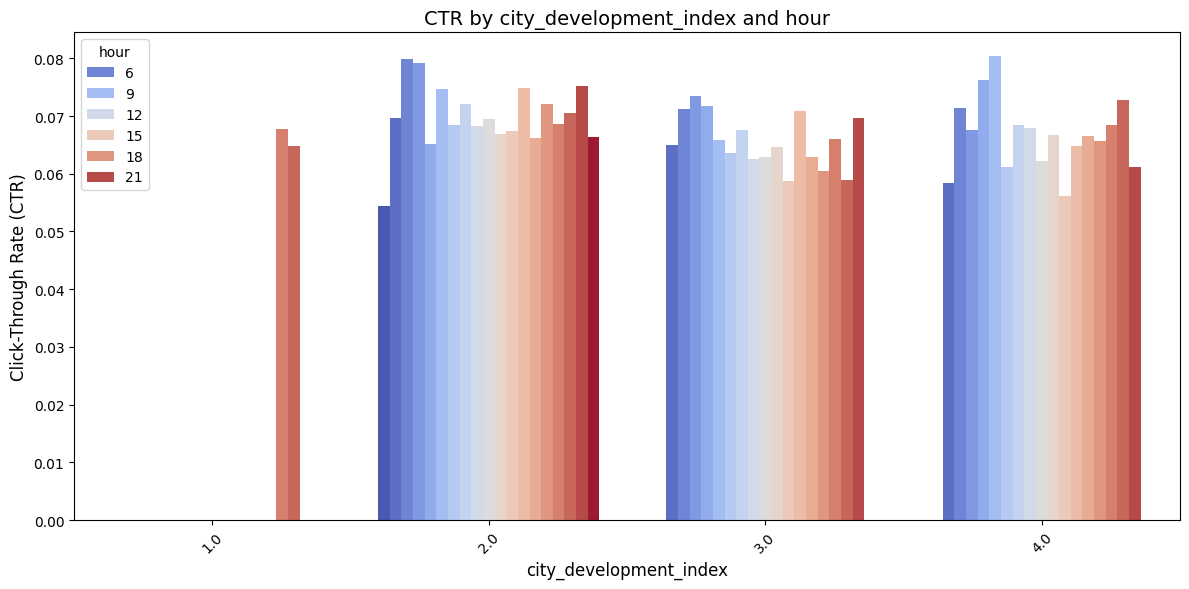

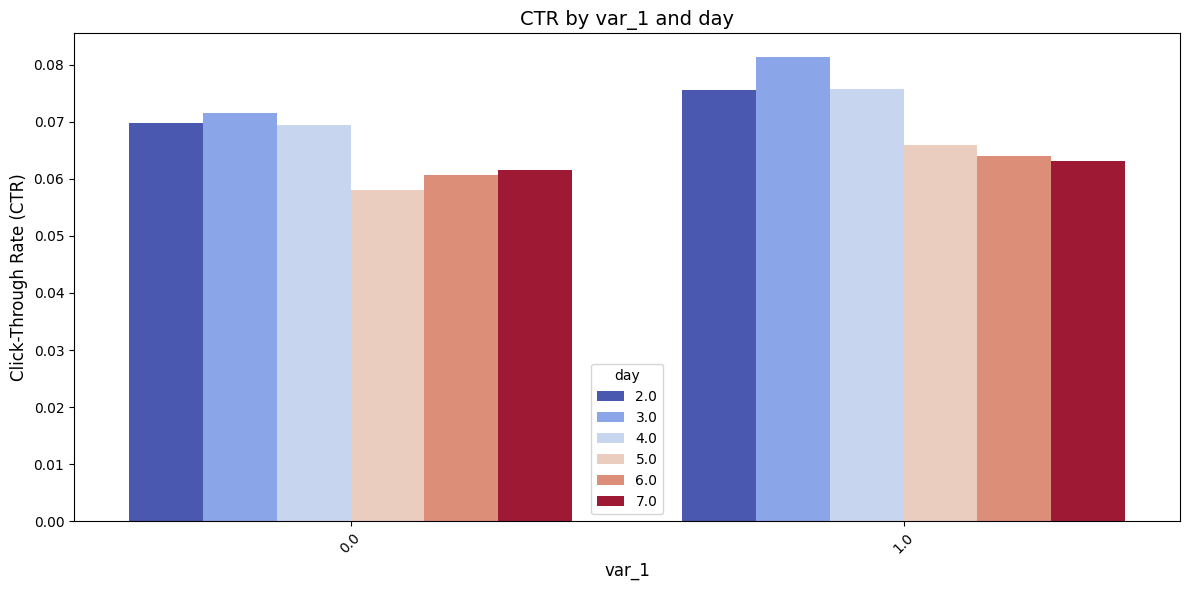

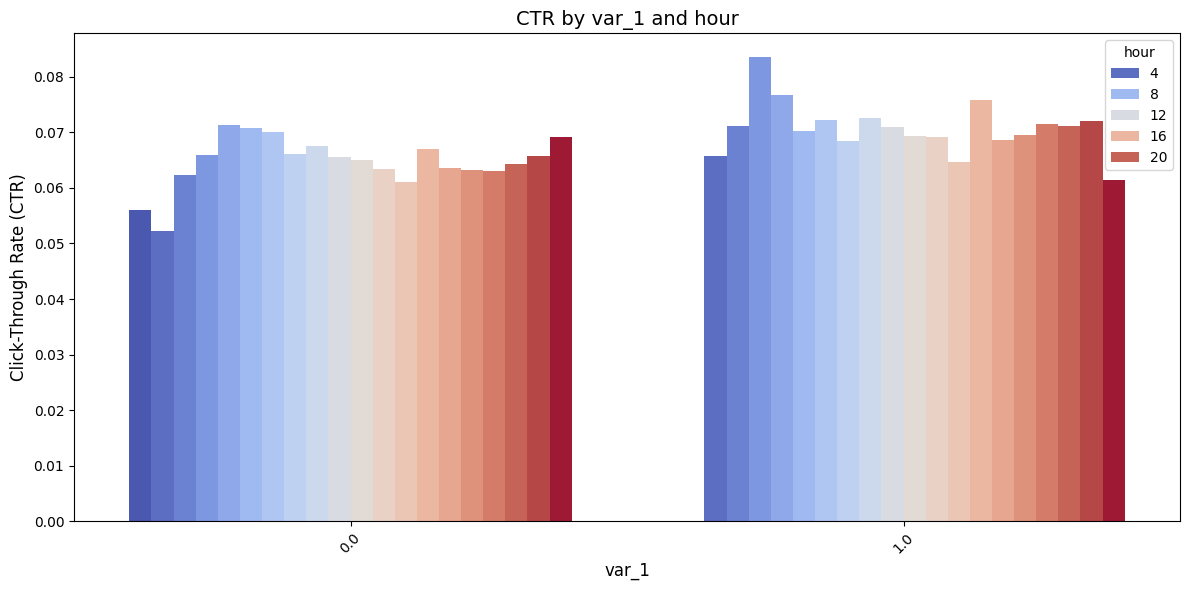

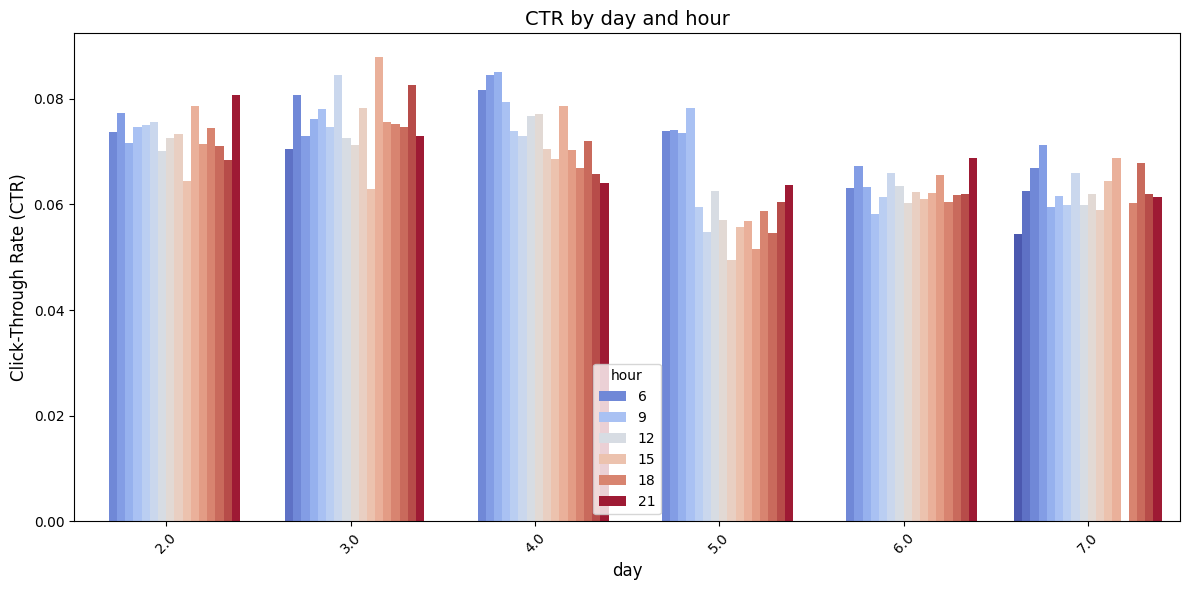

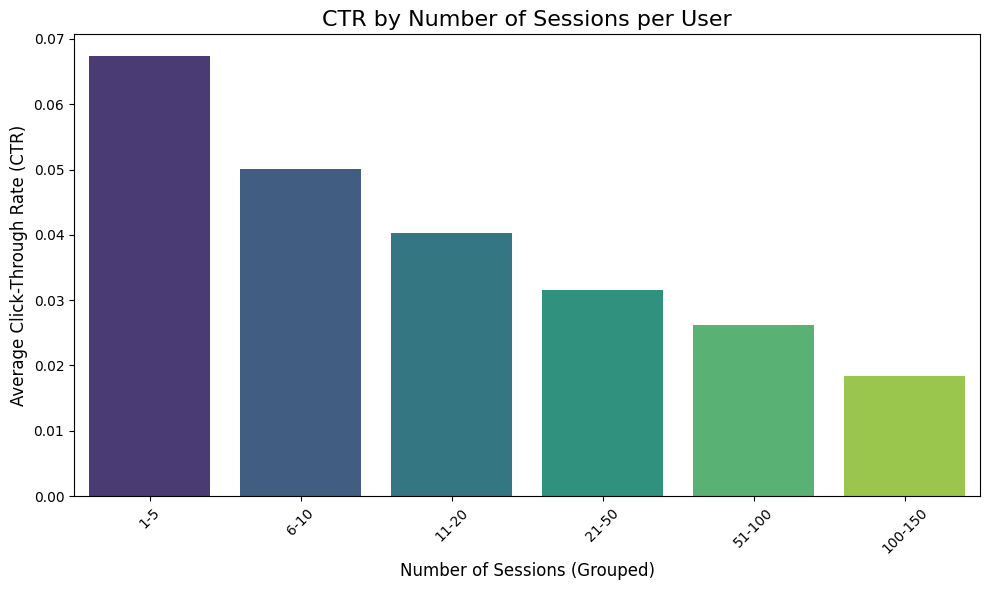

In [ ]:
df=df_.copy()

# Define features of interest
features = [
    'product', 'campaign_id', 'webpage_id', 'product_category_1',
    'user_group_id', 'gender', 'age_level', 'user_depth',
    'city_development_index', 'var_1', 'day', 'hour'
]

# --- Helper Functions ---
def filter_small_categories(df, feature):
    """Remove rows for feature categories with less than 0.5% of the total dataset."""
    total_count = df[feature].value_counts()
    threshold = 0.005 * len(df)  # 0.5% threshold
    valid_categories = total_count[total_count >= threshold].index
    return df[df[feature].isin(valid_categories)]

def create_three_subplots(total_count, clicked_count, ctr, feature_name, palette1, palette2, palette3, feature_label):
    """Create bar plots for total users, clicked users, and CTR by feature."""
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
    sns.barplot(x=total_count.index, y=total_count.values, palette=palette1, ax=ax1)
    ax1.set_title(f'Total Users by {feature_label}', fontsize=14)
    ax1.set_xlabel(feature_label, fontsize=12)
    ax1.set_ylabel('Total Users', fontsize=12)
    ax1.tick_params(axis='x', rotation=45)
    sns.barplot(x=clicked_count.index, y=clicked_count.values, palette=palette2, ax=ax2)
    ax2.set_title(f'Users Who Clicked by {feature_label}', fontsize=14)
    ax2.set_xlabel(feature_label, fontsize=12)
    ax2.set_ylabel('Users Who Clicked', fontsize=12)
    ax2.tick_params(axis='x', rotation=45)
    sns.barplot(x=ctr.index, y=ctr.values, palette=palette3, ax=ax3)
    ax3.set_title(f'CTR by {feature_label}', fontsize=14)
    ax3.set_xlabel(feature_label, fontsize=12)
    ax3.set_ylabel('Click-Through Rate (CTR)', fontsize=12)
    ax3.tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.show()

def plot_combined_feature_pairs(df, features):
    """Generate bar plots for CTR by all pairwise combinations of features."""
    for feature1, feature2 in combinations(features, 2):
        df_filtered = filter_small_categories(df, feature1)
        df_filtered = filter_small_categories(df_filtered, feature2)
        ctr_data = (
            df_filtered.groupby([feature1, feature2])['is_click']
            .mean()
            .reset_index()
            .rename(columns={'is_click': 'ctr'})
        )
        group_sizes = (
            df_filtered.groupby([feature1, feature2]).size()
            .reset_index()
            .rename(columns={0: 'count'})
        )
        ctr_data = ctr_data.merge(group_sizes, on=[feature1, feature2])
        threshold = 0.005 * len(df)
        ctr_data = ctr_data[ctr_data['count'] >= threshold]
        if not ctr_data.empty:
            plt.figure(figsize=(12, 6))
            sns.barplot(
                data=ctr_data,
                x=feature1,
                y='ctr',
                hue=feature2,
                palette='coolwarm'
            )
            plt.title(f'CTR by {feature1} and {feature2}', fontsize=14)
            plt.xlabel(feature1, fontsize=12)
            plt.ylabel('Click-Through Rate (CTR)', fontsize=12)
            plt.legend(title=feature2, fontsize=10)
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()

# --- Single Feature Analysis ---
for feature in features:
    df_filtered = filter_small_categories(df, feature)
    total_count = df_filtered[feature].value_counts()
    clicked_count = df_filtered[df_filtered['is_click'] == 1][feature].value_counts()
    ctr = df_filtered.groupby(feature)['is_click'].mean()
    create_three_subplots(
        total_count,
        clicked_count,
        ctr,
        feature_name=feature,
        palette1='Blues',
        palette2='Greens',
        palette3='Reds',
        feature_label=feature.capitalize()
    )

# --- Combined Feature Analysis ---
plot_combined_feature_pairs(df, features)

# --- Session Bin Analysis ---
user_stats = df.groupby('user_id').agg(
    total_sessions=('session_id', 'count'),
    total_clicks=('is_click', 'sum')
)
user_stats['ctr'] = user_stats['total_clicks'] / user_stats['total_sessions']
bins = [5, 10, 20, 50, 100, 150, user_stats['total_sessions'].max()]
labels = ['1-5', '6-10', '11-20', '21-50', '51-100', '100-150']
user_stats['session_bin'] = pd.cut(user_stats['total_sessions'], bins=bins, labels=labels, right=False)
bin_stats = user_stats.groupby('session_bin')['ctr'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=bin_stats, x='session_bin', y='ctr', palette='viridis')
plt.title('CTR by Number of Sessions per User', fontsize=16)
plt.xlabel('Number of Sessions (Grouped)', fontsize=12)
plt.ylabel('Average Click-Through Rate (CTR)', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# Step 1: Drop the 'city_development_index' column
df_processed = df.drop('city_development_index', axis=1)

# Step 2: Drop rows with NaN values
df_processed = df_processed.dropna()




In [ ]:
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 349147 entries, 0 to 370631
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   session_id          349147 non-null  float64       
 1   DateTime            349147 non-null  datetime64[ns]
 2   user_id             349147 non-null  float64       
 3   product             349147 non-null  object        
 4   campaign_id         349147 non-null  float64       
 5   webpage_id          349147 non-null  float64       
 6   product_category_1  349147 non-null  float64       
 7   user_group_id       349147 non-null  float64       
 8   gender              349147 non-null  object        
 9   age_level           349147 non-null  float64       
 10  user_depth          349147 non-null  float64       
 11  var_1               349147 non-null  float64       
 12  is_click            349147 non-null  float64       
 13  day                 349147 non-nul

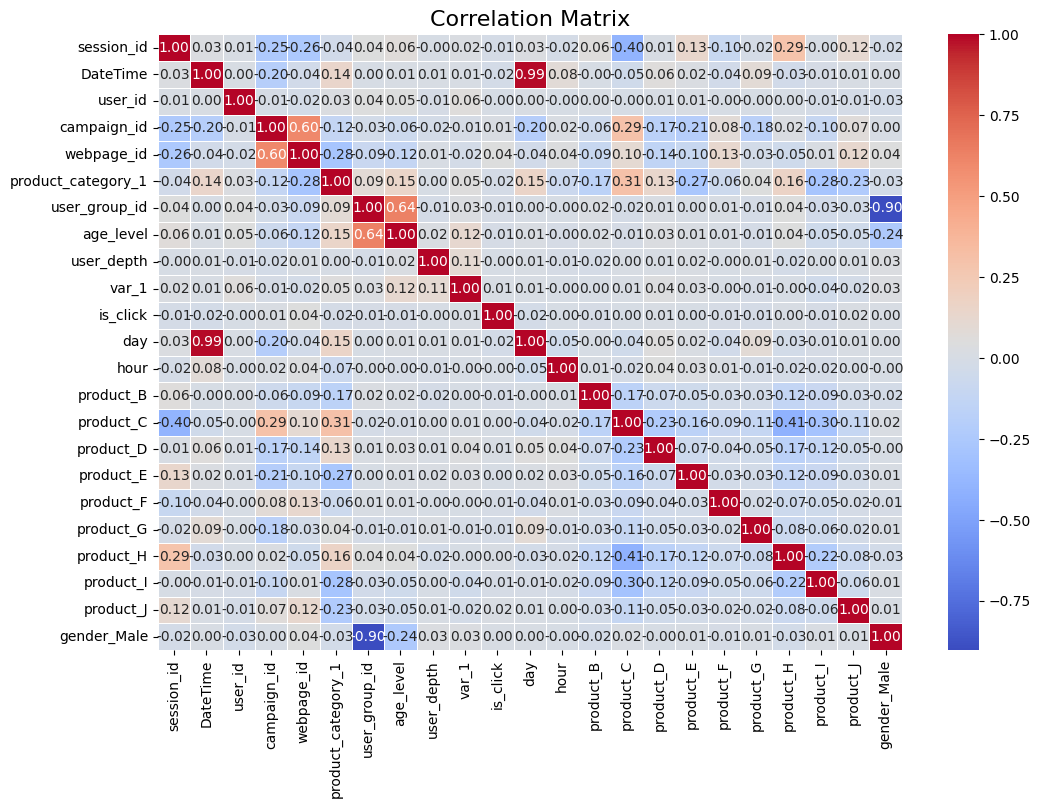

In [ ]:
# Option 1: Drop the 'product' column
#df_processed = df_processed.drop('product', axis=1)

# OR Option 2: Encode 'product' (e.g., use one-hot encoding or label encoding)
# Uncomment the next line if you prefer encoding over dropping
df_processed = pd.get_dummies(df_processed, columns=[ 'gender'], drop_first=True)

# Step 3: Calculate the correlation matrix
correlation_matrix = df_processed.corr()

# Step 4: Visualize the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix', fontsize=16)
plt.show()

In [ ]:
df_processed.columns

Index(['session_id', 'DateTime', 'user_id', 'campaign_id', 'webpage_id',
       'product_category_1', 'user_group_id', 'age_level', 'user_depth',
       'var_1', 'is_click', 'day', 'hour', 'product_B', 'product_C',
       'product_D', 'product_E', 'product_F', 'product_G', 'product_H',
       'product_I', 'product_J', 'gender_Male'],
      dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 350618 entries, 0 to 389111
Data columns (total 16 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   session_id              350246 non-null  float64       
 1   DateTime                350239 non-null  datetime64[ns]
 2   user_id                 350618 non-null  float64       
 3   product                 350281 non-null  object        
 4   campaign_id             350262 non-null  float64       
 5   webpage_id              350248 non-null  float64       
 6   product_category_1      350265 non-null  float64       
 7   user_group_id           350561 non-null  float64       
 8   gender                  350567 non-null  object        
 9   age_level               350566 non-null  float64       
 10  user_depth              350259 non-null  float64       
 11  city_development_index  266379 non-null  float64       
 12  var_1                   350249 non-

Columns after one-hot encoding:
Index(['user_id', 'day', 'hour', 'campaign_id_98970.0', 'campaign_id_105960.0',
       'campaign_id_118601.0', 'campaign_id_359520.0', 'campaign_id_360936.0',
       'campaign_id_396664.0', 'campaign_id_404347.0', 'campaign_id_405490.0',
       'campaign_id_414149.0', 'webpage_id_6970.0', 'webpage_id_11085.0',
       'webpage_id_13787.0', 'webpage_id_28529.0', 'webpage_id_45962.0',
       'webpage_id_51181.0', 'webpage_id_53587.0', 'webpage_id_60305.0',
       'product_category_1_2.0', 'product_category_1_3.0',
       'product_category_1_4.0', 'product_category_1_5.0', 'user_group_id_1.0',
       'user_group_id_2.0', 'user_group_id_3.0', 'user_group_id_4.0',
       'user_group_id_5.0', 'user_group_id_6.0', 'user_group_id_7.0',
       'user_group_id_8.0', 'user_group_id_9.0', 'user_group_id_10.0',
       'user_group_id_11.0', 'user_group_id_12.0', 'age_level_1.0',
       'age_level_2.0', 'age_level_3.0', 'age_level_4.0', 'age_level_5.0',
       'age_level

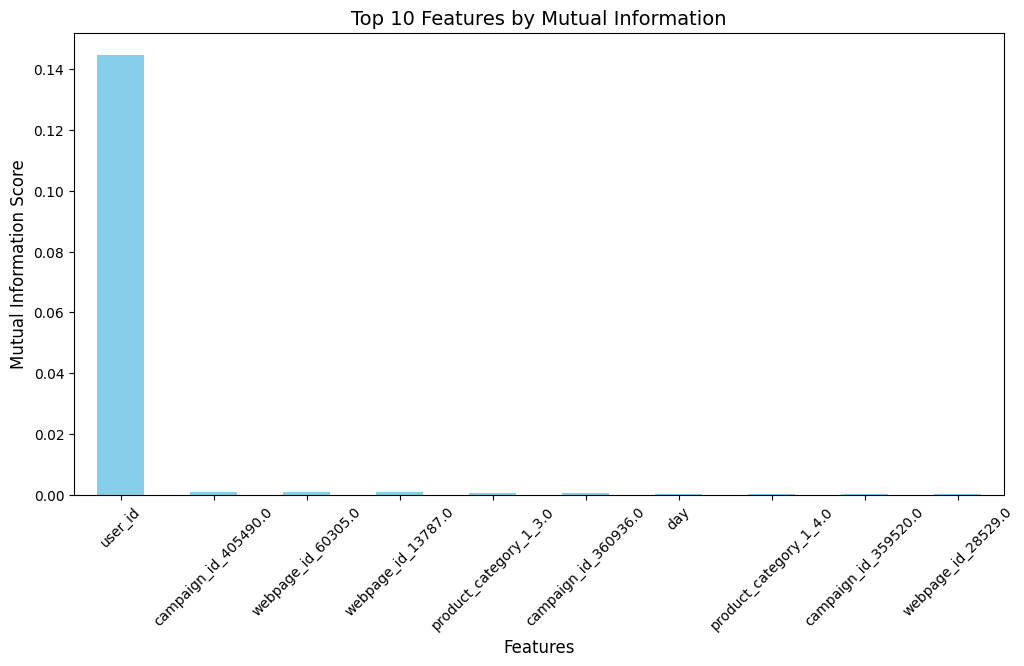

Chi-Square Results:
                   Feature     Chi2 Score        P-Value
0                  user_id  266528.252279   0.000000e+00
10    campaign_id_405490.0     475.682076  1.859187e-105
19      webpage_id_60305.0     475.682076  1.859187e-105
14      webpage_id_13787.0     263.233450   3.386239e-59
21  product_category_1_3.0     256.928207   8.018786e-58
7     campaign_id_360936.0     254.864660   2.259123e-57
22  product_category_1_4.0      85.048631   2.911163e-20
6     campaign_id_359520.0      75.132470   4.401675e-18
53               product_J      67.122467   2.551540e-16
1                      day      64.869511   8.002576e-16
15      webpage_id_28529.0      61.398855   4.660814e-15
5     campaign_id_118601.0      61.398855   4.660814e-15
39           age_level_4.0      58.129155   2.454613e-14
23  product_category_1_5.0      45.936817   1.221290e-11
50               product_G      41.511600   1.171736e-10
27       user_group_id_4.0      40.156449   2.344164e-10
12       we

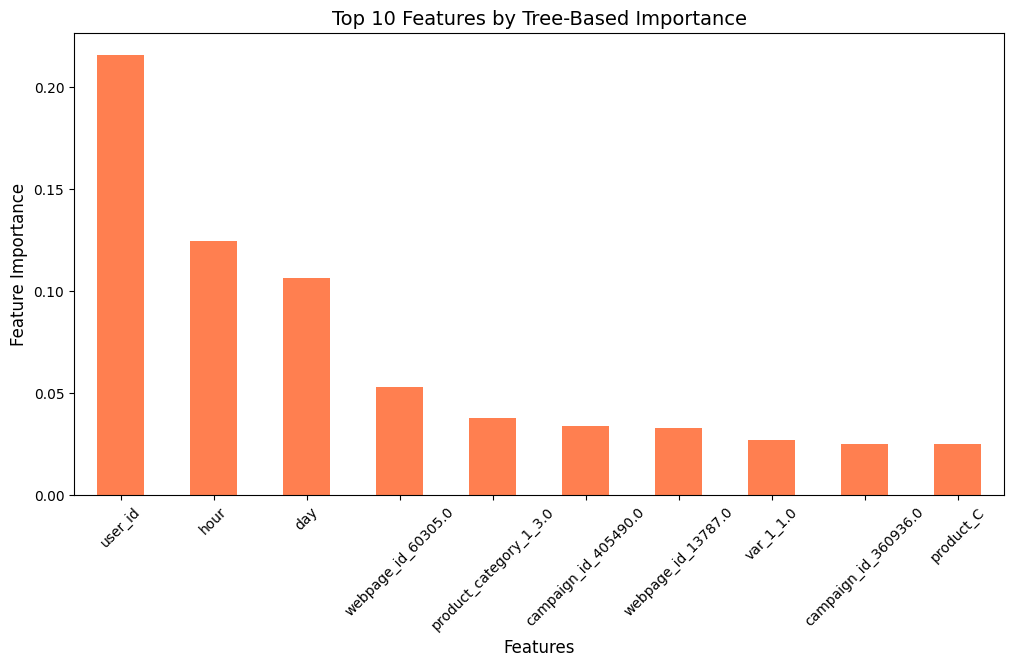

In [ ]:
import pandas as pd
from sklearn.feature_selection import mutual_info_classif, chi2
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Step 1: Drop the 'city_development_index' column
df_processed = df.drop('city_development_index', axis=1)

# Step 2: Drop rows with NaN values
df_processed = df_processed.dropna()

# List of features to exclude from dummy encoding (day, hour, and DateTime)
categorical_cols = ['user_id', 'campaign_id', 'webpage_id',
                    'product_category_1', 'user_group_id', 'age_level',
                    'user_depth', 'var_1', 'product' ,'gender']

# Separate features (X) and label (y)
X = df_processed[categorical_cols + ['day', 'hour']]  # Adding 'day' and 'hour' back if not included
y = df_processed['is_click']

# Drop the 'session_id' and 'user_id' columns from X
#X = X.drop(columns=['session_id'])

# Step 3: Convert categorical features to dummy variables (one-hot encoding)
X_dummies = pd.get_dummies(X, columns=['campaign_id', 'webpage_id', 'product_category_1',
                                       'user_group_id', 'age_level', 'user_depth', 'var_1',
                                       'product', 'gender'], drop_first=True)

# Inspect the resulting columns to verify all features are included
print("Columns after one-hot encoding:")
print(X_dummies.columns)

# Step 4: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_dummies, y, test_size=0.2, random_state=42)

# Ensure all columns in X_train are numeric (check if anything is excluded mistakenly)
X_train = X_train.select_dtypes(include=['float64', 'int64', 'bool'])

# Step 5: Mutual Information
mi_scores = mutual_info_classif(X_train, y_train, discrete_features=True)  # Use 'discrete_features' instead of 'discrete_values'
mi_scores = pd.Series(mi_scores, index=X_train.columns).sort_values(ascending=False)

print("Mutual Information Scores:")
print(mi_scores)

# Visualize Mutual Information
plt.figure(figsize=(12, 6))
mi_scores.head(10).plot(kind='bar', color='skyblue')
plt.title('Top 10 Features by Mutual Information', fontsize=14)
plt.ylabel('Mutual Information Score', fontsize=12)
plt.xlabel('Features', fontsize=12)
plt.xticks(rotation=45)
plt.show()

# Step 6: Chi-Square Test
# Ensure X_train contains only numeric columns before running chi2 test
chi2_scores, p_values = chi2(X_train, y_train)
chi2_results = pd.DataFrame({
    'Feature': X_train.columns,
    'Chi2 Score': chi2_scores,
    'P-Value': p_values
}).sort_values(by='Chi2 Score', ascending=False)
print("Chi-Square Results:")
print(chi2_results)

# Step 7: Tree-Based Feature Importance
model = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10, min_samples_split=5, max_features='sqrt')
model.fit(X_train, y_train)
feature_importances = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

print("Tree-Based Feature Importances:")
print(feature_importances)

# Visualize Feature Importance
plt.figure(figsize=(12, 6))
feature_importances.head(10).plot(kind='bar', color='coral')
plt.title('Top 10 Features by Tree-Based Importance', fontsize=14)
plt.ylabel('Feature Importance', fontsize=12)
plt.xlabel('Features', fontsize=12)
plt.xticks(rotation=45)
plt.show()


Columns after one-hot encoding:
Index(['user_id', 'day', 'hour', 'campaign_id_98970.0', 'campaign_id_105960.0',
       'campaign_id_118601.0', 'campaign_id_359520.0', 'campaign_id_360936.0',
       'campaign_id_396664.0', 'campaign_id_404347.0', 'campaign_id_405490.0',
       'campaign_id_414149.0', 'webpage_id_6970.0', 'webpage_id_11085.0',
       'webpage_id_13787.0', 'webpage_id_28529.0', 'webpage_id_45962.0',
       'webpage_id_51181.0', 'webpage_id_53587.0', 'webpage_id_60305.0',
       'product_category_1_2.0', 'product_category_1_3.0',
       'product_category_1_4.0', 'product_category_1_5.0', 'user_group_id_1.0',
       'user_group_id_2.0', 'user_group_id_3.0', 'user_group_id_4.0',
       'user_group_id_5.0', 'user_group_id_6.0', 'user_group_id_7.0',
       'user_group_id_8.0', 'user_group_id_9.0', 'user_group_id_10.0',
       'user_group_id_11.0', 'user_group_id_12.0', 'age_level_1.0',
       'age_level_2.0', 'age_level_3.0', 'age_level_4.0', 'age_level_5.0',
       'age_level

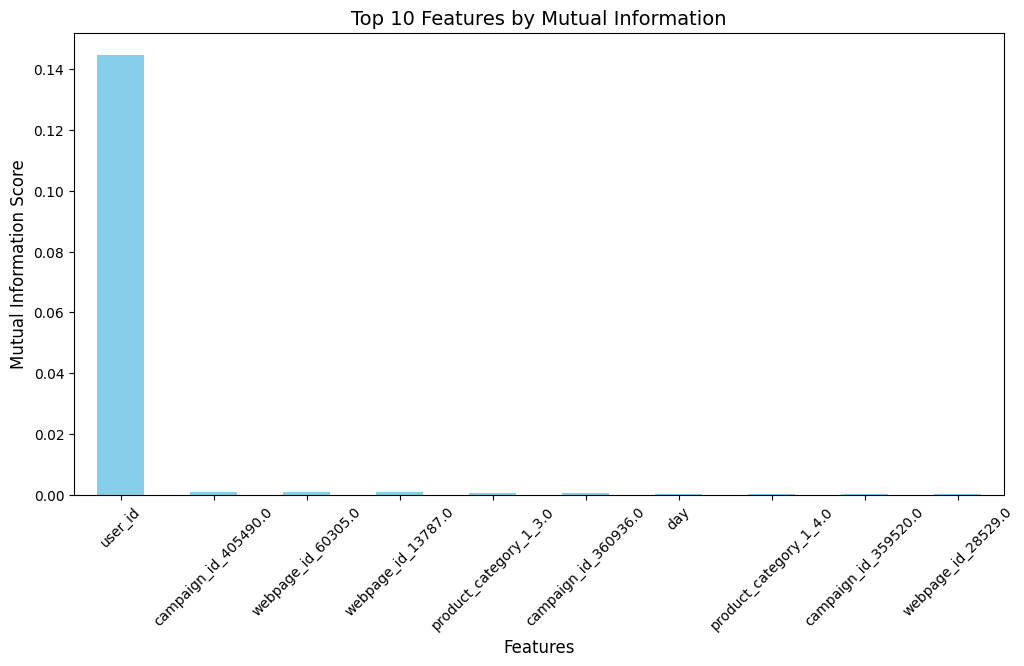

Cumulative Mutual Information:
user_id                   0.958206
campaign_id_405490.0      0.964851
webpage_id_60305.0        0.971495
webpage_id_13787.0        0.976431
product_category_1_3.0    0.980297
campaign_id_360936.0      0.984075
day                       0.985809
product_category_1_4.0    0.987262
campaign_id_359520.0      0.988459
webpage_id_28529.0        0.989297
campaign_id_118601.0      0.990136
age_level_4.0             0.990971
product_J                 0.991701
product_category_1_5.0    0.992358
product_G                 0.992917
user_group_id_4.0         0.993474
hour                      0.994012
var_1_1.0                 0.994453
webpage_id_6970.0         0.994799
campaign_id_98970.0       0.995144
product_category_1_2.0    0.995478
product_B                 0.995807
product_F                 0.996120
webpage_id_53587.0        0.996416
campaign_id_404347.0      0.996712
user_group_id_2.0         0.996991
age_level_2.0             0.997248
user_group_id_1.0       

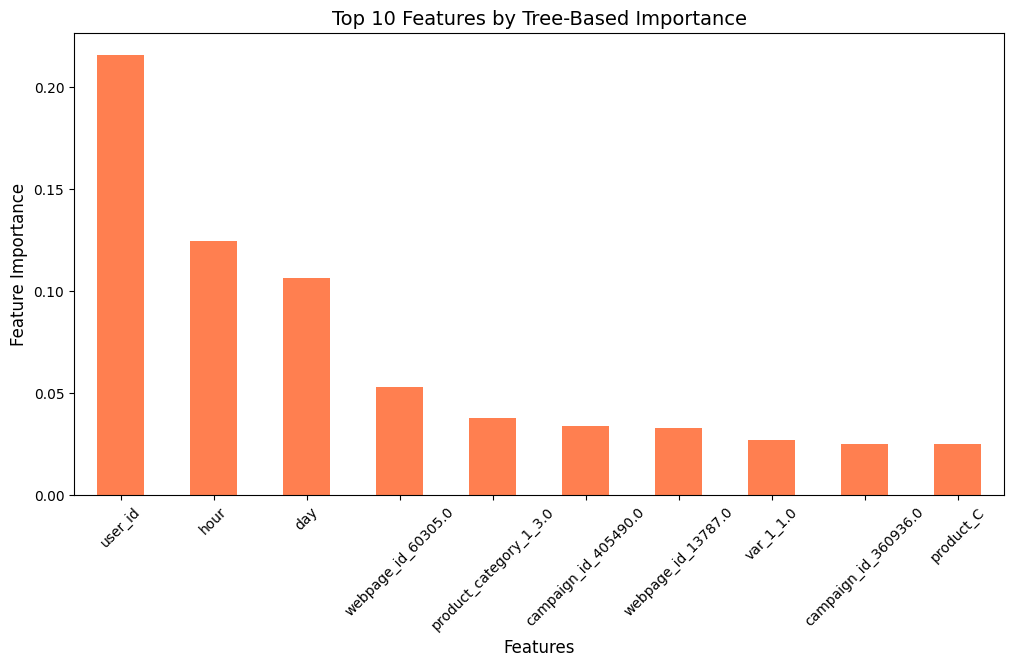

Selected Features by Random Forest (80% cumulative importance): Index(['user_id', 'hour', 'day', 'webpage_id_60305.0',
       'product_category_1_3.0', 'campaign_id_405490.0', 'webpage_id_13787.0',
       'var_1_1.0', 'campaign_id_360936.0', 'product_C', 'user_depth_3.0',
       'product_H', 'product_category_1_2.0', 'user_depth_2.0',
       'product_category_1_4.0', 'product_D', 'product_F', 'age_level_4.0'],
      dtype='object')


In [ ]:
import pandas as pd
from sklearn.feature_selection import mutual_info_classif, chi2
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Step 1: Drop the 'city_development_index' column
df_processed = df.drop('city_development_index', axis=1)

# Step 2: Drop rows with NaN values
df_processed = df_processed.dropna()

# List of features to exclude from dummy encoding (day, hour, and DateTime)
categorical_cols = ['user_id', 'campaign_id', 'webpage_id',
                    'product_category_1', 'user_group_id', 'age_level',
                    'user_depth', 'var_1', 'product' ,'gender']

# Separate features (X) and label (y)
X = df_processed[categorical_cols + ['day', 'hour']]  # Adding 'day' and 'hour' back if not included
y = df_processed['is_click']

# Step 3: Convert categorical features to dummy variables (one-hot encoding)
X_dummies = pd.get_dummies(X, columns=['campaign_id', 'webpage_id', 'product_category_1',
                                       'user_group_id', 'age_level', 'user_depth', 'var_1',
                                       'product', 'gender'], drop_first=True)

# Inspect the resulting columns to verify all features are included
print("Columns after one-hot encoding:")
print(X_dummies.columns)

# Step 4: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_dummies, y, test_size=0.2, random_state=42)

# Ensure all columns in X_train are numeric (check if anything is excluded mistakenly)
X_train = X_train.select_dtypes(include=['float64', 'int64', 'bool'])

# Step 5: Mutual Information
mi_scores = mutual_info_classif(X_train, y_train, discrete_features=True)  # Use 'discrete_features' instead of 'discrete_values'
mi_scores = pd.Series(mi_scores, index=X_train.columns).sort_values(ascending=False)

print("Mutual Information Scores:")
print(mi_scores)

# Visualize Mutual Information
plt.figure(figsize=(12, 6))
mi_scores.head(10).plot(kind='bar', color='skyblue')
plt.title('Top 10 Features by Mutual Information', fontsize=14)
plt.ylabel('Mutual Information Score', fontsize=12)
plt.xlabel('Features', fontsize=12)
plt.xticks(rotation=45)
plt.show()




# Normalize MI scores to sum to 100% (normalize to [0,1] scale)
mi_scores_normalized = mi_scores / mi_scores.sum()

# Select features based on cumulative mutual information (80% threshold)
cumulative_mi = mi_scores_normalized.cumsum()

# Print out the cumulative MI and see where the threshold is being reached
print("Cumulative Mutual Information:")
print(cumulative_mi)

selected_mi_features = mi_scores[cumulative_mi <= 0.20].index
print(f"Selected Features by Mutual Information (80% cumulative importance): {selected_mi_features}")

# Step 6: Chi-Square Test
# Ensure X_train contains only numeric columns before running chi2 test
chi2_scores, p_values = chi2(X_train, y_train)
chi2_results = pd.DataFrame({
    'Feature': X_train.columns,
    'Chi2 Score': chi2_scores,
    'P-Value': p_values
}).sort_values(by='Chi2 Score', ascending=False)
print("Chi-Square Results:")
print(chi2_results)

# Step 7: Tree-Based Feature Importance
model = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10, min_samples_split=5, max_features='sqrt')
model.fit(X_train, y_train)
feature_importances = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

print("Tree-Based Feature Importances:")
print(feature_importances)

# Visualize Feature Importance
plt.figure(figsize=(12, 6))
feature_importances.head(10).plot(kind='bar', color='coral')
plt.title('Top 10 Features by Tree-Based Importance', fontsize=14)
plt.ylabel('Feature Importance', fontsize=12)
plt.xlabel('Features', fontsize=12)
plt.xticks(rotation=45)
plt.show()

# Select features based on cumulative random forest feature importance (80% threshold)
cumulative_rf = feature_importances.cumsum() / feature_importances.sum()
selected_rf_features = feature_importances[cumulative_rf <= 0.80].index
print(f"Selected Features by Random Forest (80% cumulative importance): {selected_rf_features}")

# Optionally: You can use these selected features to train your models again with fewer features:
X_train_selected_mi = X_train[selected_mi_features]
X_train_selected_rf = X_train[selected_rf_features]


Columns after one-hot encoding:
Index(['day', 'hour', 'campaign_id_98970.0', 'campaign_id_105960.0',
       'campaign_id_118601.0', 'campaign_id_359520.0', 'campaign_id_360936.0',
       'campaign_id_396664.0', 'campaign_id_404347.0', 'campaign_id_405490.0',
       'campaign_id_414149.0', 'webpage_id_6970.0', 'webpage_id_11085.0',
       'webpage_id_13787.0', 'webpage_id_28529.0', 'webpage_id_45962.0',
       'webpage_id_51181.0', 'webpage_id_53587.0', 'webpage_id_60305.0',
       'product_category_1_2.0', 'product_category_1_3.0',
       'product_category_1_4.0', 'product_category_1_5.0', 'user_group_id_1.0',
       'user_group_id_2.0', 'user_group_id_3.0', 'user_group_id_4.0',
       'user_group_id_5.0', 'user_group_id_6.0', 'user_group_id_7.0',
       'user_group_id_8.0', 'user_group_id_9.0', 'user_group_id_10.0',
       'user_group_id_11.0', 'user_group_id_12.0', 'age_level_1.0',
       'age_level_2.0', 'age_level_3.0', 'age_level_4.0', 'age_level_5.0',
       'age_level_6.0', 'use

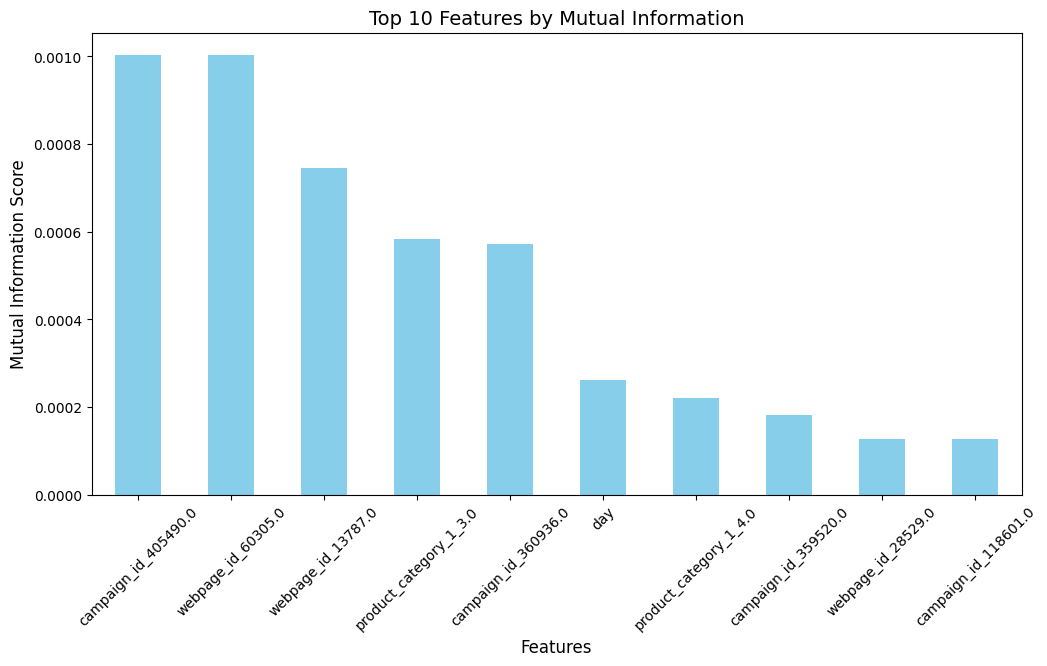

Cumulative Mutual Information:
campaign_id_405490.0      0.158984
webpage_id_60305.0        0.317968
webpage_id_13787.0        0.436068
product_category_1_3.0    0.528560
campaign_id_360936.0      0.618959
day                       0.660454
product_category_1_4.0    0.695230
campaign_id_359520.0      0.723859
webpage_id_28529.0        0.743917
campaign_id_118601.0      0.763976
age_level_4.0             0.783973
product_J                 0.801422
product_category_1_5.0    0.817147
product_G                 0.830532
user_group_id_4.0         0.843855
hour                      0.856722
var_1_1.0                 0.867284
webpage_id_6970.0         0.875546
campaign_id_98970.0       0.883807
product_category_1_2.0    0.891808
product_B                 0.899683
product_F                 0.907173
webpage_id_53587.0        0.914247
campaign_id_404347.0      0.921321
user_group_id_2.0         0.928000
age_level_2.0             0.934145
user_group_id_1.0         0.940174
webpage_id_45962.0      

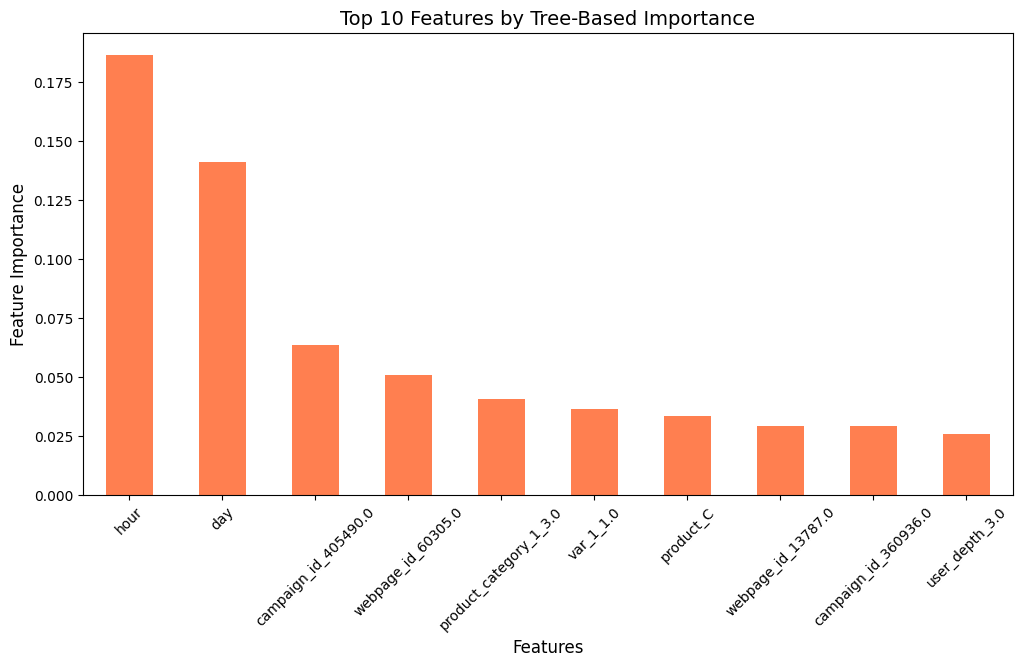

Cumulative RF Information:
hour                      0.186685
day                       0.327809
campaign_id_405490.0      0.391503
webpage_id_60305.0        0.442258
product_category_1_3.0    0.482756
var_1_1.0                 0.519116
product_C                 0.552450
webpage_id_13787.0        0.581727
campaign_id_360936.0      0.610965
user_depth_3.0            0.636600
product_H                 0.660616
user_depth_2.0            0.683407
product_category_1_2.0    0.705782
product_category_1_4.0    0.723491
product_D                 0.737253
product_F                 0.750547
product_J                 0.763330
product_category_1_5.0    0.774470
age_level_4.0             0.785092
user_group_id_4.0         0.795396
age_level_5.0             0.805683
gender_Male               0.815113
campaign_id_98970.0       0.824290
product_I                 0.832531
product_B                 0.840538
user_group_id_5.0         0.848327
campaign_id_359520.0      0.856026
age_level_3.0             0.

In [ ]:
import pandas as pd
from sklearn.feature_selection import mutual_info_classif, chi2
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Step 1: Drop the 'city_development_index' column
df_processed = df.drop('city_development_index', axis=1)

# Step 2: Drop rows with NaN values
df_processed = df_processed.dropna()

# List of features to exclude from dummy encoding (day, hour, and DateTime)
categorical_cols = [ 'campaign_id', 'webpage_id',
                    'product_category_1', 'user_group_id', 'age_level',
                    'user_depth', 'var_1', 'product' ,'gender']

# Separate features (X) and label (y)
X = df_processed[categorical_cols + ['day', 'hour']]  # Adding 'day' and 'hour' back if not included
y = df_processed['is_click']

# Step 3: Convert categorical features to dummy variables (one-hot encoding)
X_dummies = pd.get_dummies(X, columns=['campaign_id', 'webpage_id', 'product_category_1',
                                       'user_group_id', 'age_level', 'user_depth', 'var_1',
                                       'product', 'gender'], drop_first=True)

# Inspect the resulting columns to verify all features are included
print("Columns after one-hot encoding:")
print(X_dummies.columns)

# Step 4: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_dummies, y, test_size=0.2, random_state=42)

# Ensure all columns in X_train are numeric (check if anything is excluded mistakenly)
X_train = X_train.select_dtypes(include=['float64', 'int64', 'bool'])

# Step 5: Mutual Information
mi_scores = mutual_info_classif(X_train, y_train, discrete_features=True)  # Use 'discrete_features' instead of 'discrete_values'
mi_scores = pd.Series(mi_scores, index=X_train.columns).sort_values(ascending=False)

print("Mutual Information Scores:")
print(mi_scores)

# Visualize Mutual Information
plt.figure(figsize=(12, 6))
mi_scores.head(10).plot(kind='bar', color='skyblue')
plt.title('Top 10 Features by Mutual Information', fontsize=14)
plt.ylabel('Mutual Information Score', fontsize=12)
plt.xlabel('Features', fontsize=12)
plt.xticks(rotation=45)
plt.show()




# Normalize MI scores to sum to 100% (normalize to [0,1] scale)
mi_scores_normalized = mi_scores / mi_scores.sum()

# Select features based on cumulative mutual information (80% threshold)
cumulative_mi = mi_scores_normalized.cumsum()

# Print out the cumulative MI and see where the threshold is being reached
print("Cumulative Mutual Information:")
print(cumulative_mi)

selected_mi_features = mi_scores[cumulative_mi <= 0.85].index
print(f"Selected Features by Mutual Information (80% cumulative importance): {selected_mi_features}")

# Step 6: Chi-Square Test
# Ensure X_train contains only numeric columns before running chi2 test
chi2_scores, p_values = chi2(X_train, y_train)
chi2_results = pd.DataFrame({
    'Feature': X_train.columns,
    'Chi2 Score': chi2_scores,
    'P-Value': p_values
}).sort_values(by='Chi2 Score', ascending=False)
print("Chi-Square Results:")
print(chi2_results)

# Step 7: Tree-Based Feature Importance
model = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10, min_samples_split=5, max_features='sqrt')
model.fit(X_train, y_train)
feature_importances = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

print("Tree-Based Feature Importances:")
print(feature_importances)

# Visualize Feature Importance
plt.figure(figsize=(12, 6))
feature_importances.head(10).plot(kind='bar', color='coral')
plt.title('Top 10 Features by Tree-Based Importance', fontsize=14)
plt.ylabel('Feature Importance', fontsize=12)
plt.xlabel('Features', fontsize=12)
plt.xticks(rotation=45)
plt.show()

# Select features based on cumulative random forest feature importance (80% threshold)
cumulative_rf = feature_importances.cumsum() / feature_importances.sum()

print("Cumulative RF Information:")
print(cumulative_rf)

selected_rf_features = feature_importances[cumulative_rf <= 0.85].index
print(f"Selected Features by Random Forest (80% cumulative importance): {selected_rf_features}")

# Optionally: You can use these selected features to train your models again with fewer features:
X_train_selected_mi = X_train[selected_mi_features]
X_train_selected_rf = X_train[selected_rf_features]


Tree-Based Feature Importances (Class-Weighted):
day                       0.121777
user_depth_3.0            0.104640
var_1_1.0                 0.104241
user_depth_2.0            0.069142
product_C                 0.043915
product_category_1_3.0    0.042081
campaign_id_405490.0      0.040105
product_H                 0.039145
webpage_id_60305.0        0.033924
product_I                 0.031643
gender_Male               0.031294
hour                      0.030108
product_D                 0.021450
product_category_1_2.0    0.019674
campaign_id_360936.0      0.018120
product_J                 0.017193
campaign_id_359520.0      0.016642
user_group_id_9.0         0.016424
webpage_id_13787.0        0.013704
product_category_1_4.0    0.013469
product_B                 0.013374
product_category_1_5.0    0.012708
user_group_id_10.0        0.011461
user_group_id_8.0         0.010141
product_E                 0.009367
product_F                 0.007624
user_group_id_11.0        0.007207
age_le

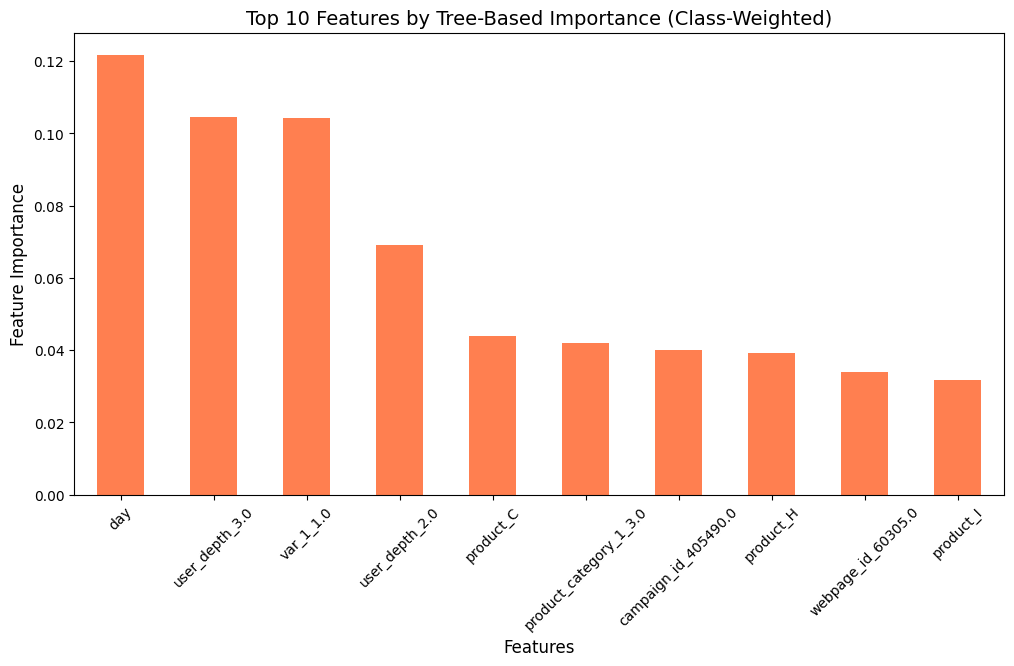

Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.65      0.77     65105
         1.0       0.08      0.45      0.14      4725

    accuracy                           0.64     69830
   macro avg       0.51      0.55      0.46     69830
weighted avg       0.88      0.64      0.73     69830

ROC-AUC Score:
0.5672993394065509


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Drop the 'city_development_index' column
df_processed = df.drop('city_development_index', axis=1)

# Step 2: Drop rows with NaN values
df_processed = df_processed.dropna()

# List of features to exclude from dummy encoding (day, hour, and DateTime)
categorical_cols = ['campaign_id', 'webpage_id', 'product_category_1',
                    'user_group_id', 'age_level', 'user_depth',
                    'var_1', 'product', 'gender']

# Separate features (X) and label (y)
X = df_processed[categorical_cols + ['day', 'hour']]
y = df_processed['is_click']

# Step 3: Convert categorical features to dummy variables (one-hot encoding)
X_dummies = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# Step 4: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_dummies, y, test_size=0.2, random_state=42, stratify=y)

# Step 5: Apply SMOTE to oversample the minority class
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Step 6: Mutual Information (on balanced data)
mi_scores = mutual_info_classif(X_train_smote, y_train_smote, discrete_features=True)
mi_scores = pd.Series(mi_scores, index=X_train.columns).sort_values(ascending=False)

print("Mutual Information Scores (Balanced Data):")
print(mi_scores)

# Visualize Mutual Information
plt.figure(figsize=(12, 6))
mi_scores.head(10).plot(kind='bar', color='skyblue')
plt.title('Top 10 Features by Mutual Information (Balanced Data)', fontsize=14)
plt.ylabel('Mutual Information Score', fontsize=12)
plt.xlabel('Features', fontsize=12)
plt.xticks(rotation=45)
plt.show()

# Step 7: Random Forest with Class Weights
rf_model = RandomForestClassifier(
    random_state=42,
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    max_features='sqrt',
    class_weight='balanced'  # Adjust for class imbalance
)
rf_model.fit(X_train_smote, y_train_smote)
feature_importances = pd.Series(rf_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

print("Tree-Based Feature Importances (Class-Weighted):")
print(feature_importances)

# Visualize Feature Importance
plt.figure(figsize=(12, 6))
feature_importances.head(10).plot(kind='bar', color='coral')
plt.title('Top 10 Features by Tree-Based Importance (Class-Weighted)', fontsize=14)
plt.ylabel('Feature Importance', fontsize=12)
plt.xlabel('Features', fontsize=12)
plt.xticks(rotation=45)
plt.show()

# Select features based on cumulative random forest feature importance (80% threshold)
cumulative_rf = feature_importances.cumsum() / feature_importances.sum()

selected_rf_features = feature_importances[cumulative_rf <= 0.85].index
print(f"Selected Features by Random Forest (80% cumulative importance): {selected_rf_features}")

# Step 8: Train-Test with Selected Features
X_train_selected_rf = X_train[selected_rf_features]
X_test_selected_rf = X_test[selected_rf_features]

# Optionally: Evaluate using metrics focused on minority class
from sklearn.metrics import classification_report, roc_auc_score

y_pred = rf_model.predict(X_test_selected_rf)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, rf_model.predict_proba(X_test_selected_rf)[:, 1]))


Mutual Information Scores:
webpage_id_60305.0        1.067463e-03
campaign_id_405490.0      1.067463e-03
webpage_id_13787.0        7.400400e-04
product_category_1_3.0    6.237143e-04
campaign_id_360936.0      5.858201e-04
day                       2.692866e-04
product_category_1_4.0    2.092319e-04
campaign_id_359520.0      1.716314e-04
product_category_1_5.0    1.292215e-04
campaign_id_118601.0      1.103931e-04
webpage_id_28529.0        1.103931e-04
age_level_4.0             1.006585e-04
product_G                 8.826341e-05
hour                      8.585681e-05
var_1_1.0                 8.304050e-05
product_J                 8.185502e-05
campaign_id_414149.0      6.298922e-05
webpage_id_45962.0        6.298922e-05
product_B                 5.919800e-05
campaign_id_98970.0       5.732346e-05
webpage_id_6970.0         5.732346e-05
user_group_id_4.0         5.483945e-05
product_F                 4.875966e-05
user_group_id_10.0        4.720129e-05
product_category_1_2.0    4.273066e-0

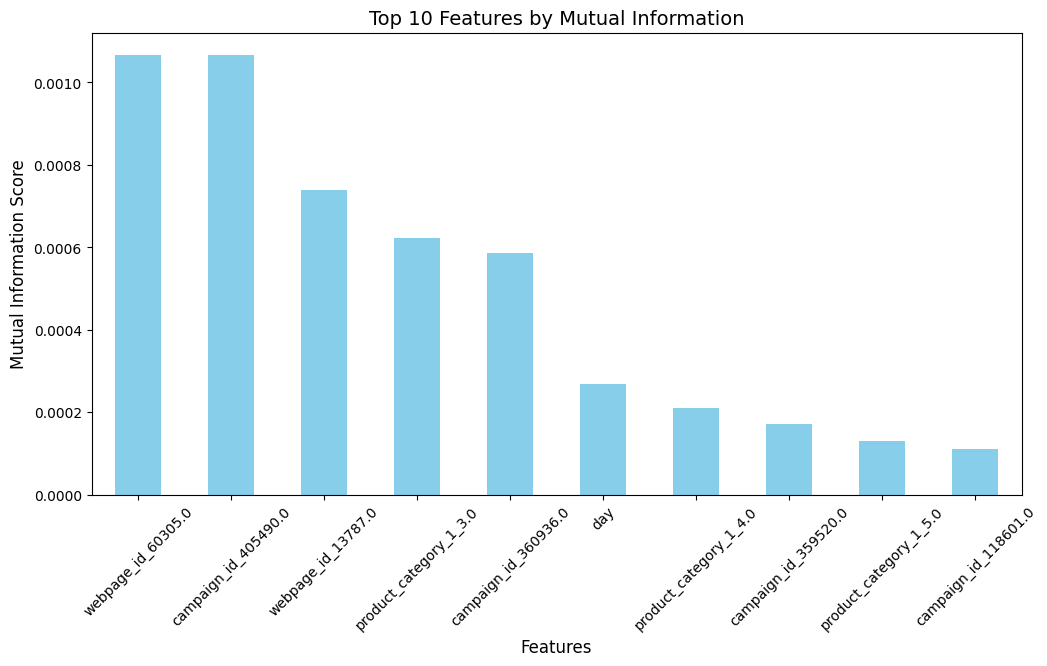

Selected Features by MI (80% cumulative importance): Index(['webpage_id_60305.0', 'campaign_id_405490.0', 'webpage_id_13787.0',
       'product_category_1_3.0', 'campaign_id_360936.0', 'day',
       'product_category_1_4.0', 'campaign_id_359520.0',
       'product_category_1_5.0', 'campaign_id_118601.0', 'webpage_id_28529.0',
       'age_level_4.0'],
      dtype='object')
Tree-Based Feature Importances (Class-Weighted):
day                       0.244118
campaign_id_405490.0      0.134099
webpage_id_60305.0        0.121603
product_category_1_3.0    0.113534
webpage_id_13787.0        0.093316
campaign_id_360936.0      0.080692
product_category_1_5.0    0.049495
age_level_4.0             0.045712
product_category_1_4.0    0.040553
campaign_id_359520.0      0.027771
campaign_id_118601.0      0.026560
webpage_id_28529.0        0.022546
dtype: float64


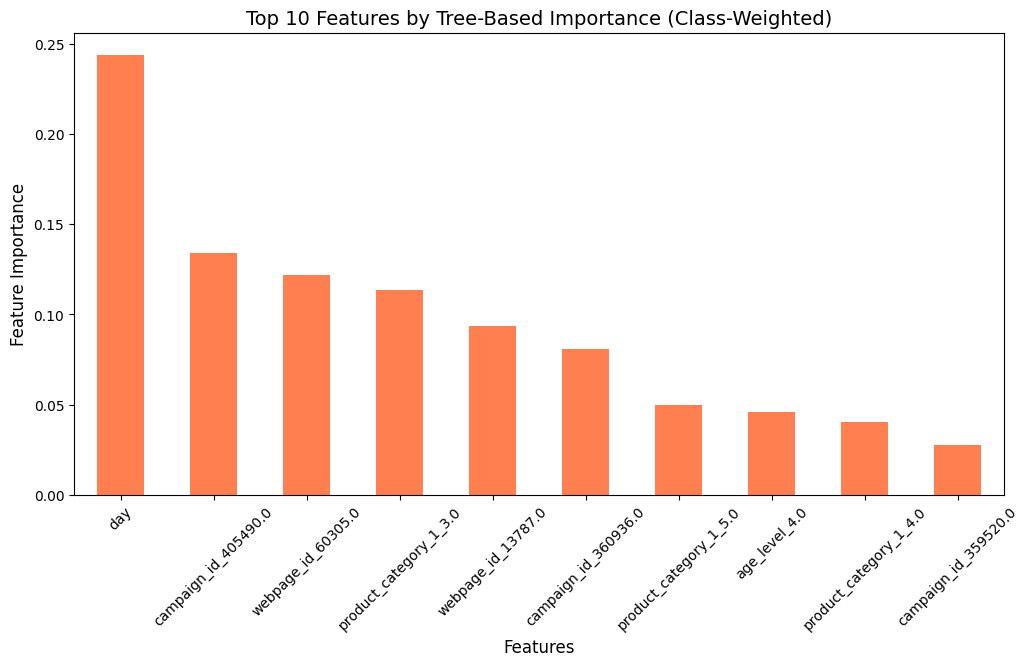

Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.51      0.66     65105
         1.0       0.08      0.59      0.14      4725

    accuracy                           0.52     69830
   macro avg       0.51      0.55      0.40     69830
weighted avg       0.89      0.52      0.63     69830

ROC-AUC Score:
0.5769329658358151


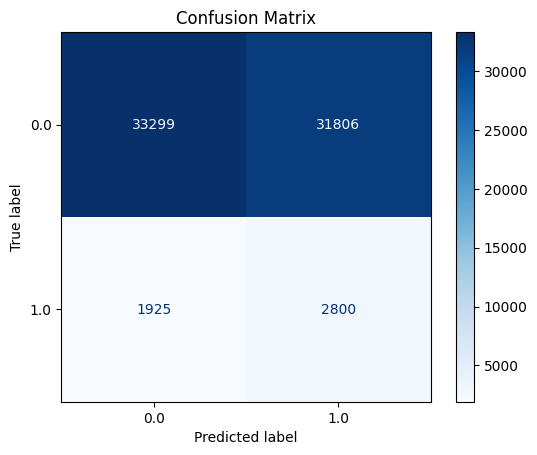

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Step 1: Drop the 'city_development_index' column
df_processed = df_.drop('city_development_index', axis=1)

# Step 2: Drop rows with NaN values
df_processed = df_processed.dropna()

# List of categorical features
categorical_cols = ['campaign_id', 'webpage_id', 'product_category_1',
                    'user_group_id', 'age_level', 'user_depth',
                    'var_1', 'product', 'gender']

# Separate features (X) and label (y)
X = df_processed[categorical_cols + ['day', 'hour']]
y = df_processed['is_click']

# Step 3: Convert categorical features to dummy variables (one-hot encoding)
X_dummies = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# Align train and test feature columns
feature_columns = X_dummies.columns

# Step 4: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_dummies, y, test_size=0.2, random_state=42, stratify=y)

# Ensure consistent feature columns in train and test sets
X_train = X_train.reindex(columns=feature_columns, fill_value=0)
X_test = X_test.reindex(columns=feature_columns, fill_value=0)

# Step 5: Calculate Mutual Information (MI)
mi_scores = mutual_info_classif(X_train, y_train, discrete_features=True)
mi_scores = pd.Series(mi_scores, index=X_train.columns).sort_values(ascending=False)

print("Mutual Information Scores:")
print(mi_scores)

# Visualize Top MI Features
plt.figure(figsize=(12, 6))
mi_scores.head(10).plot(kind='bar', color='skyblue')
plt.title('Top 10 Features by Mutual Information', fontsize=14)
plt.ylabel('Mutual Information Score', fontsize=12)
plt.xlabel('Features', fontsize=12)
plt.xticks(rotation=45)
plt.show()

# Select Top MI Features (e.g., cumulative MI up to 80% of total)
mi_scores_normalized = mi_scores / mi_scores.sum()
cumulative_mi = mi_scores_normalized.cumsum()
selected_mi_features = mi_scores[cumulative_mi <= 0.8].index
print(f"Selected Features by MI (80% cumulative importance): {selected_mi_features}")

X_train_selected = X_train[selected_mi_features]
X_test_selected = X_test[selected_mi_features]

# Step 6: Apply SMOTE to oversample the minority class
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_selected, y_train)

# Step 7: Train Random Forest with Class Weights
rf_model = RandomForestClassifier(
    random_state=42,
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    max_features='sqrt',
    class_weight='balanced'  # Adjust for class imbalance
)
rf_model.fit(X_train_smote, y_train_smote)

# Feature Importance
feature_importances = pd.Series(rf_model.feature_importances_, index=X_train_selected.columns).sort_values(ascending=False)

print("Tree-Based Feature Importances (Class-Weighted):")
print(feature_importances)

# Visualize Feature Importance
plt.figure(figsize=(12, 6))
feature_importances.head(10).plot(kind='bar', color='coral')
plt.title('Top 10 Features by Tree-Based Importance (Class-Weighted)', fontsize=14)
plt.ylabel('Feature Importance', fontsize=12)
plt.xlabel('Features', fontsize=12)
plt.xticks(rotation=45)
plt.show()

# Step 8: Evaluate Model Performance
y_pred = rf_model.predict(X_test_selected)
y_proba = rf_model.predict_proba(X_test_selected)[:, 1]

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("ROC-AUC Score:")
print(roc_auc_score(y_test, y_proba))

# Compute Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Display Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_model.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Mutual Information Scores:
total_sessions_per_user    0.002638
product_campaign_id        0.002585
campaign_id_product        0.002585
product_webpage_id         0.002430
webpage_id_product         0.002430
                             ...   
var_1                      0.000067
gender_user_depth          0.000017
user_depth_gender          0.000017
user_depth                 0.000010
gender                     0.000007
Length: 85, dtype: float64


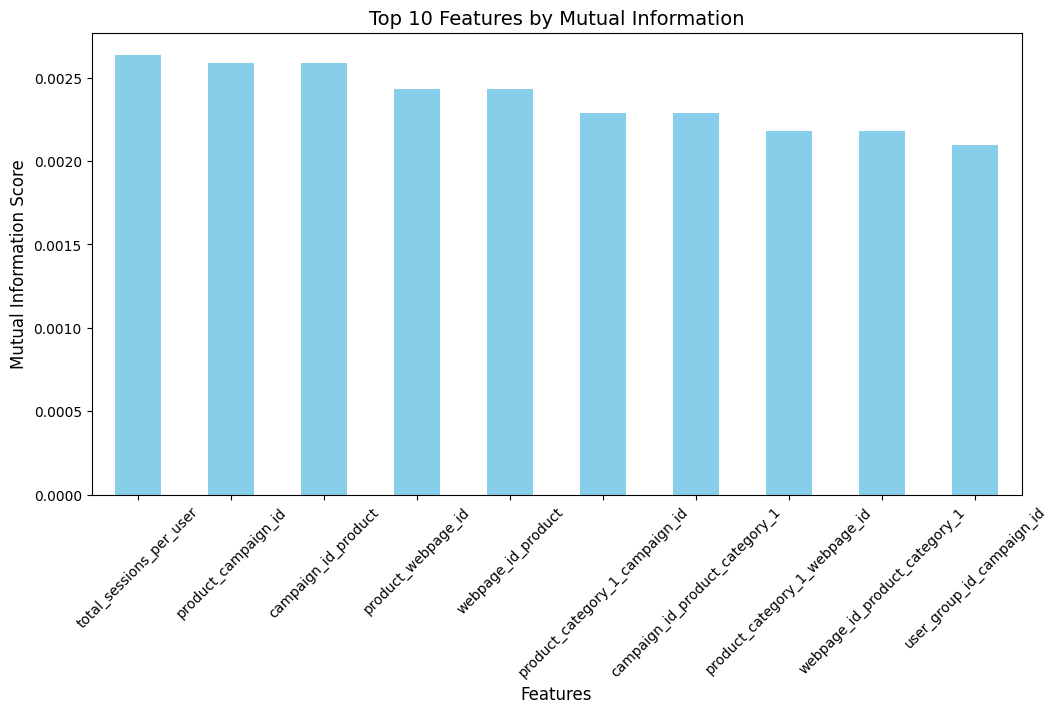

Tree-Based Feature Importances:
total_sessions_per_user    0.151567
hour                       0.075179
day                        0.053375
day_binary                 0.032410
webpage_id_product         0.025299
                             ...   
gender_var_1               0.003068
campaign_id_webpage_id     0.002801
user_depth                 0.002497
var_1                      0.001879
gender                     0.000544
Length: 85, dtype: float64


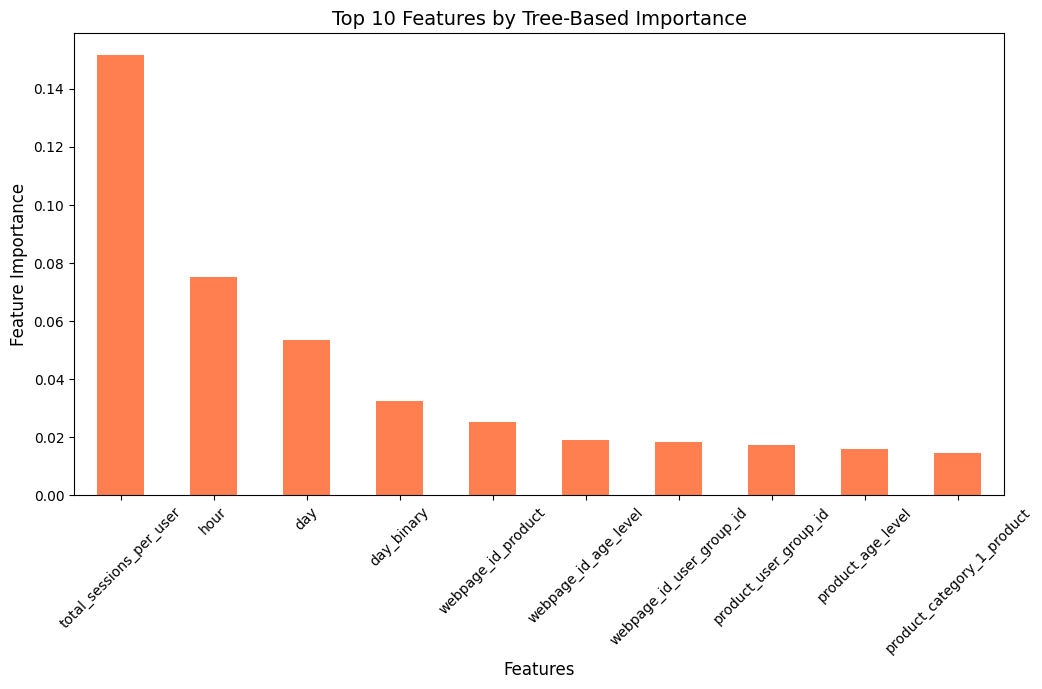

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif, chi2
from sklearn.preprocessing import LabelEncoder
from google.colab import drive
import warnings
warnings.filterwarnings('ignore')

# Mount Google Drive
drive.mount('/content/drive')

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/train_dataset_full.csv')
df_ = df.copy()
# Preprocessing
df_.drop(['product_category_2', 'city_development_index'], axis=1, inplace=True)
df_ = df_[~df_['session_id'].duplicated(keep='first') | df_['session_id'].isna()]
df_.dropna(subset=['is_click'], axis=0, inplace=True)
labels = ['gender', 'age_level', 'user_group_id']
df_[labels] = df_.groupby('user_id')[labels].transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))
df_ = df_.dropna(thresh=len(df_.columns) - 5)
df_['DateTime'] = pd.to_datetime(df_['DateTime'])
df_['day'] = df_['DateTime'].dt.day
df_['hour'] = df_['DateTime'].dt.hour

df_['total_sessions_per_user'] = df_.groupby('user_id')['session_id'].transform('count')
df_['day_binary'] = (df_['day'] > 4.5).astype(int)
df_ = df_.dropna(axis=0)


# Generate all pairwise categorical combinations
categorical_cols = ['campaign_id', 'webpage_id', 'product_category_1', 'user_group_id', 'age_level', 'user_depth', 'var_1', 'product', 'gender']
for col1 in categorical_cols:
    for col2 in categorical_cols:
        if col1 != col2:
            df_[f'{col1}_{col2}'] = df_[col1].astype(str) + '_' + df_[col2].astype(str)

# Encoding categorical pair features
for col in df_.select_dtypes(include=['object']).columns:
    df_[col] = LabelEncoder().fit_transform(df_[col])

# Separate features (X) and label (y)
X = df_.drop(columns=['is_click', 'session_id', 'user_id', 'DateTime'])
y = df_['is_click']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Mutual Information
mi_scores = mutual_info_classif(X_train, y_train, discrete_features=True)
mi_scores = pd.Series(mi_scores, index=X_train.columns).sort_values(ascending=False)

print("Mutual Information Scores:")
print(mi_scores)

# Visualize Mutual Information
plt.figure(figsize=(12, 6))
mi_scores.head(10).plot(kind='bar', color='skyblue')
plt.title('Top 10 Features by Mutual Information', fontsize=14)
plt.ylabel('Mutual Information Score', fontsize=12)
plt.xlabel('Features', fontsize=12)
plt.xticks(rotation=45)
plt.show()

# Step 7: Tree-Based Feature Importance
model = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10, min_samples_split=5, max_features='sqrt')
model.fit(X_train, y_train)
feature_importances = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

print("Tree-Based Feature Importances:")
print(feature_importances)

# Visualize Feature Importance
plt.figure(figsize=(12, 6))
feature_importances.head(10).plot(kind='bar', color='coral')
plt.title('Top 10 Features by Tree-Based Importance', fontsize=14)
plt.ylabel('Feature Importance', fontsize=12)
plt.xlabel('Features', fontsize=12)
plt.xticks(rotation=45)
plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Mutual Information Scores:
total_sessions_per_user           0.002638
product_campaign_id               0.002585
campaign_id_product               0.002585
product_webpage_id                0.002430
webpage_id_product                0.002430
product_category_1_campaign_id    0.002290
campaign_id_product_category_1    0.002290
product_category_1_webpage_id     0.002181
webpage_id_product_category_1     0.002181
user_group_id_campaign_id         0.002097
dtype: float64


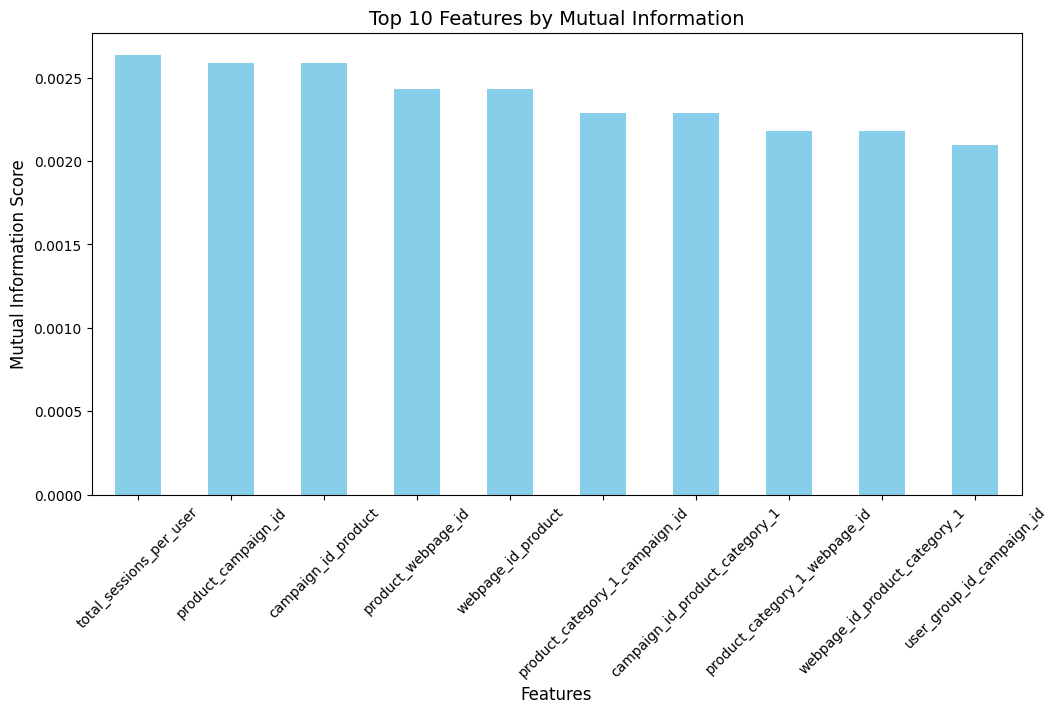

Tree-Based Feature Importances:
total_sessions_per_user       0.151567
hour                          0.075179
day                           0.053375
day_binary                    0.032410
webpage_id_product            0.025299
webpage_id_age_level          0.018928
webpage_id_user_group_id      0.018296
product_user_group_id         0.017372
product_age_level             0.015762
product_category_1_product    0.014610
dtype: float64


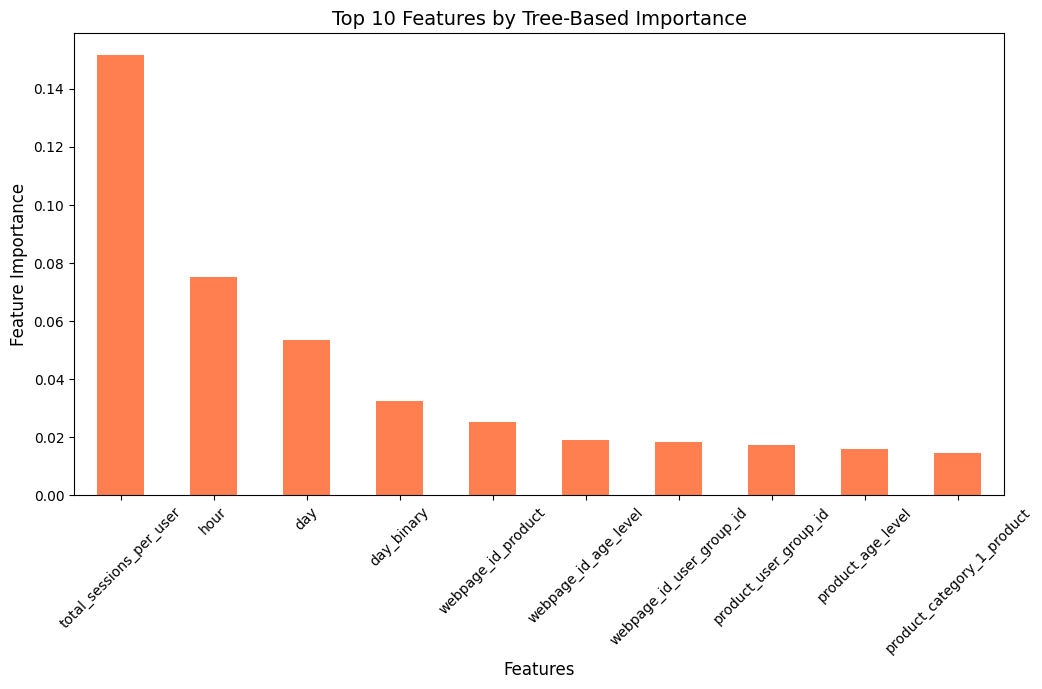

Chi-Square Statistic: 2793176.0
P-Value: 0.0
There is a significant correlation between campaign_id and webpage_id.


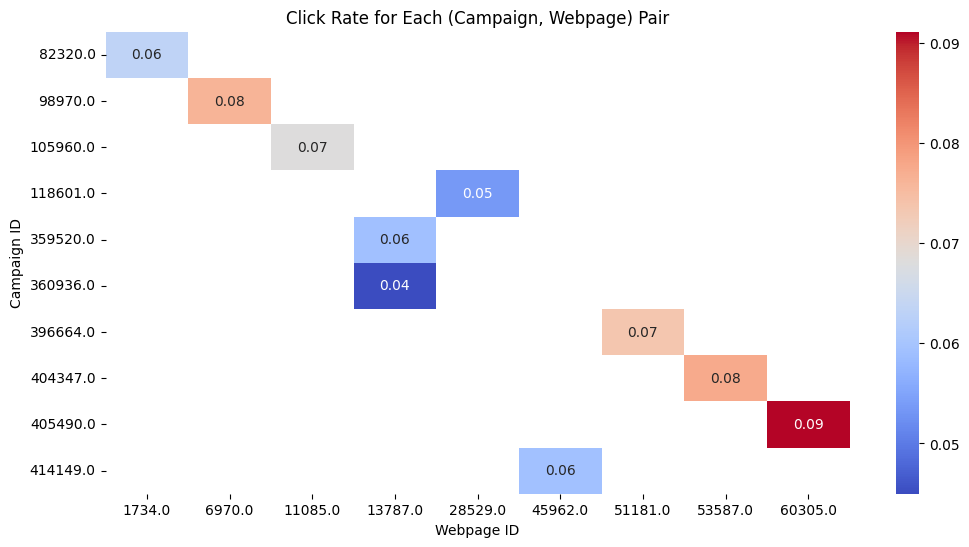

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif, chi2
from sklearn.preprocessing import LabelEncoder
from scipy.stats import chi2_contingency
from google.colab import drive
import warnings
warnings.filterwarnings('ignore')

# Mount Google Drive
drive.mount('/content/drive')

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/train_dataset_full.csv')
df_ = df.copy()

# Preprocessing
df_.drop(['product_category_2', 'city_development_index'], axis=1, inplace=True)
df_ = df_[~df_['session_id'].duplicated(keep='first') | df_['session_id'].isna()]
df_.dropna(subset=['is_click'], axis=0, inplace=True)
labels = ['gender', 'age_level', 'user_group_id']
df_[labels] = df_.groupby('user_id')[labels].transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))
df_ = df_.dropna(thresh=len(df_.columns) - 5)
df_['DateTime'] = pd.to_datetime(df_['DateTime'])
df_['day'] = df_['DateTime'].dt.day
df_['hour'] = df_['DateTime'].dt.hour

df_['total_sessions_per_user'] = df_.groupby('user_id')['session_id'].transform('count')
df_['day_binary'] = (df_['day'] > 4.5).astype(int)
df_ = df_.dropna(axis=0)

# Generate all pairwise categorical combinations
categorical_cols = ['campaign_id', 'webpage_id', 'product_category_1', 'user_group_id', 'age_level', 'user_depth', 'var_1', 'product', 'gender']
for col1 in categorical_cols:
    for col2 in categorical_cols:
        if col1 != col2:
            df_[f'{col1}_{col2}'] = df_[col1].astype(str) + '_' + df_[col2].astype(str)

# Encoding categorical pair features
for col in df_.select_dtypes(include=['object']).columns:
    df_[col] = LabelEncoder().fit_transform(df_[col])

# Separate features (X) and label (y)
X = df_.drop(columns=['is_click', 'session_id', 'user_id', 'DateTime'])
y = df_['is_click']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Mutual Information Analysis
mi_scores = mutual_info_classif(X_train, y_train, discrete_features=True)
mi_scores = pd.Series(mi_scores, index=X_train.columns).sort_values(ascending=False)

print("Mutual Information Scores:")
print(mi_scores.head(10))

# Visualize Mutual Information
plt.figure(figsize=(12, 6))
mi_scores.head(10).plot(kind='bar', color='skyblue')
plt.title('Top 10 Features by Mutual Information', fontsize=14)
plt.ylabel('Mutual Information Score', fontsize=12)
plt.xlabel('Features', fontsize=12)
plt.xticks(rotation=45)
plt.show()

# Tree-Based Feature Importance
model = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10, min_samples_split=5, max_features='sqrt')
model.fit(X_train, y_train)
feature_importances = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

print("Tree-Based Feature Importances:")
print(feature_importances.head(10))

# Visualize Feature Importance
plt.figure(figsize=(12, 6))
feature_importances.head(10).plot(kind='bar', color='coral')
plt.title('Top 10 Features by Tree-Based Importance', fontsize=14)
plt.ylabel('Feature Importance', fontsize=12)
plt.xlabel('Features', fontsize=12)
plt.xticks(rotation=45)
plt.show()

# Chi-Square Test for Categorical Dependency
contingency_table = pd.crosstab(df_['campaign_id'], df_['webpage_id'])
chi2_stat, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-Square Statistic: {chi2_stat}")
print(f"P-Value: {p}")
if p < 0.05:
    print("There is a significant correlation between campaign_id and webpage_id.")
else:
    print("There is no significant correlation between campaign_id and webpage_id.")

# Click Rate Heatmap
click_rates = df_.groupby(['campaign_id', 'webpage_id'])['is_click'].mean().unstack()
plt.figure(figsize=(12, 6))
sns.heatmap(click_rates, cmap='coolwarm', annot=True, fmt=".2f")
plt.title("Click Rate for Each (Campaign, Webpage) Pair")
plt.xlabel("Webpage ID")
plt.ylabel("Campaign ID")
plt.show()
